# **Libraries**

In [ ]:
!pip install ucimlrepo==0.0.7
!pip install dcor==0.6
!pip uninstall -y scikit-learn
!pip install scikit-learn==1.5.2
!pip install xgboost==2.1.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 2.3 MB/s eta 0:00:00
Found existing installation: scikit-learn 1.6.0
Uninstalling scikit-learn-1.6.0:
  Successfully uninstalled scikit-learn-1.6.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 88.7 MB/s eta 0:00:00


In [ ]:
# Importing Libraries

## Data import
from ucimlrepo import fetch_ucirepo

## Data manipulation
import numpy as np
import pandas as pd

## Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

## Data preprocessing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    LabelEncoder,
    OneHotEncoder,
    MinMaxScaler,
  )
from dcor import distance_correlation
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer


## Validation and Hyperparameter tuning
from sklearn.model_selection import (
    KFold,
    StratifiedKFold,
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    train_test_split
  )


## Models
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import (
    RandomForestClassifier,
    RandomForestRegressor,
    GradientBoostingClassifier,
    HistGradientBoostingClassifier,
    ExtraTreesClassifier,
    ExtraTreesRegressor
  )
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.inspection import permutation_importance


## Performance metrics
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    balanced_accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score
  )

## Scipy functions
from scipy.stats import randint

## Othe imports
import time
import datetime
import warnings
from os import rename
from google.colab import files
# Ignore the UndefinedMetricWarning
warnings.filterwarnings("ignore")
RANDOM_STATE=2025

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


# **Base functions**

**Load data**

In [ ]:
def load_data_from_ucimlrepo(repo_id, variable_rename_dict=None):
  # fetch dataset
  dataset = fetch_ucirepo(id=repo_id)

  # metadata
  print(dataset.metadata)

  # variable information
  print(dataset.variables)
  variables_df = dataset.variables
  variables_df['name'] = variables_df['name'].str.lstrip()

  # data (as pandas dataframes)
  df = dataset.data.features

  # Rename columns using the dictionary
  if variable_rename_dict:
    df = df.rename(columns=variable_rename_dict)
    variables_df['name'] = variables_df['name'].map(variable_rename_dict)

  df['Target'] = dataset.data.targets

  # Remove spaces at the beginning of each column name
  df.columns = df.columns.str.lstrip()
  return df, variables_df

**Variable encoding**

In [ ]:
def encode_binary_variables(df, binary_cols, binary_values):
  for col in binary_cols:
      df[col] = df[col].map(binary_values)
  return df

def one_hot_encoding(df, categorical_cols, encoder=None):
  """
  Performs one-hot encoding on specified categorical columns.

  Args:
      df: The input DataFrame.
      categorical_cols: A list of categorical columns to encode
      encoder: if mode 'test', receives here the scaler object to be used

  Returns:
      A DataFrame with the categorical columns one-hot encoded.
  """
  # Initialize encoder
  if encoder is None:  # train mode
    encoder = OneHotEncoder(
        drop='first', sparse_output=False, handle_unknown='ignore'
    )
    # Fit and transform training data
    encoded_df = encoder.fit_transform(df[categorical_cols])
  else:  # test mode
    # Transform test data using same encoding
    encoded_df = encoder.transform(df[categorical_cols])

  # Convert to DataFrame with proper column names
  feature_names = encoder.get_feature_names_out(categorical_cols)
  encoded_df = pd.DataFrame(encoded_df, columns=feature_names, index=df.index)

  non_categorical_cols = [col for col in df.columns if col not in categorical_cols]
  final_df = pd.concat([df[non_categorical_cols], encoded_df], axis=1)
  return final_df, encoder


def map_encoded_variables_to_original(encoded_vars, categorical_vars):
  """
  Creates a dictionary that maps each one-hot encoded variable to its
  original categorical variable.

  Args:
      encoded_vars: A list of one-hot encoded variable names.
      categorical_vars: A list of original categorical variable names.

  Returns:
      A dictionary with one-hot encoded variables as keys and original
      categorical variables as values.
  """
  # dictionary to store the mapping
  one_hot_mapping = {}

  # Iterate through original categorical variables
  for cvar in categorical_vars:
      # Get the one-hot encoded columns derived from this original column
      encoded_cols = [c for c in encoded_vars if c.startswith(cvar + "_")]
      # Map encoded columns to the original column
      for evar in encoded_cols:
          one_hot_mapping[evar] = cvar
  return one_hot_mapping


def map_variables_same_timeline(vars_list, time_identifiers_lst):
  """
  Creates a dictionary that maps each variable to its timeline.
  It will be useful for the feature drop on the testing set due to missing values.

  Args:
      vars_list: list of variable names to be analysed.
      time_identifiers_lst: list of timeline identifiers.

  Returns:
      A dictionary with feature names as keys and their timeline as values.
  """
  # dictionary to store the mapping
  temporal_mapping = {}

  # Assign each chronological variable to its timeline
  for time_id in time_identifiers_lst:
    temporal_cols = [col for col in vars_list if time_id in col]
    for col in temporal_cols:
      temporal_mapping[col] = time_id

  return temporal_mapping

**Feature scaling:**

- In use for SVM and LR algorithms.
- MinMax Scaler chosen due to maintaining binary/ohe variables original values, meanwhile numerical variables get a similar domain of variation. This choice keeps the full interpretability of binary/ohe variables.

In [ ]:
def scale_minmax_features(df, mode, scaler = None):
  """
  Scale features to range [0,1] using MinMaxScaler

  Args:
      df: dataframe with the features to be scaled
      mode: 'train' or 'test'
      scaler: if mode 'test', receives here the scaler object to be used

  Returns:
      df_scaled: scaled features
      scaler: fitted scaler object
  """
  if mode == 'train':
      # Initialize the scaler
    scaler = MinMaxScaler()
    # Fit on training data and transform it
    df_scaled = scaler.fit_transform(df)
  else:
    # Transform test data using the fitted scaler
    df_scaled = scaler.transform(df)

  # Convert back to DataFrames with original column names
  df_scaled = pd.DataFrame(df_scaled, columns=df.columns)

  return df_scaled, scaler

**Data summary and quality**

In [ ]:
def describe_data(df):
  # Dimension
  print("\nData dimension :")
  print("Number of Records : ",df.shape[0],"\nNumber of Features : ", df.shape[1])

  # Datatype of columns
  print("\nDatatype of Features :")
  print(df.dtypes.value_counts())

  # Missing values
  print("\nMissing values :")
  na_value_check = df.isna().sum()
  if len(na_value_check[na_value_check > 0]) == 0 :
      print("Missing values not identified")
  else :
      print(na_value_check[na_value_check > 0])

  # Duplicated records check
  print("\nDuplicated records :")
  duplicate_rows = df.duplicated()
  if len(df[duplicate_rows]) == 0:
      print("Duplicated records not identified")
  else :
      print("Number of duplicated records :",len(df[duplicate_rows]))

  # data summary
  print("\nData summary :")
  print(df.describe())

**Correlation**

In [ ]:
def non_numeric_variables(df, exclude_types):
  # Filter out variables that are not mumeric
  non_numeric_variables = df.select_dtypes(exclude=exclude_types)
  return non_numeric_variables.columns.tolist()

def create_heatmap(matrix, title, center=0, mask=None):
  # Create a heatmap from the matrix provided as input
  f, ax = plt.subplots(figsize=(11, 9))
  cmap = sns.diverging_palette(230, 20, as_cmap=True)
  sns.heatmap(matrix, cmap=cmap, center=center,
              mask=mask, linewidths=.5,
              cbar_kws={"shrink": .5})
  plt.title(title)
  plt.show()

def calculate_correlation(df, corr_method, features='all'):
  # Compute the correlation matrix
  if features == "all":
    corr = df.corr(method=corr_method)
  else :
    corr = df[features].corr()

  # Create a mask to hide the upper triangle of the correlation matrix
  mask = np.triu(np.ones_like(corr, dtype=bool))

  # Generate a heatmap with the correlation matrix
  create_heatmap(corr, title="Correlation matrix", mask=mask)
  return corr

In [ ]:
def calculate_distance_correlation_matrix(df, features='all', debug=False):
    """
    Calculates the distance correlation matrix for a given DataFrame.

    Args:
      df: the input DataFrame
      features: 'all' or a list of the features to be considered
      debug: True / False to control the printing of additional information

    Returns:
      A distance correlation matrix as a pandas DataFrame.
      Produces a heatmap for the distance correlation matrix.
    """

    # Select features
    if features == "all":
        selected_df = df
    else:
        selected_df = df[features]

    print('df columns: ', selected_df.columns)

    # Convert all int64 columns in float64 to avoid errors
    int64_cols = selected_df.select_dtypes(include=['int64']).columns
    selected_df[int64_cols] = df[int64_cols].astype('float64')

    # Initialize distance correlation matrix
    n_features = len(selected_df.columns)
    print('num_features: ', n_features)
    dcor_matrix = pd.DataFrame(
        np.zeros((n_features, n_features)),
        index=selected_df.columns,
        columns=selected_df.columns
    )

    # Calculate distance correlation for each pair
    for i, col1 in enumerate(selected_df.columns):
        if debug: print('col1: ', col1)
        for j, col2 in enumerate(selected_df.columns):
            if debug: print('----- col2: ', col2)
            if i <= j:  # Only calculate upper triangle
                # Convert categorical variables to numeric
                x = pd.Categorical(selected_df[col1]).codes if selected_df[col1].dtype == 'object' else selected_df[col1]
                y = pd.Categorical(selected_df[col2]).codes if selected_df[col2].dtype == 'object' else selected_df[col2]

                # Calculate distance correlation
                dcor = distance_correlation(x, y, method='mergesort')

                dcor_matrix.iloc[i, j] = dcor
                dcor_matrix.iloc[j, i] = dcor  # Matrix is symmetric

    # Create mask for upper triangle
    mask = np.triu(np.ones_like(dcor_matrix, dtype=bool))
    # Create heatmap
    create_heatmap(dcor_matrix, title="Distance Correlation Matrix", mask=mask)
    return dcor_matrix

In [ ]:
def plot_dcor_histogram(dcor_df):
    """
    Reads a distance correlation (dcor) DataFrame and produces a histogram
    of the distance correlations, displaying percentages on the y-axis.
    Also prints the percentage of correlations below different thresholds.

    Args:
      dcor_df : The distance correlation matrix as a pandas DataFrame.

    Returns:
      Histogram plot of the distance corelations between features.
    """

    # Flatten the matrix and exclude diagonal elements for histogram
    flattened_dcor = dcor_df.where(~np.eye(dcor_df.shape[0], dcor_df.shape[1], dtype=bool)).stack()

    # Create histogram with 10 equally spaced bins from 0 to 1.0
    bins = np.linspace(0, 1.0, 11)  # Creates bins with edges at 0, 0.1, ..., 1
    plt.figure(figsize=(8, 6))
    n, bins, patches = plt.hist(flattened_dcor, bins=bins, color='blue', alpha=0.7, edgecolor='black')

    # Convert counts to percentages of total
    total_count = flattened_dcor.count()
    percentage_heights = (n / total_count) * 100  # Multiply by 100 for actual percentage values

    # Set y-axis labels to percentages
    for i in range(len(patches)):
        patches[i].set_height(percentage_heights[i])  # Update patch height
        plt.text(patches[i].get_x() + patches[i].get_width() / 2,
                 percentage_heights[i] + 0.5,  # Add 0.5 for better spacing
                 f'{percentage_heights[i]:.2f}%',  # Display percentage with 2 decimal places
                 ha='center', va='bottom')

    plt.title('Histogram of Distance Correlations (% of Total)')
    plt.xlabel('Distance Correlation')
    plt.ylabel('% of Total Correlations')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.ylim(0, max(percentage_heights) + 5)  # Set y-axis limits slightly above max percentage
    plt.show()

    # Calculate and print percentage of correlations below different thresholds
    for i in np.arange(0.1, 1.1, 0.1):  # From 0.1 to 1.0 in steps of 0.1
        percentage_below = (flattened_dcor[flattened_dcor <= i].count() / total_count) * 100
        print(f"Percentage of correlations below {i:.1f}: {percentage_below:.2f}%")

**Pre-feature selection**

In [ ]:
def identify_zero_variance_columns(df):
  # Calculate the variance of each column
  variances = df.var()
  print("Variance of each column:")
  print(variances)

  # Identify columns with zero variance
  zero_variance_columns = variances[variances <= 1.00e-10].index.tolist()
  print("Columns with zero variance to be dropped:")
  print(zero_variance_columns)
  return zero_variance_columns


def identify_weak_associated_features(association_matrix, target_variable, threshold=0.1):
  """
  Identifies features with a weak association with the target variable.

  Args:
    association_matrix: usually a correlation matrix as dataframe
    target_variable: The name of the target variable column.
    threshold: value for which correlations below are considered weak

  Returns:
    A list of feature names that have a association with the target variable
    lower than the threshold.
  """
  target_association = association_matrix[target_variable]
  weak_associated_features = target_association[
      abs(target_association) < threshold
  ].index.tolist()
  print("Features with weak association with the target variable:")
  print(weak_associated_features)
  return weak_associated_features


def filter_out_intercorrelated_features(corr_df, target_name, correlation_threshold=0.8):
  """
  Filters highly correlated features based on a distance correlation matrix.

  Args:
      corr_df: Dataframe with the correlation matrix
      target_name: Name of the column with the target
      correlation_threshold: The threshold for correlation above which features
                             are considered highly correlated.

  Returns:
      A list of features after dropping of intercorrelated
  """

  # get a list with the features sorted by correlation with target
  target_correlations = corr_df[target_name].sort_values(ascending=False)
  sorted_correlated_feat_with_target = [feat for feat in target_correlations.index if feat != target_name]

  selected_features = []
  eliminated_features = []

  # Iterate through features, starting with the most correlated to the target
  for feat in sorted_correlated_feat_with_target:
      if feat not in eliminated_features:  # If not already eliminated
          selected_features.append(feat)
          print('appended feature: ', feat)

          # Eliminate other features highly correlated with the current feature
          for other_feat in sorted_correlated_feat_with_target:
              if other_feat != feat and other_feat not in eliminated_features:
                  correlation = corr_df[corr_df.index==feat][other_feat][0]
                  if abs(correlation) > correlation_threshold:
                      eliminated_features.append(other_feat)
                      print('eliminated feature: ', other_feat, correlation)
  return selected_features

**Missing values handling**

**Simple imputation (median and mode):** Missing values will be inputed with the median for numerical variables and with the model for binary/ohe variables. This choice guarantees that the value inputed is a value that makes sense for the domain of each variable and also avoid the influence of outliers or long-tailed distributions.

**Imputation via MissForest:** The missing values are inputed via an ensemble model that makes use of all other features available at the moment. Note that for this use case a new MissForest algorithm has to be run at each scenario, because the features available will change. Otherwise there will be unfair data leakage. The implementation used for MissForest uses ExtraTrees instead of Random Forests in accordance with the suggestion from Scikit Learn as present in: https://scikit-learn.org/0.21/auto_examples/impute/plot_iterative_imputer_variants_comparison.html

Note: In the case of models that require feature scaling (normalization), the simple inputation will be based on the median and mode of features after scaling.

In [ ]:
def calculate_imputation_values_for_missing(df):
  """
  Calculates the median for numeric columns and mode for non-numeric columns in a DataFrame.

  Args:
    df: The pandas DataFrame.

  Returns:
    A dictionary with column names as keys and their median/mode as values.
  """
  imputation_dict = dict()
  for column in df.columns:
    if pd.api.types.is_numeric_dtype(df[column]):
      imputation_dict[column] = df[column].median()
    else:
      imputation_dict[column] = df[column].mode()[0] if not df[column].mode().empty else None
  return imputation_dict


def imputation_missforest(train_df, test_df, cat_vars_list=[]):
  """
  Auxiliary function for Performance Decay
  Imputes missing values in the testing datasets using the MissForest algorithm.

  Args:
    train_df / test_df: DataFrame with training/test data
    cat_vars_list: list of categorical variables for imputation

  Returns:
    test_df_imputed: DataFrame with imputed missing values by MissForest
  """
  # check of the nr of columsn with nan
  nan_counts_per_column = test_df.isnull().any()
  num_columns_with_nan = nan_counts_per_column.sum()
  print('Nr. columns with nan: ', num_columns_with_nan)
  columns_with_nulls = test_df.columns[test_df.isnull().any()].tolist()

  # identify categorical and numerical features
  categorical = cat_vars_list
  numerical = [col for col in test_df.columns if col not in categorical and col!='Type']
  print('Numerical columns: ', numerical)
  print('Categorical columns: ', categorical)

  train_df['Type'] = 'Train'
  test_df['Type'] = 'Test'
  df = pd.concat([train_df, test_df], axis=0, ignore_index=True)
  df_imputation = df.drop(columns=['Type'])
  """
  # missforest with random forests

  imp_num = IterativeImputer(estimator=RandomForestRegressor(n_jobs=-1, random_state=RANDOM_STATE),
                              initial_strategy='median',
                              max_iter=1, random_state=RANDOM_STATE)
  imp_cat = IterativeImputer(estimator=RandomForestClassifier(n_jobs=-1, random_state=RANDOM_STATE),
                              initial_strategy='most_frequent',
                              max_iter=1, random_state=RANDOM_STATE)
  """

  # missforest with extra trees (faster and with similar performance)
  imp_num = IterativeImputer(estimator=ExtraTreesRegressor(
                              max_features='sqrt',
                              n_jobs=-1,
                              random_state=RANDOM_STATE),
                              initial_strategy='median',
                              max_iter=1, random_state=RANDOM_STATE)
  imp_cat = IterativeImputer(estimator=ExtraTreesClassifier(
                              n_jobs=-1,
                              random_state=RANDOM_STATE),
                              initial_strategy='most_frequent',
                              max_iter=1, random_state=RANDOM_STATE)

  if len(numerical)>0:
    df_imputation[numerical] = imp_num.fit_transform(df_imputation[numerical])

  if len(categorical)>0:
    df_imputation[categorical] = imp_cat.fit_transform(df_imputation[categorical])

  # test_df_imputed and auxiliary info to be displayed along the imputation
  test_df_imputed = df_imputation[df['Type']=='Test']
  for col in columns_with_nulls:
    print('Column imputed: ', col)
    if col in numerical:
      print('Mean: ', test_df_imputed[col].mean())
      print('Std deviation: ', test_df_imputed[col].std())
    else:
      print(test_df_imputed[col].value_counts())
  return test_df_imputed

**Model training / Feature permutation importance / Hyperparameter optimization**

In [ ]:
def apply_model(model, X_train, y_train, X_test, y_test):
  # Fit the model
  model.fit(X_train, y_train)
  y_train_pred = model.predict(X_train)
  y_test_pred = model.predict(X_test)

  return model, y_train_pred, y_test_pred


def analyze_feat_permut_import(
    model, X, y, scoring_metric, n_repeats=5, random_state=RANDOM_STATE
):
    # Calculate permutation importance
    result = permutation_importance(
        model, X, y, scoring=scoring_metric, n_repeats=n_repeats,
        random_state=random_state, n_jobs=-1
    )

    # Create DataFrame with results
    importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': result.importances_mean,
        'Std': result.importances_std
    }).sort_values(by='Importance', ascending=True)

    return importance_df.sort_values(by='Importance', ascending=False)


def plot_feat_permut_importance(feat_imp_df, threshold=0, k=20):
  # Filter features with importance above the threshold
  feat_imp_plot = feat_imp_df[feat_imp_df['Importance'] > threshold]
  feat_imp_plot = feat_imp_plot.sort_values(by='Importance', ascending=False)

  # select the top k features
  if len(feat_imp_plot) > k:
    feat_imp_plot = feat_imp_plot.head(k)

  # Create a bar chart
  plt.figure(figsize=(10, 6))
  plt.barh(feat_imp_plot['Feature'], feat_imp_plot['Importance'])
  plt.xlabel('Importance')
  plt.ylabel('Feature')
  plt.title('Feature Permutation Importance')
  plt.gca().invert_yaxis()  # Display the highest importance at the top
  plt.show()


def plot_feature_importance(model, importance_threshold, col_names):
  if model.__class__.__name__ == 'LGBMClassifier':
    feature_importances = model.booster_.feature_importance(importance_type='split')
  else:
    feature_importances = model.feature_importances_

  # Create a DataFrame with feature names and importances
  feature_importance_df = pd.DataFrame({'Feature': col_names, 'Importance': feature_importances})

  # Sort features by importance in descending order
  feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

  # Filter features with importance above the threshold
  feature_importance_plot = feature_importance_df[feature_importance_df['Importance'] >= importance_threshold]
  if len(feature_importance_plot) > 20:
    feature_importance_plot = feature_importance_plot.head(20)

  # Create a bar chart
  plt.figure(figsize=(10, 6))
  plt.barh(feature_importance_plot['Feature'], feature_importance_plot['Importance'])
  plt.xlabel('Importance')
  plt.ylabel('Feature')
  plt.title('Feature Importance')
  plt.gca().invert_yaxis()  # Display the highest importance at the top
  plt.show()
  return feature_importance_df


def hyperparameter_tuning(model, param_grid, k_hyp_par, k_cv, scoring_metric, X, y):
    """
    Performs hyperparameter tuning using nested cross-validation.

    Args:
        model: The base model to be tuned.
        param_grid: A dictionary containing the hyperparameter grid.
        k_hyp_par: The number of folds for the inner cross-validation.
        k_cv: The number of folds for the outer cross-validation.
        scoring_metric: The scoring metric to be used for evaluation.
        X: The feature matrix.
        y: The target variable.

    Returns:
        A tuple containing the fitted GridSearchCV object, nested scores, and best parameters.
    """
    # Time control
    start_time = time.time()
    print(f"Starting hyperparameter tuning at: {datetime.datetime.now()}")

    # Cross-validation strategies for inner and outer loops
    cv_inner = StratifiedKFold(n_splits=k_hyp_par, shuffle=True, random_state=RANDOM_STATE)
    cv_outer = StratifiedKFold(n_splits=k_cv, shuffle=True, random_state=RANDOM_STATE)

    # Hyperparameter tuning
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=cv_inner,
        scoring=scoring_metric,
        verbose=3,
        n_jobs=-1,
        return_train_score=True,  # To help diagnose overfitting/underfitting
        refit=True
    )

    # Perform nested cross-validation
    nested_scores = cross_val_score(
        grid_search,
        X=X,
        y=y,
        cv=cv_outer,
        scoring=scoring_metric,
        n_jobs=-1
    )

    # Print cross-validation results
    print("\nNested Cross-validation Results:")
    print(f"Individual scores: {nested_scores}")
    print(f"Average nested CV score: {nested_scores.mean():.3f} (+/- {nested_scores.std() * 2:.3f})")

    # Fit the model on the entire dataset
    print("\nFitting final model on entire dataset...")
    grid_search.fit(X, y)

    # Get best parameters and scores
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    print(f"Best parameters: {best_params}")
    cv_results = pd.DataFrame(grid_search.cv_results_)

    print("\nBest Model Performance:")
    print(f"Best CV score: {grid_search.best_score_:.3f}")

    # Print execution time
    print(datetime.datetime.now())
    end_time = time.time()
    execution_time = (end_time - start_time) / 60
    print(f"\nExecution time: {execution_time:.2f} minutes")

    return grid_search, best_model, best_params

**Performance**

In [ ]:
# Calculation of performance metrics
def perf_metrics(y_true, y_pred_binary):
    """
    Returns a dictionary with the values of the main metrics
    """
    # Calculate Specificity using confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_binary).ravel()
    specificity = tn / (tn + fp)

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred_binary)
    balanced_accuracy = balanced_accuracy_score(y_true, y_pred_binary)
    precision = precision_score(y_true, y_pred_binary,average='binary')
    recall = recall_score(y_true, y_pred_binary,average='binary')
    f1 = f1_score(y_true, y_pred_binary,average='binary')

    # Create dictionary to store metrics
    metrics_dict = {
        'tp': tp,
        'tn': tn,
        'fp': fp,
        'fn': fn,
        'precision': round(precision*100,2),
        'recall': round(recall*100,2),
        'specificity': round(specificity*100,2),
        'accuracy': round(accuracy*100,2),
        'f1_score': round(f1*100,2),
        'balanced_accuracy' : round(balanced_accuracy*100,2)
    }

    return metrics_dict


def measure_performance_decline(
  X_train, X_test, y_test, model, feat_importance_df, imputation_dict=None, num_feat=25,
  method='simple', encoded_vars_family=None, categorical_vars=[], log_info=False
):
  """
  Simulates the feature disruption events by decreasing order of feature
  permutation importance and imputs missing values in accordance with the method
  chosen. In the case of ohe features, it disrupts simultaneously all ohe
  features generated from the same original feature.
  Re-evaluated the performance of the model in the imputed test set.

  Args:
    imputation_dict: mandatory if nethod='simple', and for each feature (key)
                     has the value to be imputed (median / mode)
    num_feat: max number of original features to be disrupted
    method: imputation method 'simple' or 'missforest'
    encoded_vars_family: dict with ohe features (keys) and their original
                         features (values)

  Returns:
    Dataframe with performance metrics evolution for each disruption event
  """

  # validation of the inputs
  if method not in ['simple', 'missforest']:
    raise ValueError("method must be 'simple' or 'missforest'")

  # if method == 'simple' then inputation_dict must be provided
  if method == 'simple' and imputation_dict is None:
    raise ValueError("imputation_dict must be provided for method 'simple'")

  # list of features ordered by feature importance
  feat_importance_df = (
      feat_importance_df.sort_values('Importance', ascending=False)
  )
  features_importance_list = feat_importance_df['Feature'].to_list()

  # to not affect X_train and X_test outside of the function
  # X_train will be only used in MissForest
  X_train_new = X_train.copy()
  X_test_new = X_test.copy()
  test_pred = model.predict(X_test_new)

  df_perf = pd.DataFrame.from_dict([perf_metrics(np.array(y_test.astype(int)),np.array(test_pred.astype(int)))])
  df_perf['num_feat_missing'] = [0]
  df_perf['imputed'] = ['']

  removed = list()  # store all the features (includes the ohe)
  original_removed = list()  # store only the original features removed
  i=0
  while len(original_removed)<num_feat and i <= len(features_importance_list):
    print('')
    print('--- NEW ITERATION ---')
    if features_importance_list[i] in removed:
      i = i+1
      continue
    current_feature = features_importance_list[i]
    print("Removing feature: ", current_feature)
    if encoded_vars_family is not None:
      # all the ohe variables derived from the original category should be set to missing
      if current_feature in encoded_vars_family.keys():
        original_feature = encoded_vars_family[current_feature]
        related_features = [k for k,v in encoded_vars_family.items() if v == original_feature]
        # related features that are still in the model (e.g. logistic regression does not have all feat)
        related_features = [feat for feat in related_features if feat in X_test.columns]
        print("Removing related features: ", related_features)
        removed.extend(related_features)
        original_removed.extend([original_feature])
        for feature in related_features:
          if method == 'simple':
            X_test_new[feature] = imputation_dict[feature]
      else:
        removed.extend([current_feature])
        original_removed.extend([current_feature])
        if method == 'simple':
          X_test_new[current_feature] = imputation_dict[current_feature]
    else:
      removed.extend([current_feature])
      original_removed.extend([current_feature])
      if method == 'simple':
        X_test_new[current_feature] = imputation_dict[current_feature]

    if log_info and method=='simple':
      variances = X_test_new.var(numeric_only=True) # Calculate variance for numerical columns
      variance_df = pd.DataFrame({'feature': variances.index, 'variance': variances.values})
      print("Variance of each column:")
      print(variance_df[variance_df['variance']<1e-10])

    # model predictions with inputed data
    # if missforest, then the nan values must be inputed here before applying the model
    if method == 'missforest':
      for col in removed:
        X_test_new[col] = np.nan
      X_test_new = imputation_missforest(X_train_new, X_test_new, categorical_vars)
    test_pred = model.predict(X_test_new)
    new_row = pd.DataFrame.from_dict([perf_metrics(np.array(y_test.astype(int)),np.array(test_pred.astype(int)))])
    feat_removed = len(original_removed)
    print('Original feat removed so far: ', original_removed)
    new_row['num_feat_missing'] = feat_removed
    new_row['imputed'] = f'{removed} imputed'
    df_perf = pd.concat([df_perf, new_row], ignore_index=True)
    i=i+1
  return df_perf, original_removed, removed


def measure_temporal_performance_decline(
  X_train, X_test, y_test, model, feat_importance_df, temporal_vars_family,
  imputation_dict=None, num_feat=25, method='simple', encoded_vars_family=None,
  categorical_vars=[], log_info=False
):
  """
  Simulates the feature disruption events by decreasing order of feature
  permutation importance and imputs missing values in accordance with the method
  chosen. In the case of ohe features, it disrupts simultaneously all ohe
  features generated from the same original feature.
  Re-evaluated the performance of the model in the imputed test set.

  Args:
    imputation_dict: mandatory if nethod='simple', and for each feature (key)
                     has the value to be imputed (median / mode)
    num_feat: max number of original features to be disrupted
    method: imputation method 'simple' or 'missforest'
    encoded_vars_family: dict with ohe features (keys) and their original
                         features (values)

  Returns:
    Dataframe with performance metrics evolution for each disruption event
  """
  # validation of the inputs
  if method not in ['simple', 'missforest']:
    raise ValueError("method must be 'simple' or 'missforest'")

  # if method == 'simple' then inputation_dict must be provided
  if method == 'simple' and imputation_dict is None:
    raise ValueError("imputation_dict must be provided for method 'simple'")

  # list of features ordered by feature importance
  feat_importance_df = (
      feat_importance_df.sort_values('Importance', ascending=False)
  )
  features_importance_list = feat_importance_df['Feature'].to_list()

  # to not affect X_train and X_test outside of the function
  # X_train will be only used in MissForest
  X_train_new = X_train.copy()
  X_test_new = X_test.copy()
  test_pred = model.predict(X_test_new)

  df_perf = pd.DataFrame.from_dict([perf_metrics(np.array(y_test.astype(int)),np.array(test_pred.astype(int)))])
  df_perf['num_feat_missing'] = [0]
  df_perf['imputed'] = ['']

  removed = list()  # store all the features (includes the ohe)
  original_removed = list()  # store only the original features removed
  i=0
  while len(original_removed)<num_feat and i <= len(features_importance_list):
    print('')
    print('--- NEW ITERATION ---')
    print('original removed: ', original_removed)
    print('length original removed: ', len(original_removed))
    print('num feat: ', num_feat)
    print('i: ', i)
    print('length features importance list: ', len(features_importance_list))
    print('length removed: ', len(removed))
    print('')

    if features_importance_list[i] in removed:
      print('Feature already removed: ', features_importance_list[i])
      i = i+1
      continue
    focus_feature = features_importance_list[i]
    print("Removing feature: ", focus_feature)

    if focus_feature in temporal_vars_family.keys():
      timeline = temporal_vars_family[focus_feature]
      related_temporal_features = [k for k,v in temporal_vars_family.items() if v == timeline and k in X_test.columns]
      related_temporal_features = [feat for feat in related_temporal_features if feat not in removed]
    else:
      related_temporal_features = [focus_feature]

    for current_feature in related_temporal_features:
      print('Removing related temporal feature: ', current_feature)
      if encoded_vars_family is not None:
        # all the ohe variables derived from the original category should be set to missing
        if current_feature in encoded_vars_family.keys():
          original_feature = encoded_vars_family[current_feature]
          related_features = [k for k,v in encoded_vars_family.items() if v == original_feature and k in X_test.columns]
          # related features that are still in the model (e.g. logistic regression does not have all feat)
          related_features = [feat for feat in related_features if feat not in removed]
          print("Removing related features: ", related_features)
          removed.extend(related_features)
          original_removed.extend([original_feature])
          for feature in related_features:
            if method == 'simple':
              X_test_new[feature] = imputation_dict[feature]
        else:
          removed.extend([current_feature])
          original_removed.extend([current_feature])
          if method == 'simple':
            X_test_new[current_feature] = imputation_dict[current_feature]
      else:
        removed.extend([current_feature])
        original_removed.extend([current_feature])
        if method == 'simple':
          X_test_new[current_feature] = imputation_dict[current_feature]

    if log_info and method=='simple':
      variances = X_test_new.var(numeric_only=True) # Calculate variance for numerical columns
      variance_df = pd.DataFrame({'feature': variances.index, 'variance': variances.values})
      print("Columns with zero variance, i.e. imputed:")
      print(variance_df[variance_df['variance']<1e-10])

    # model predictions with inputed data
    # if missforest, then the nan values must be inputed here before applying the model
    if method == 'missforest':
      for col in removed:
        X_test_new[col] = np.nan
      X_test_new = imputation_missforest(X_train_new, X_test_new, categorical_vars)
    test_pred = model.predict(X_test_new)
    new_row = pd.DataFrame.from_dict([perf_metrics(np.array(y_test.astype(int)),np.array(test_pred.astype(int)))])
    original_removed = list(set(original_removed))
    feat_removed = len(original_removed)
    print('Original feat removed so far: ', original_removed)
    new_row['num_feat_missing'] = feat_removed
    new_row['imputed'] = f'{removed} imputed'
    df_perf = pd.concat([df_perf, new_row], ignore_index=True)
    i=i+1
  return df_perf, original_removed, removed

**Save results**

In [ ]:
def combine_datasets(datasets, source_name, scenario_name, seed):
  """Combines multiple datasets with the same schema into a single DataFrame.

  Args:
    datasets: A dictionary of pandas DataFrames.
    source_name: A string representing the name of the dataset source.
    scenario_name: A string representing the name of the experiment.

  Returns:
    A pandas DataFrame containing all datasets combined, with new columns
    indicating the source dataset and the experiment name.
  """

  combined_df = pd.DataFrame()
  for name, df in datasets.items():
      df['dataset'] = name
      df['source'] = source_name
      df['scenario'] = scenario_name
      df['random_state'] = seed
      if '2' in name:
        df['metric'] = 'balanced accuracy'
      else:
        df['metric'] = 'f1 score'
      combined_df = pd.concat([combined_df, df], ignore_index=True)
  return combined_df

def save_dataset(df, dataset_name):
  df.to_csv(dataset_name, encoding = 'utf-8-sig')
  files.download(dataset_name)

# **Load data**

In [ ]:
variable_rename = {
    'ID': 'ID',
    'X1': 'LIMIT_BAL',
    'X2': 'SEX',
    'X3': 'EDUCATION',
    'X4': 'MARRIAGE',
    'X5': 'AGE',
    'X6': 'PAY_STATUS_1M_AGO',
    'X7': 'PAY_STATUS_2M_AGO',
    'X8': 'PAY_STATUS_3M_AGO',
    'X9': 'PAY_STATUS_4M_AGO',
    'X10': 'PAY_STATUS_5M_AGO',
    'X11': 'PAY_STATUS_6M_AGO',
    'X12': 'BILL_AMT_1M_AGO',
    'X13': 'BILL_AMT_2M_AGO',
    'X14': 'BILL_AMT_3M_AGO',
    'X15': 'BILL_AMT_4M_AGO',
    'X16': 'BILL_AMT_5M_AGO',
    'X17': 'BILL_AMT_6M_AGO',
    'X18': 'PAY_AMT_1M_AGO',
    'X19': 'PAY_AMT_2M_AGO',
    'X20': 'PAY_AMT_3M_AGO',
    'X21': 'PAY_AMT_4M_AGO',
    'X22': 'PAY_AMT_5M_AGO',
    'X23': 'PAY_AMT_6M_AGO',
    'Y': 'Target'
}

default_cc, default_cc_variables = load_data_from_ucimlrepo(350, variable_rename_dict=variable_rename)

{'uci_id': 350, 'name': 'Default of Credit Card Clients', 'repository_url': 'https://archive.ics.uci.edu/dataset/350/default+of+credit+card+clients', 'data_url': 'https://archive.ics.uci.edu/static/public/350/data.csv', 'abstract': "This research aimed at the case of customers' default payments in Taiwan and compares the predictive accuracy of probability of default among six data mining methods.", 'area': 'Business', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 30000, 'num_features': 23, 'feature_types': ['Integer', 'Real'], 'demographics': ['Sex', 'Education Level', 'Marital Status', 'Age'], 'target_col': ['Y'], 'index_col': ['ID'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2009, 'last_updated': 'Fri Mar 29 2024', 'dataset_doi': '10.24432/C55S3H', 'creators': ['I-Cheng Yeh'], 'intro_paper': {'ID': 365, 'type': 'NATIVE', 'title': 'The comparisons of data mining techniques for the predictive accuracy of 

In [ ]:
default_cc.head()

LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_STATUS_1M_AGO  \
0      20000    2          2         1   24                  2   
1     120000    2          2         2   26                 -1   
2      90000    2          2         2   34                  0   
3      50000    2          2         1   37                  0   
4      50000    1          2         1   57                 -1   

   PAY_STATUS_2M_AGO  PAY_STATUS_3M_AGO  PAY_STATUS_4M_AGO  PAY_STATUS_5M_AGO  \
0                  2                 -1                 -1                 -2   
1                  2                  0                  0                  0   
2                  0                  0                  0                  0   
3                  0                  0                  0                  0   
4                  0                 -1                  0                  0   

   ...  BILL_AMT_4M_AGO  BILL_AMT_5M_AGO  BILL_AMT_6M_AGO  PAY_AMT_1M_AGO  \
0  ...                0                0                0               0   
1  ...             3272             3455             3261               0   
2  ...            14331            14948            15549            1518   
3  ...            28314            28959            29547            2000   
4  ...            20940            19146            19131            2000   

   PAY_AMT_2M_AGO  PAY_AMT_3M_AGO  PAY_AMT_4M_AGO  PAY_AMT_5M_AGO  \
0             689               0               0               0   
1            1000            1000            1000               0   
2            1500            1000            1000            1000   
3            2019            1200            1100            1069   
4           36681           10000            9000             689   

   PAY_AMT_6M_AGO  Target  
0               0       1  
1            2000       1  
2            5000       0  
3            1000       0  
4             679       0  

[5 rows x 24 columns]

In [ ]:
default_cc_variables

name     role     type      demographic  \
0                  ID       ID  Integer             None   
1           LIMIT_BAL  Feature  Integer             None   
2                 SEX  Feature  Integer              Sex   
3           EDUCATION  Feature  Integer  Education Level   
4            MARRIAGE  Feature  Integer   Marital Status   
5                 AGE  Feature  Integer              Age   
6   PAY_STATUS_1M_AGO  Feature  Integer             None   
7   PAY_STATUS_2M_AGO  Feature  Integer             None   
8   PAY_STATUS_3M_AGO  Feature  Integer             None   
9   PAY_STATUS_4M_AGO  Feature  Integer             None   
10  PAY_STATUS_5M_AGO  Feature  Integer             None   
11  PAY_STATUS_6M_AGO  Feature  Integer             None   
12    BILL_AMT_1M_AGO  Feature  Integer             None   
13    BILL_AMT_2M_AGO  Feature  Integer             None   
14    BILL_AMT_3M_AGO  Feature  Integer             None   
15    BILL_AMT_4M_AGO  Feature  Integer             None   
16    BILL_AMT_5M_AGO  Feature  Integer             None   
17    BILL_AMT_6M_AGO  Feature  Integer             None   
18     PAY_AMT_1M_AGO  Feature  Integer             None   
19     PAY_AMT_2M_AGO  Feature  Integer             None   
20     PAY_AMT_3M_AGO  Feature  Integer             None   
21     PAY_AMT_4M_AGO  Feature  Integer             None   
22     PAY_AMT_5M_AGO  Feature  Integer             None   
23     PAY_AMT_6M_AGO  Feature  Integer             None   
24             Target   Target   Binary             None   

                   description units missing_values  
0                         None  None             no  
1                    LIMIT_BAL  None             no  
2                          SEX  None             no  
3                    EDUCATION  None             no  
4                     MARRIAGE  None             no  
5                          AGE  None             no  
6                        PAY_0  None             no  
7                        PAY_2  None             no  
8                        PAY_3  None             no  
9                        PAY_4  None             no  
10                       PAY_5  None             no  
11                       PAY_6  None             no  
12                   BILL_AMT1  None             no  
13                   BILL_AMT2  None             no  
14                   BILL_AMT3  None             no  
15                   BILL_AMT4  None             no  
16                   BILL_AMT5  None             no  
17                   BILL_AMT6  None             no  
18                    PAY_AMT1  None             no  
19                    PAY_AMT2  None             no  
20                    PAY_AMT3  None             no  
21                    PAY_AMT4  None             no  
22                    PAY_AMT5  None             no  
23                    PAY_AMT6  None             no  
24  default payment next month  None             no

In [ ]:
default_cc.columns

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_STATUS_1M_AGO',
       'PAY_STATUS_2M_AGO', 'PAY_STATUS_3M_AGO', 'PAY_STATUS_4M_AGO',
       'PAY_STATUS_5M_AGO', 'PAY_STATUS_6M_AGO', 'BILL_AMT_1M_AGO',
       'BILL_AMT_2M_AGO', 'BILL_AMT_3M_AGO', 'BILL_AMT_4M_AGO',
       'BILL_AMT_5M_AGO', 'BILL_AMT_6M_AGO', 'PAY_AMT_1M_AGO',
       'PAY_AMT_2M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO',
       'PAY_AMT_6M_AGO', 'Target'],
      dtype='object')

## Make feature names and feature values more human-interpretable

The dataset present categories that have no explanation in the original presentation of the dataset. After some research, it was possible to find additional explanation from the authors for these categories, which will be adopted.

- Original definition of the data: https://www.semanticscholar.org/paper/The-comparisons-of-data-mining-techniques-for-the-Yeh-Lien/1cacac4f0ea9fdff3cd88c151c94115a9fddcf33
- Additional explanation of the categories: https://www.kaggle.com/datasets/uciml/default-of-credit-card-clients-dataset/discussion/34608

In [ ]:
# Dictionaries for each categorical attribute
SEX = {
    1: 'male',
    2: 'female',
}

EDUCATION = {
    0: 'others',
    1: 'graduate school',
    2: 'university',
    3: 'high school',
    4: 'others',
    5: 'others',
    6: 'others'
}

MARRIAGE = {
    0: 'others',
    1: 'married',
    2: 'single',
    3: 'divorced'
}

PAY_STATUS = {
    -2: 'no consumption',
    -1: 'paid fully',
    0: 'revolving credit used'
}

# Dictionary mapping attributes to their respective mapping dictionaries
attribute_mappings = {
    'SEX': SEX,
    'EDUCATION': EDUCATION,
    'MARRIAGE': MARRIAGE,
    'PAY_STATUS_1M_AGO': PAY_STATUS,
    'PAY_STATUS_2M_AGO': PAY_STATUS,
    'PAY_STATUS_3M_AGO': PAY_STATUS,
    'PAY_STATUS_4M_AGO': PAY_STATUS,
    'PAY_STATUS_5M_AGO': PAY_STATUS,
    'PAY_STATUS_6M_AGO': PAY_STATUS
}

# Apply the mappings to the DataFrame:
for column, mapping in attribute_mappings.items():
    default_cc[column] = default_cc[column].map(lambda x: mapping.get(x, x))

default_cc.head()

LIMIT_BAL     SEX   EDUCATION MARRIAGE  AGE      PAY_STATUS_1M_AGO  \
0      20000  female  university  married   24                      2   
1     120000  female  university   single   26             paid fully   
2      90000  female  university   single   34  revolving credit used   
3      50000  female  university  married   37  revolving credit used   
4      50000    male  university  married   57             paid fully   

       PAY_STATUS_2M_AGO      PAY_STATUS_3M_AGO      PAY_STATUS_4M_AGO  \
0                      2             paid fully             paid fully   
1                      2  revolving credit used  revolving credit used   
2  revolving credit used  revolving credit used  revolving credit used   
3  revolving credit used  revolving credit used  revolving credit used   
4  revolving credit used             paid fully  revolving credit used   

       PAY_STATUS_5M_AGO  ... BILL_AMT_4M_AGO  BILL_AMT_5M_AGO  \
0         no consumption  ...               0                0   
1  revolving credit used  ...            3272             3455   
2  revolving credit used  ...           14331            14948   
3  revolving credit used  ...           28314            28959   
4  revolving credit used  ...           20940            19146   

   BILL_AMT_6M_AGO  PAY_AMT_1M_AGO  PAY_AMT_2M_AGO  PAY_AMT_3M_AGO  \
0                0               0             689               0   
1             3261               0            1000            1000   
2            15549            1518            1500            1000   
3            29547            2000            2019            1200   
4            19131            2000           36681           10000   

   PAY_AMT_4M_AGO  PAY_AMT_5M_AGO  PAY_AMT_6M_AGO  Target  
0               0               0               0       1  
1            1000               0            2000       1  
2            1000            1000            5000       0  
3            1100            1069            1000       0  
4            9000             689             679       0  

[5 rows x 24 columns]

## Feature engineering

The features PAY_STATUS_xM_AGO have a different meaning if their value is a number (i.e. nr of months of delay in the payment) or if the value is a text (no delay in the payment).

So each PAY_STATUS_xM_AGO will result in two features:
- PAY_STATUS_xM_AGO: 'no consumption', 'paid fully', 'revolving credit used', 'payment overdue'
- PAY_DELAY_xM_AGO: 1, 2, ..., 9

In [ ]:
for col in default_cc.columns:
  if col.startswith('PAY_STATUS'):
    new_colname = col.replace('STATUS', 'DELAY')
    default_cc[new_colname] = default_cc[col].apply(lambda x: x if isinstance(x, (int, float)) else 0)
    default_cc[col] = default_cc[col].apply(lambda x: 'payment overdue' if isinstance(x, (int, float)) else x)

default_cc

LIMIT_BAL     SEX    EDUCATION MARRIAGE  AGE      PAY_STATUS_1M_AGO  \
0          20000  female   university  married   24        payment overdue   
1         120000  female   university   single   26             paid fully   
2          90000  female   university   single   34  revolving credit used   
3          50000  female   university  married   37  revolving credit used   
4          50000    male   university  married   57             paid fully   
...          ...     ...          ...      ...  ...                    ...   
29995     220000    male  high school  married   39  revolving credit used   
29996     150000    male  high school   single   43             paid fully   
29997      30000    male   university   single   37        payment overdue   
29998      80000    male  high school  married   41        payment overdue   
29999      50000    male   university  married   46  revolving credit used   

           PAY_STATUS_2M_AGO      PAY_STATUS_3M_AGO      PAY_STATUS_4M_AGO  \
0            payment overdue             paid fully             paid fully   
1            payment overdue  revolving credit used  revolving credit used   
2      revolving credit used  revolving credit used  revolving credit used   
3      revolving credit used  revolving credit used  revolving credit used   
4      revolving credit used             paid fully  revolving credit used   
...                      ...                    ...                    ...   
29995  revolving credit used  revolving credit used  revolving credit used   
29996             paid fully             paid fully             paid fully   
29997        payment overdue        payment overdue             paid fully   
29998             paid fully  revolving credit used  revolving credit used   
29999  revolving credit used  revolving credit used  revolving credit used   

           PAY_STATUS_5M_AGO  ... PAY_AMT_4M_AGO  PAY_AMT_5M_AGO  \
0             no consumption  ...              0               0   
1      revolving credit used  ...           1000               0   
2      revolving credit used  ...           1000            1000   
3      revolving credit used  ...           1100            1069   
4      revolving credit used  ...           9000             689   
...                      ...  ...            ...             ...   
29995  revolving credit used  ...           3047            5000   
29996  revolving credit used  ...            129               0   
29997  revolving credit used  ...           4200            2000   
29998  revolving credit used  ...           1926           52964   
29999  revolving credit used  ...           1000            1000   

       PAY_AMT_6M_AGO  Target  PAY_DELAY_1M_AGO  PAY_DELAY_2M_AGO  \
0                   0       1                 2                 2   
1                2000       1                 0                 2   
2                5000       0                 0                 0   
3                1000       0                 0                 0   
4                 679       0                 0                 0   
...               ...     ...               ...               ...   
29995            1000       0                 0                 0   
29996               0       0                 0                 0   
29997            3100       1                 4                 3   
29998            1804       1                 1                 0   
29999            1000       1                 0                 0   

       PAY_DELAY_3M_AGO  PAY_DELAY_4M_AGO  PAY_DELAY_5M_AGO  PAY_DELAY_6M_AGO  
0                     0                 0                 0                 0  
1                     0                 0                 0                 2  
2                     0                 0                 0                 0  
3                     0                 0                 0                 0  
4                     0                 0                 0                 0  
...    

# **Split data in train and test set**

In [ ]:
default_cc_train, default_cc_test = train_test_split(
    default_cc, test_size=0.2, random_state=RANDOM_STATE, stratify=default_cc['Target']
)
default_cc_train['Target'].value_counts()

Target
0    18691
1     5309
Name: count, dtype: int64

## Variable encoding

In [ ]:
cat_variables = ['SEX', 'EDUCATION', 'MARRIAGE'] + [col for col in default_cc_train.columns if col.startswith('PAY_STATUS')]

if 'Target' in cat_variables:
  cat_variables.remove('Target')

print('Categorical variables: ', cat_variables)

# Apply the encoding function
default_cc_train_encoded, default_cc_ohe = one_hot_encoding(default_cc_train, cat_variables, encoder=None)
default_cc_test_encoded, _ = one_hot_encoding(default_cc_test, cat_variables, encoder=default_cc_ohe)

# move target variable to the end of the dataframe
X_vars = [col for col in default_cc_train_encoded.columns if col != 'Target']
default_cc_train_encoded = default_cc_train_encoded[X_vars + ['Target']]
default_cc_test_encoded = default_cc_test_encoded[X_vars + ['Target']]

default_cc_encoded_vars_family = map_encoded_variables_to_original(default_cc_train_encoded.columns, cat_variables)

Categorical variables:  ['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_STATUS_1M_AGO', 'PAY_STATUS_2M_AGO', 'PAY_STATUS_3M_AGO', 'PAY_STATUS_4M_AGO', 'PAY_STATUS_5M_AGO', 'PAY_STATUS_6M_AGO']


In [ ]:
default_cc_train_encoded.head()

LIMIT_BAL  AGE  BILL_AMT_1M_AGO  BILL_AMT_2M_AGO  BILL_AMT_3M_AGO  \
2667      120000   38             6856            17329             2047   
25947     430000   29             2548            12020             2539   
27427     170000   32             2097                0                0   
7926      200000   30            15176             2693             6632   
15236      30000   26            30028            26208            28804   

       BILL_AMT_4M_AGO  BILL_AMT_5M_AGO  BILL_AMT_6M_AGO  PAY_AMT_1M_AGO  \
2667              8568             8814            17180           19600   
25947             2250                0             2580           12082   
27427                0                0             6271               0   
7926                 0              734              584            2715   
15236            22335            17448            17448               0   

       PAY_AMT_2M_AGO  ...  PAY_STATUS_4M_AGO_paid fully  \
2667                0  ...                           1.0   
25947            2539  ...                           0.0   
27427               0  ...                           0.0   
7926             6632  ...                           0.0   
15236            3400  ...                           0.0   

       PAY_STATUS_4M_AGO_payment overdue  \
2667                                 0.0   
25947                                0.0   
27427                                0.0   
7926                                 0.0   
15236                                1.0   

       PAY_STATUS_4M_AGO_revolving credit used  PAY_STATUS_5M_AGO_paid fully  \
2667                                       0.0                           1.0   
25947                                      0.0                           0.0   
27427                                      0.0                           0.0   
7926                                       0.0                           1.0   
15236                                      0.0                           0.0   

       PAY_STATUS_5M_AGO_payment overdue  \
2667                                 0.0   
25947                                0.0   
27427                                0.0   
7926                                 0.0   
15236                                0.0   

       PAY_STATUS_5M_AGO_revolving credit used  PAY_STATUS_6M_AGO_paid fully  \
2667                                       0.0                           1.0   
25947                                      0.0                           0.0   
27427                                      0.0                           1.0   
7926                                       0.0                           0.0   
15236                                      1.0                           0.0   

       PAY_STATUS_6M_AGO_payment overdue  \
2667                                 0.0   
25947                                0.0   
27427                                0.0   
7926                                 1.0   
15236                                0.0   

       PAY_STATUS_6M_AGO_revolving credit used  Target  
2667                                       0.0       0  
25947                                      0.0       0  
27427                                      0.0       1  
7926                                       0.0       0  
15236                                      1.0       1  

[5 rows x 46 columns]

In [ ]:
default_cc_train_encoded.columns

Index(['LIMIT_BAL', 'AGE', 'BILL_AMT_1M_AGO', 'BILL_AMT_2M_AGO',
       'BILL_AMT_3M_AGO', 'BILL_AMT_4M_AGO', 'BILL_AMT_5M_AGO',
       'BILL_AMT_6M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', 'PAY_AMT_3M_AGO',
       'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO',
       'PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO',
       'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO', 'SEX_male',
       'EDUCATION_high school', 'EDUCATION_others', 'EDUCATION_university',
       'MARRIAGE_married', 'MARRIAGE_others', 'MARRIAGE_single',
       'PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue',
       'PAY_STATUS_1M_AGO_revolving credit used',
       'PAY_STATUS_2M_AGO_paid fully', 'PAY_STATUS_2M_AGO_payment overdue',
       'PAY_STATUS_2M_AGO_revolving credit used',
       'PAY_STATUS_3M_AGO_paid fully', 'PAY_STATUS_3M_AGO_payment overdue',
       'PAY_STATUS_3M_AGO_revolving credit used',
       'PAY_STATUS_4M_AGO_paid fully', 'PAY_STATUS_4M_AGO_payment

In [ ]:
default_cc_encoded_vars_family

{'SEX_male': 'SEX',
 'EDUCATION_high school': 'EDUCATION',
 'EDUCATION_others': 'EDUCATION',
 'EDUCATION_university': 'EDUCATION',
 'MARRIAGE_married': 'MARRIAGE',
 'MARRIAGE_others': 'MARRIAGE',
 'MARRIAGE_single': 'MARRIAGE',
 'PAY_STATUS_1M_AGO_paid fully': 'PAY_STATUS_1M_AGO',
 'PAY_STATUS_1M_AGO_payment overdue': 'PAY_STATUS_1M_AGO',
 'PAY_STATUS_1M_AGO_revolving credit used': 'PAY_STATUS_1M_AGO',
 'PAY_STATUS_2M_AGO_paid fully': 'PAY_STATUS_2M_AGO',
 'PAY_STATUS_2M_AGO_payment overdue': 'PAY_STATUS_2M_AGO',
 'PAY_STATUS_2M_AGO_revolving credit used': 'PAY_STATUS_2M_AGO',
 'PAY_STATUS_3M_AGO_paid fully': 'PAY_STATUS_3M_AGO',
 'PAY_STATUS_3M_AGO_payment overdue': 'PAY_STATUS_3M_AGO',
 'PAY_STATUS_3M_AGO_revolving credit used': 'PAY_STATUS_3M_AGO',
 'PAY_STATUS_4M_AGO_paid fully': 'PAY_STATUS_4M_AGO',
 'PAY_STATUS_4M_AGO_payment overdue': 'PAY_STATUS_4M_AGO',
 'PAY_STATUS_4M_AGO_revolving credit used': 'PAY_STATUS_4M_AGO',
 'PAY_STATUS_5M_AGO_paid fully': 'PAY_STATUS_5M_AGO',
 'PAY_

Because this dataset has a chronologica factor, it will be interesting to measure the performance decay in terms of timeline feature disruption, i.e. what if the model in production does not have access to the most recent data (i.e. last month, last 2 months, ...)

In [ ]:
temporal_ids = [str(i+1)+'M_AGO' for i in range(6)]
default_cc_timeline_vars_family = map_variables_same_timeline(
    default_cc_train_encoded.columns, temporal_ids
)
default_cc_timeline_vars_family

{'BILL_AMT_1M_AGO': '1M_AGO',
 'PAY_AMT_1M_AGO': '1M_AGO',
 'PAY_DELAY_1M_AGO': '1M_AGO',
 'PAY_STATUS_1M_AGO_paid fully': '1M_AGO',
 'PAY_STATUS_1M_AGO_payment overdue': '1M_AGO',
 'PAY_STATUS_1M_AGO_revolving credit used': '1M_AGO',
 'BILL_AMT_2M_AGO': '2M_AGO',
 'PAY_AMT_2M_AGO': '2M_AGO',
 'PAY_DELAY_2M_AGO': '2M_AGO',
 'PAY_STATUS_2M_AGO_paid fully': '2M_AGO',
 'PAY_STATUS_2M_AGO_payment overdue': '2M_AGO',
 'PAY_STATUS_2M_AGO_revolving credit used': '2M_AGO',
 'BILL_AMT_3M_AGO': '3M_AGO',
 'PAY_AMT_3M_AGO': '3M_AGO',
 'PAY_DELAY_3M_AGO': '3M_AGO',
 'PAY_STATUS_3M_AGO_paid fully': '3M_AGO',
 'PAY_STATUS_3M_AGO_payment overdue': '3M_AGO',
 'PAY_STATUS_3M_AGO_revolving credit used': '3M_AGO',
 'BILL_AMT_4M_AGO': '4M_AGO',
 'PAY_AMT_4M_AGO': '4M_AGO',
 'PAY_DELAY_4M_AGO': '4M_AGO',
 'PAY_STATUS_4M_AGO_paid fully': '4M_AGO',
 'PAY_STATUS_4M_AGO_payment overdue': '4M_AGO',
 'PAY_STATUS_4M_AGO_revolving credit used': '4M_AGO',
 'BILL_AMT_5M_AGO': '5M_AGO',
 'PAY_AMT_5M_AGO': '5M_AGO',
 

# **Data summary and quality**

In [ ]:
describe_data(default_cc_train_encoded)


Data dimension :
Number of Records :  24000 
Number of Features :  46

Datatype of Features :
float64    25
int64      21
Name: count, dtype: int64

Missing values :
Missing values not identified

Duplicated records :
Number of duplicated records : 18

Data summary :
           LIMIT_BAL           AGE  BILL_AMT_1M_AGO  BILL_AMT_2M_AGO  \
count   24000.000000  24000.000000     24000.000000     24000.000000   
mean   167535.153333     35.515083     51299.859083     49309.741958   
std    129594.714803      9.244674     73544.555313     71274.239603   
min     10000.000000     21.000000   -154973.000000    -69777.000000   
25%     50000.000000     28.000000      3620.000000      3051.500000   
50%    140000.000000     34.000000     22596.000000     21482.500000   
75%    240000.000000     41.000000     67265.500000     64031.500000   
max    800000.000000     79.000000    746814.000000    743970.000000   

       BILL_AMT_3M_AGO  BILL_AMT_4M_AGO  BILL_AMT_5M_AGO  BILL_AMT_6M_AGO  \
count

# **Correlation**

In [ ]:
default_cc_train_encoded.dtypes

LIMIT_BAL                                    int64
AGE                                          int64
BILL_AMT_1M_AGO                              int64
BILL_AMT_2M_AGO                              int64
BILL_AMT_3M_AGO                              int64
BILL_AMT_4M_AGO                              int64
BILL_AMT_5M_AGO                              int64
BILL_AMT_6M_AGO                              int64
PAY_AMT_1M_AGO                               int64
PAY_AMT_2M_AGO                               int64
PAY_AMT_3M_AGO                               int64
PAY_AMT_4M_AGO                               int64
PAY_AMT_5M_AGO                               int64
PAY_AMT_6M_AGO                               int64
PAY_DELAY_1M_AGO                             int64
PAY_DELAY_2M_AGO                             int64
PAY_DELAY_3M_AGO                             int64
PAY_DELAY_4M_AGO                             int64
PAY_DELAY_5M_AGO                             int64
PAY_DELAY_6M_AGO                             int64
SEX_male                                   float64
EDUCATION_high school                      float64
EDUCATION_others                           float64
EDUCATION_university                       float64
MARRIAGE_married                           float64
MARRIAGE_others                            float64
MARRIAGE_single                            float64
PAY_STATUS_1M_AGO_paid fully               float64
PAY_STATUS_1M_AGO_payment overdue          float64
PAY_STATUS_1M_AGO_revolving credit used    float64
PAY_STATUS_2M_AGO_paid fully               float64
PAY_STATUS_2M_AGO_payment overdue          float64
PAY_STATUS_2M_AGO_revolving credit used    float64
PAY_STATUS_3M_AGO_paid fully               float64
PAY_STATUS_3M_AGO_payment overdue          float64
PAY_STATUS_3M_AGO_revolving credit used    float64
PAY_STATUS_4M_AGO_paid fully               float64
PAY_STATUS_4M_AGO_payment overdue          float64
PAY_STATUS_4M_AGO_revolving credit used    float64
PAY_STATUS_5M_AGO_paid fully               float64
PAY_STATUS_5M_AGO_payment overdue          float64
PAY_STATUS_5M_AGO_revolving credit used    float64
PAY_STATUS_6M_AGO_paid fully               float64
PAY_STATUS_6M_AGO_payment overdue          float64
PAY_STATUS_6M_AGO_revolving credit used    float64
Target                                       int64
dtype: object

Despite distance correlation having been selected as the association metric, it is also presented below the results for Spearman correlation just for reference and comparison.

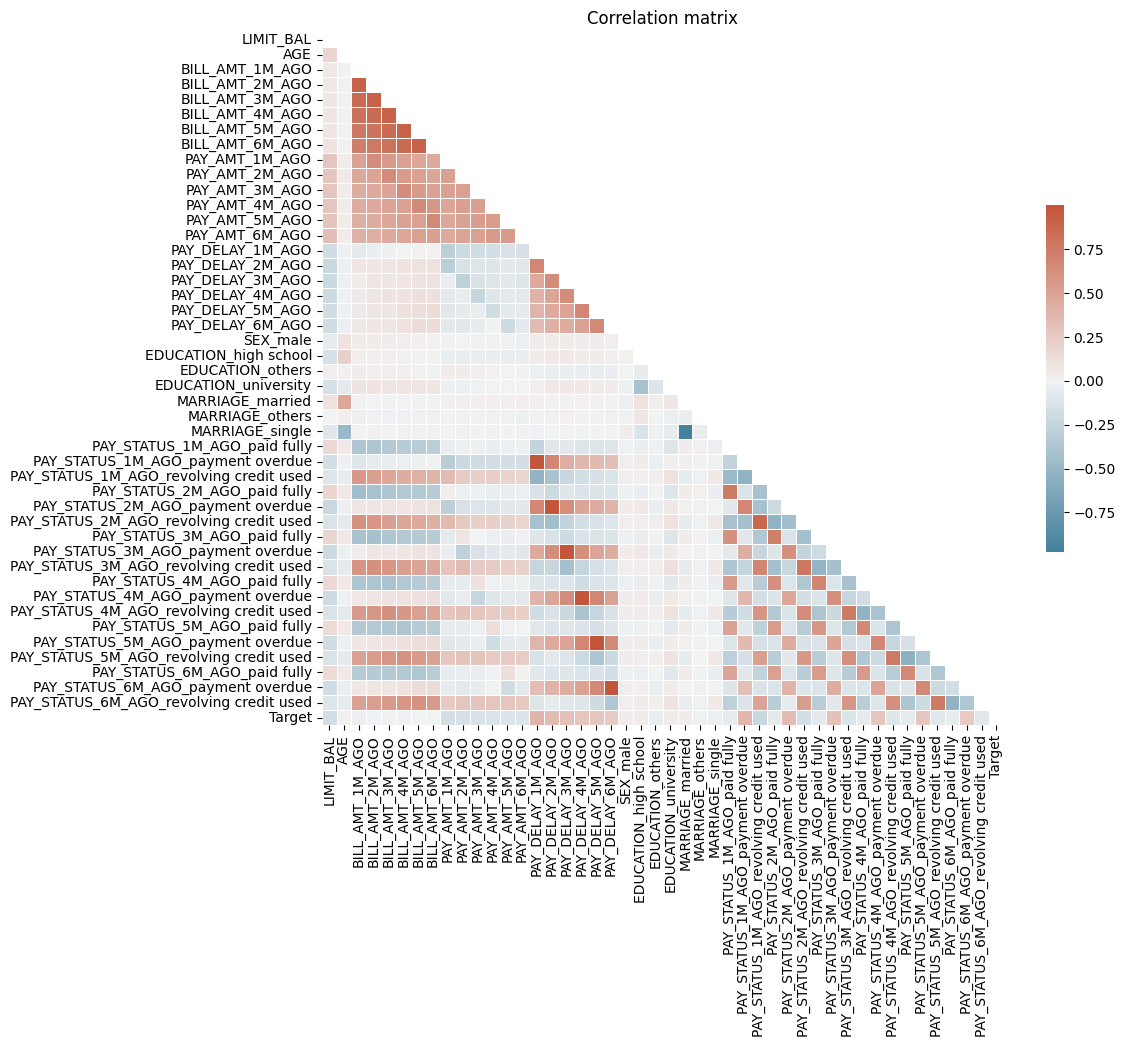

In [ ]:
default_cc_corr = calculate_correlation(default_cc_train_encoded, 'spearman') #, variables_for_correlation)

In [ ]:
abs(default_cc_corr['Target']).sort_values(ascending=False)

Target                                     1.000000
PAY_DELAY_1M_AGO                           0.393065
PAY_STATUS_1M_AGO_payment overdue          0.370192
PAY_DELAY_2M_AGO                           0.344422
PAY_STATUS_2M_AGO_payment overdue          0.343893
PAY_DELAY_3M_AGO                           0.301715
PAY_STATUS_3M_AGO_payment overdue          0.300965
PAY_DELAY_4M_AGO                           0.281333
PAY_STATUS_4M_AGO_payment overdue          0.280206
PAY_DELAY_5M_AGO                           0.272405
PAY_STATUS_5M_AGO_payment overdue          0.271409
PAY_DELAY_6M_AGO                           0.245625
PAY_STATUS_6M_AGO_payment overdue          0.244220
PAY_STATUS_1M_AGO_revolving credit used    0.222784
LIMIT_BAL                                  0.169676
PAY_AMT_1M_AGO                             0.163213
PAY_STATUS_2M_AGO_revolving credit used    0.162810
PAY_AMT_2M_AGO                             0.154690
PAY_AMT_3M_AGO                             0.145890
PAY_AMT_4M_AGO                             0.132393
PAY_AMT_6M_AGO                             0.125179
PAY_STATUS_3M_AGO_revolving credit used    0.124042
PAY_AMT_5M_AGO                             0.119254
PAY_STATUS_4M_AGO_revolving credit used    0.104079
PAY_STATUS_5M_AGO_revolving credit used    0.092145
PAY_STATUS_6M_AGO_revolving credit used    0.088379
PAY_STATUS_3M_AGO_paid fully               0.075515
PAY_STATUS_2M_AGO_paid fully               0.071266
PAY_STATUS_4M_AGO_paid fully               0.069586
PAY_STATUS_5M_AGO_paid fully               0.064468
PAY_STATUS_1M_AGO_paid fully               0.058158
PAY_STATUS_6M_AGO_paid fully               0.054579
EDUCATION_others                           0.047144
EDUCATION_university                       0.038595
SEX_male                                   0.038067
EDUCATION_high school                      0.031188
MARRIAGE_single                            0.029251
MARRIAGE_married                           0.028707
BILL_AMT_1M_AGO                            0.027420
BILL_AMT_2M_AGO                            0.017301
BILL_AMT_3M_AGO                            0.014297
MARRIAGE_others                            0.012623
BILL_AMT_4M_AGO                            0.011205
BILL_AMT_5M_AGO                            0.009867
AGE                                        0.004769
BILL_AMT_6M_AGO                            0.003652
Name: Target, dtype: float64

df columns:  Index(['LIMIT_BAL', 'AGE', 'BILL_AMT_1M_AGO', 'BILL_AMT_2M_AGO',
       'BILL_AMT_3M_AGO', 'BILL_AMT_4M_AGO', 'BILL_AMT_5M_AGO',
       'BILL_AMT_6M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', 'PAY_AMT_3M_AGO',
       'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO',
       'PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO',
       'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO', 'SEX_male',
       'EDUCATION_high school', 'EDUCATION_others', 'EDUCATION_university',
       'MARRIAGE_married', 'MARRIAGE_others', 'MARRIAGE_single',
       'PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue',
       'PAY_STATUS_1M_AGO_revolving credit used',
       'PAY_STATUS_2M_AGO_paid fully', 'PAY_STATUS_2M_AGO_payment overdue',
       'PAY_STATUS_2M_AGO_revolving credit used',
       'PAY_STATUS_3M_AGO_paid fully', 'PAY_STATUS_3M_AGO_payment overdue',
       'PAY_STATUS_3M_AGO_revolving credit used',
       'PAY_STATUS_4M_AGO_paid fully', 'PAY_STATUS_4

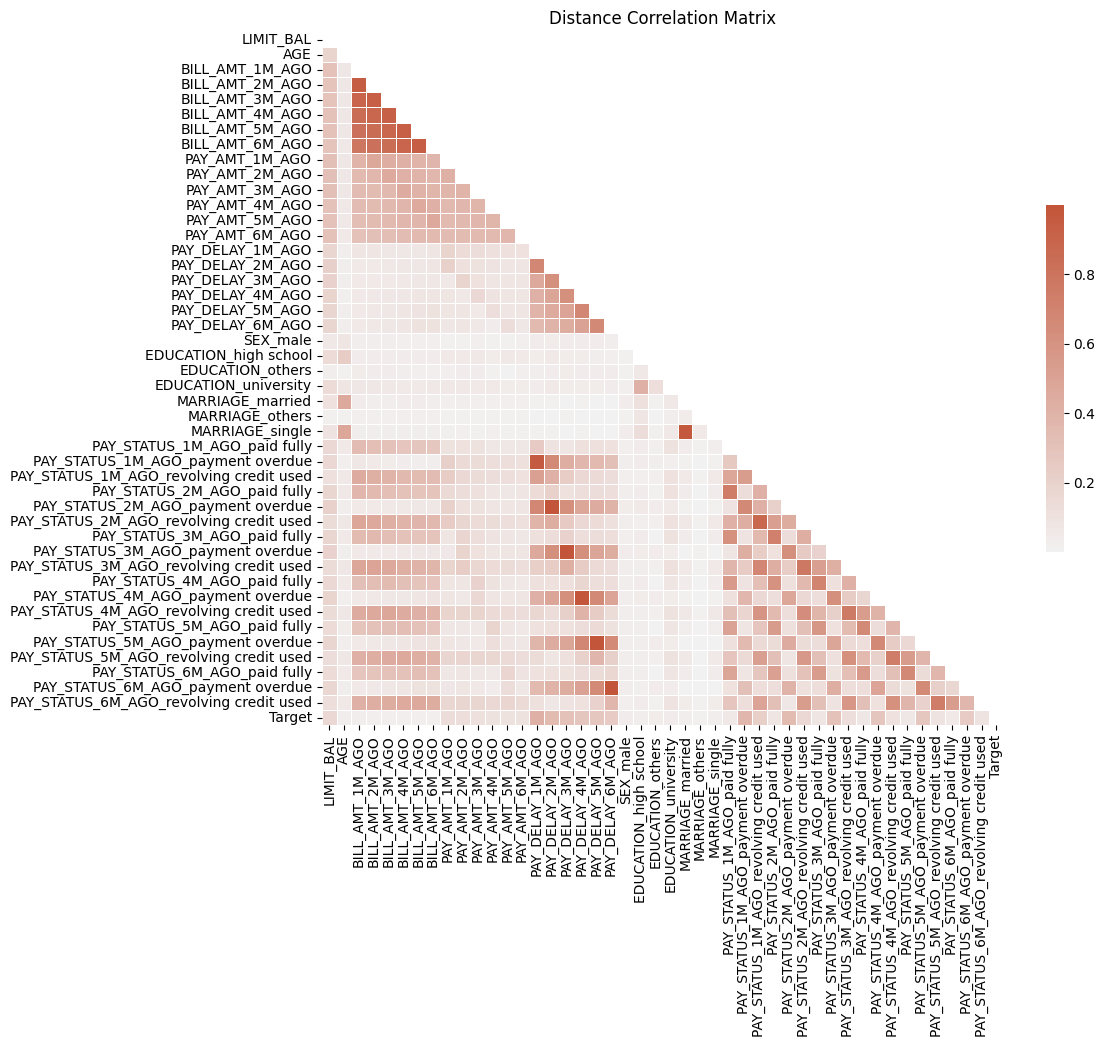

In [ ]:
default_cc_dist_corr = calculate_distance_correlation_matrix(default_cc_train_encoded)

In [ ]:
default_cc_dist_corr['Target'].sort_values(ascending=False)

Target                                     1.000000
PAY_DELAY_1M_AGO                           0.408891
PAY_STATUS_1M_AGO_payment overdue          0.370192
PAY_DELAY_2M_AGO                           0.344593
PAY_STATUS_2M_AGO_payment overdue          0.343893
PAY_DELAY_3M_AGO                           0.301220
PAY_STATUS_3M_AGO_payment overdue          0.300965
PAY_DELAY_4M_AGO                           0.280710
PAY_STATUS_4M_AGO_payment overdue          0.280206
PAY_DELAY_5M_AGO                           0.271967
PAY_STATUS_5M_AGO_payment overdue          0.271409
PAY_DELAY_6M_AGO                           0.245190
PAY_STATUS_6M_AGO_payment overdue          0.244220
PAY_STATUS_1M_AGO_revolving credit used    0.222784
PAY_STATUS_2M_AGO_revolving credit used    0.162810
LIMIT_BAL                                  0.157119
PAY_AMT_1M_AGO                             0.125812
PAY_AMT_2M_AGO                             0.124435
PAY_STATUS_3M_AGO_revolving credit used    0.124042
PAY_AMT_3M_AGO                             0.110408
PAY_STATUS_4M_AGO_revolving credit used    0.104079
PAY_AMT_4M_AGO                             0.100163
PAY_AMT_5M_AGO                             0.095468
PAY_AMT_6M_AGO                             0.094972
PAY_STATUS_5M_AGO_revolving credit used    0.092145
PAY_STATUS_6M_AGO_revolving credit used    0.088379
PAY_STATUS_3M_AGO_paid fully               0.075515
PAY_STATUS_2M_AGO_paid fully               0.071266
PAY_STATUS_4M_AGO_paid fully               0.069586
PAY_STATUS_5M_AGO_paid fully               0.064468
PAY_STATUS_1M_AGO_paid fully               0.058158
PAY_STATUS_6M_AGO_paid fully               0.054579
EDUCATION_others                           0.047144
EDUCATION_university                       0.038595
SEX_male                                   0.038067
EDUCATION_high school                      0.031188
MARRIAGE_single                            0.029251
BILL_AMT_1M_AGO                            0.029235
MARRIAGE_married                           0.028707
AGE                                        0.027026
BILL_AMT_2M_AGO                            0.023847
BILL_AMT_3M_AGO                            0.021764
BILL_AMT_4M_AGO                            0.019649
BILL_AMT_5M_AGO                            0.018590
BILL_AMT_6M_AGO                            0.016757
MARRIAGE_others                            0.012623
Name: Target, dtype: float64

# **Pre-feature selection**
Features with zero-variance will be dropped. The code gives the option for additional removal of extremely weak correlation with the target variable. Nonetheless we will not be using it given that we have non-linear models being tested.

In [ ]:
# Drop columns with zero variance or weak correlation
DROP_WEAK_FEATURES = False
WEAK_THRESHOLD = 0.01

default_cc_zero_variance_columns = identify_zero_variance_columns(default_cc_train_encoded)

if DROP_WEAK_FEATURES:
  default_cc_weak_features = identify_weak_associated_features(
      default_cc_dist_corr, "Target", WEAK_THRESHOLD
  )
else:
  default_cc_weak_features = []

remove_columns = set(default_cc_zero_variance_columns + default_cc_weak_features)
print(remove_columns)

default_cc_train = default_cc_train_encoded.drop(columns=remove_columns)
default_cc_test = default_cc_test_encoded.drop(columns=remove_columns)

Variance of each column:
LIMIT_BAL                                  1.679479e+10
AGE                                        8.546400e+01
BILL_AMT_1M_AGO                            5.408802e+09
BILL_AMT_2M_AGO                            5.080017e+09
BILL_AMT_3M_AGO                            4.863754e+09
BILL_AMT_4M_AGO                            4.158316e+09
BILL_AMT_5M_AGO                            3.711552e+09
BILL_AMT_6M_AGO                            3.550724e+09
PAY_AMT_1M_AGO                             2.731437e+08
PAY_AMT_2M_AGO                             5.902438e+08
PAY_AMT_3M_AGO                             2.969637e+08
PAY_AMT_4M_AGO                             2.534763e+08
PAY_AMT_5M_AGO                             2.287609e+08
PAY_AMT_6M_AGO                             3.138079e+08
PAY_DELAY_1M_AGO                           5.743928e-01
PAY_DELAY_2M_AGO                           6.458192e-01
PAY_DELAY_3M_AGO                           6.318367e-01
PAY_DELAY_4M_AGO       

In [ ]:
default_cc_train.head()

LIMIT_BAL   AGE  BILL_AMT_1M_AGO  BILL_AMT_2M_AGO  BILL_AMT_3M_AGO  \
2667    120000.0  38.0           6856.0          17329.0           2047.0   
25947   430000.0  29.0           2548.0          12020.0           2539.0   
27427   170000.0  32.0           2097.0              0.0              0.0   
7926    200000.0  30.0          15176.0           2693.0           6632.0   
15236    30000.0  26.0          30028.0          26208.0          28804.0   

       BILL_AMT_4M_AGO  BILL_AMT_5M_AGO  BILL_AMT_6M_AGO  PAY_AMT_1M_AGO  \
2667            8568.0           8814.0          17180.0         19600.0   
25947           2250.0              0.0           2580.0         12082.0   
27427              0.0              0.0           6271.0             0.0   
7926               0.0            734.0            584.0          2715.0   
15236          22335.0          17448.0          17448.0             0.0   

       PAY_AMT_2M_AGO  ...  PAY_STATUS_4M_AGO_paid fully  \
2667              0.0  ...                           1.0   
25947          2539.0  ...                           0.0   
27427             0.0  ...                           0.0   
7926           6632.0  ...                           0.0   
15236          3400.0  ...                           0.0   

       PAY_STATUS_4M_AGO_payment overdue  \
2667                                 0.0   
25947                                0.0   
27427                                0.0   
7926                                 0.0   
15236                                1.0   

       PAY_STATUS_4M_AGO_revolving credit used  PAY_STATUS_5M_AGO_paid fully  \
2667                                       0.0                           1.0   
25947                                      0.0                           0.0   
27427                                      0.0                           0.0   
7926                                       0.0                           1.0   
15236                                      0.0                           0.0   

       PAY_STATUS_5M_AGO_payment overdue  \
2667                                 0.0   
25947                                0.0   
27427                                0.0   
7926                                 0.0   
15236                                0.0   

       PAY_STATUS_5M_AGO_revolving credit used  PAY_STATUS_6M_AGO_paid fully  \
2667                                       0.0                           1.0   
25947                                      0.0                           0.0   
27427                                      0.0                           1.0   
7926                                       0.0                           0.0   
15236                                      1.0                           0.0   

       PAY_STATUS_6M_AGO_payment overdue  \
2667                                 0.0   
25947                                0.0   
27427                                0.0   
7926                                 1.0   
15236                                0.0   

       PAY_STATUS_6M_AGO_revolving credit used  Target  
2667                                       0.0     0.0  
25947                                      0.0     0.0  
27427                                      0.0     1.0  
7926                                       0.0     0.0  
15236                                      1.0     1.0  

[5 rows x 46 columns]

In [ ]:
print('Original number of features: ', len(default_cc.columns))
print('Number of features after pre-feature selection: ', len(default_cc_train.columns))

Original number of features:  30
Number of features after pre-feature selection:  46


# **Imbalanced dataset**

In [ ]:
X_train = default_cc_train.drop('Target', axis=1)
y_train = default_cc_train['Target']

X_test = default_cc_test.drop('Target', axis=1)
y_test = default_cc_test['Target']

In [ ]:
target_counts = y_train.value_counts()
target_percentages = y_train.value_counts(normalize=True)

df_target_stats = pd.DataFrame({'Count': target_counts, 'Percentage': target_percentages})
df_target_stats

Count  Percentage
Target                   
0.0     18691    0.778792
1.0      5309    0.221208

Class imbalance will be addressed directly in the models by using class_weight='balanced' or scale_pos_weight = # majority class / # minority class

# **Models optimized for F1-score**

**Usage of feature permutation importance** Instead of calculating the feature importance because  permutation importance is less biased and reflects better the final goal of this use-case which is to measure the capacity of other variables replace the missing one.

**F1-score and Balanced Accuracy as performance metrics:** All the models in this section are trained using F1-score. In the next section, it will be used the Balanced Accuracy. These metrics were selected over the remaining ones because they:
- provide a more holistic view of the performance by considering precision and recall at the same time
- are more resilient to imbalanced datasets
- are among the preferred on several industries like Financial Services where the accuracy it is not enough per se.

**Missing values imputation with median (continuous variables) and mode (categorical variables):**
- simple missing value imputation technique to overcome the fact of some models implementation not handlung missing values natively and with this level up all the models with the same conditions
- median was used instead of the mean because it is more resilient to outliers and guarantees that the imputed value is part of the domain of the variable and in the case of binary variables median and mode coincide

In [ ]:
default_cc_imputation_values_dict = calculate_imputation_values_for_missing(
    default_cc_train
)
default_cc_imputation_values_dict

{'LIMIT_BAL': 140000.0,
 'AGE': 34.0,
 'BILL_AMT_1M_AGO': 22596.0,
 'BILL_AMT_2M_AGO': 21482.5,
 'BILL_AMT_3M_AGO': 20179.5,
 'BILL_AMT_4M_AGO': 19082.0,
 'BILL_AMT_5M_AGO': 18072.0,
 'BILL_AMT_6M_AGO': 17157.5,
 'PAY_AMT_1M_AGO': 2100.0,
 'PAY_AMT_2M_AGO': 2011.0,
 'PAY_AMT_3M_AGO': 1806.0,
 'PAY_AMT_4M_AGO': 1500.0,
 'PAY_AMT_5M_AGO': 1500.0,
 'PAY_AMT_6M_AGO': 1500.0,
 'PAY_DELAY_1M_AGO': 0.0,
 'PAY_DELAY_2M_AGO': 0.0,
 'PAY_DELAY_3M_AGO': 0.0,
 'PAY_DELAY_4M_AGO': 0.0,
 'PAY_DELAY_5M_AGO': 0.0,
 'PAY_DELAY_6M_AGO': 0.0,
 'SEX_male': 0.0,
 'EDUCATION_high school': 0.0,
 'EDUCATION_others': 0.0,
 'EDUCATION_university': 0.0,
 'MARRIAGE_married': 0.0,
 'MARRIAGE_others': 0.0,
 'MARRIAGE_single': 1.0,
 'PAY_STATUS_1M_AGO_paid fully': 0.0,
 'PAY_STATUS_1M_AGO_payment overdue': 0.0,
 'PAY_STATUS_1M_AGO_revolving credit used': 0.0,
 'PAY_STATUS_2M_AGO_paid fully': 0.0,
 'PAY_STATUS_2M_AGO_payment overdue': 0.0,
 'PAY_STATUS_2M_AGO_revolving credit used': 1.0,
 'PAY_STATUS_3M_AGO_paid full

In [ ]:
default_cc_cat_vars = [col for col in X_train.columns if X_train[col].nunique() <= 2]
default_cc_cat_vars

['SEX_male',
 'EDUCATION_high school',
 'EDUCATION_others',
 'EDUCATION_university',
 'MARRIAGE_married',
 'MARRIAGE_others',
 'MARRIAGE_single',
 'PAY_STATUS_1M_AGO_paid fully',
 'PAY_STATUS_1M_AGO_payment overdue',
 'PAY_STATUS_1M_AGO_revolving credit used',
 'PAY_STATUS_2M_AGO_paid fully',
 'PAY_STATUS_2M_AGO_payment overdue',
 'PAY_STATUS_2M_AGO_revolving credit used',
 'PAY_STATUS_3M_AGO_paid fully',
 'PAY_STATUS_3M_AGO_payment overdue',
 'PAY_STATUS_3M_AGO_revolving credit used',
 'PAY_STATUS_4M_AGO_paid fully',
 'PAY_STATUS_4M_AGO_payment overdue',
 'PAY_STATUS_4M_AGO_revolving credit used',
 'PAY_STATUS_5M_AGO_paid fully',
 'PAY_STATUS_5M_AGO_payment overdue',
 'PAY_STATUS_5M_AGO_revolving credit used',
 'PAY_STATUS_6M_AGO_paid fully',
 'PAY_STATUS_6M_AGO_payment overdue',
 'PAY_STATUS_6M_AGO_revolving credit used']

In [ ]:
# Maximum number of original features (after feature engineering) to be imputed
NUM_FEAT = 20

##**Decision tree**

**Cross-validation (3,3) for large datasets and (5,5) for smaller datasets:**
- due to the unpractical runtime of some of the models, the cross-validaton set up on large datasets consists in a nested-cv with 3-fold in both inner and outer CV. The number of folds is increased to (5,5) in smaller datsets.
- this assumption is reasonable given that in larger datasets there is a higher chance of the holdout samples being big enough to be more representative and less prone to biases. So a smaller number of folds can be assummed
- on the other hand, in smaller datasets it is crucial to reduce the variance and any potential misrepresentativeness of a specific validation set, so it is requires a larger number of folds to make a more efficient use of the data available.


In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  dt_param_grid = {
      'max_depth': [2, 3, 4, 5, None],
      'min_samples_split': [0.2, 0.1, 0.05, 0.01, 0.005, 0.001, 2],  # last option reflects num of samples instead of proportion
      'min_samples_leaf': [0.1, 0.05, 0.01, 0.005, 0.001, 1]  # last option reflects num of samples instead of proportion
  }
else:
  # best model
  dt_param_grid = {
    'max_depth': [5],
    'min_samples_split': [0.01],
    'min_samples_leaf': [0.005]
}

dt_classifier = DecisionTreeClassifier(class_weight='balanced', random_state=RANDOM_STATE)
dt_grid_search, dt_best_model, dt_best_params = hyperparameter_tuning(
    dt_classifier, dt_param_grid, 3, 3, 'f1', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-18 10:11:58.941261

Nested Cross-validation Results:
Individual scores: [0.5270793  0.53771552 0.51861846]
Average nested CV score: 0.528 (+/- 0.016)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'max_depth': 5, 'min_samples_leaf': 0.005, 'min_samples_split': 0.01}

Best Model Performance:
Best CV score: 0.528
2025-01-18 10:12:01.568072

Execution time: 0.04 minutes



```
Starting hyperparameter tuning at: 2025-01-17 16:37:25.126900

Nested Cross-validation Results:
Individual scores: [0.52109065 0.53381575 0.52027586]
Average nested CV score: 0.525 (+/- 0.012)

Fitting final model on entire dataset...
Fitting 3 folds for each of 210 candidates, totalling 630 fits
Best parameters: {'max_depth': 5, 'min_samples_leaf': 0.005, 'min_samples_split': 0.01}

Best Model Performance:
Best CV score: 0.528
2025-01-17 16:38:11.834633

Execution time: 0.78 minutes

```



In [ ]:
# dt_grid_search.cv_results_

In [ ]:
dt_classifier, dt_train_pred, dt_test_pred = apply_model(dt_best_model, X_train, y_train, X_test, y_test)
dt_feat_permut_import_df = analyze_feat_permut_import(dt_classifier, X_train, y_train, scoring_metric="f1")
dt_feat_permut_import_df[dt_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
14                   PAY_DELAY_1M_AGO    0.127392  0.003686
37  PAY_STATUS_4M_AGO_payment overdue    0.024691  0.001640
15                   PAY_DELAY_2M_AGO    0.018483  0.000340
40  PAY_STATUS_5M_AGO_payment overdue    0.014220  0.001709
36       PAY_STATUS_4M_AGO_paid fully    0.012348  0.001086
8                      PAY_AMT_1M_AGO    0.010723  0.002842
9                      PAY_AMT_2M_AGO    0.007611  0.001651
0                           LIMIT_BAL    0.004212  0.000705
1                                 AGE    0.001276  0.000740
6                     BILL_AMT_5M_AGO    0.000669  0.000190

**Note:** feature permutation importance values do not sum up to 100% because they represent the drop in model performance when each feature is permuted, and they are not normalized.

Values can be negative if permuting an unimportant feature improves model performance.

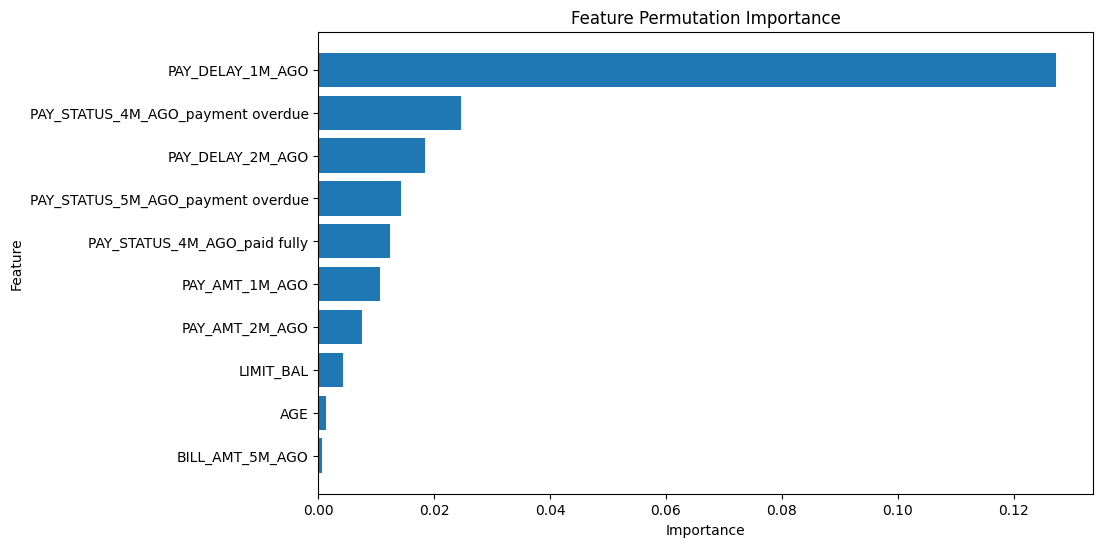

In [ ]:
plot_feat_permut_importance(dt_feat_permut_import_df)

In [ ]:
dt_perf, dt_orig_missing, dt_missing = measure_performance_decline(
    X_train, X_test, y_test, dt_classifier, dt_feat_permut_import_df,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family
)


--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_STATUS_4M_AGO_payment overdue
Removing related features:  ['PAY_STATUS_4M_AGO_paid fully', 'PAY_STATUS_4M_AGO_payment overdue', 'PAY_STATUS_4M_AGO_revolving credit used']
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_4M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_2M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_4M_AGO', 'PAY_DELAY_2M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_STATUS_5M_AGO_payment overdue
Removing related features:  ['PAY_STATUS_5M_AGO_paid fully', 'PAY_STATUS_5M_AGO_payment overdue', 'PAY_STATUS_5M_AGO_revolving credit used']
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_4M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_STATUS_5M_AGO']

--- NEW ITERATION ---

--- NEW ITERATION ---
Removing feature:  PAY_AMT_1M_AGO
Original feat removed so far:  ['PAY

In [ ]:
dt_orig_missing

['PAY_DELAY_1M_AGO',
 'PAY_STATUS_4M_AGO',
 'PAY_DELAY_2M_AGO',
 'PAY_STATUS_5M_AGO',
 'PAY_AMT_1M_AGO',
 'PAY_AMT_2M_AGO',
 'LIMIT_BAL',
 'AGE',
 'BILL_AMT_5M_AGO',
 'PAY_STATUS_1M_AGO',
 'PAY_STATUS_2M_AGO',
 'PAY_STATUS_3M_AGO',
 'PAY_STATUS_6M_AGO',
 'MARRIAGE',
 'EDUCATION',
 'BILL_AMT_2M_AGO',
 'PAY_AMT_3M_AGO',
 'BILL_AMT_1M_AGO',
 'PAY_AMT_6M_AGO',
 'PAY_AMT_5M_AGO']

In [ ]:
len(dt_missing)

36

In [ ]:
dt_perf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0   735  3882  791   592      48.17   55.39        83.07     76.95     51.52   
1   450  4220  453   877      49.83   33.91        90.31     77.83     40.36   
2   280  4392  281  1047      49.91   21.10        93.99     77.87     29.66   
3   151  4542  131  1176      53.55   11.38        97.20     78.22     18.77   
4     0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
5     0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
6     0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
7     0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
8     0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
9     0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
10    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
11    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
12    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
13    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
14    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
15    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
16    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
17    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
18    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
19    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
20    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   

    balanced_accuracy  num_feat_missing  \
0               69.23                 0   
1               62.11                 1   
2               57.54                 2   
3               54.29                 3   
4               50.00                 4   
5               50.00                 5   
6               50.00                 6   
7               50.00                 7   
8               50.00                 8   
9               50.00                 9   
10              50.00                10   
11              50.00                11   
12              50.00                12   
13              50.00                13   
14              50.00                14   
15              50.00                15   
16              50.00                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_4M_AGO_paid f...  
3   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_4M_AGO_paid f...  
4   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_4M_AGO_paid f...  
5   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_4M_AGO_paid f...  
6   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_4M_AGO_paid f...  
7   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_4M_AGO_paid f...  
8   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_4M_AGO_paid f...  
9   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_4M_AGO_paid f...  
10  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_4M_AGO_paid f...  
11  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_4M_AGO_paid f...  
12  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_4M_AGO_paid f...  
13  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_4M_AGO_paid f...  
14  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_4M_AGO_paid f...  
15  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_4M_AGO_paid f...  
16  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_4M_AGO_paid f...  
17  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_4M_AGO_paid f...  
18  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_4M_AGO_paid f...  
19  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_4M_AGO_paid f...  
20  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_4M_AGO_paid f...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

dt_perf_mf, dt_orig_missing_mf, dt_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, dt_classifier, dt_feat_permut_import_df,
    imputation_dict=None, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 12:49:54.573747

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Nr. columns with nan:  1
Numerical columns:  ['LIMIT_BAL', 'AGE', 'BILL_AMT_1M_AGO', 'BILL_AMT_2M_AGO', 'BILL_AMT_3M_AGO', 'BILL_AMT_4M_AGO', 'BILL_AMT_5M_AGO', 'BILL_AMT_6M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO']
Categorical columns:  ['SEX_male', 'EDUCATION_high school', 'EDUCATION_others', 'EDUCATION_university', 'MARRIAGE_married', 'MARRIAGE_others', 'MARRIAGE_single', 'PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used', 'PAY_STATUS_2M_AGO_paid fully', 'PAY_STATUS_2M_AGO_payment overdue', 'PAY_STATUS_2M_AGO_revolving credit used', 'PAY_STATUS_3M_AGO_paid fully', 'PAY_STATUS_3M_AGO_payment overdue', 'PAY_STATUS_3M_AGO_revolving credit used', 'PAY_STA

In [ ]:
dt_perf_mf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0   735  3882  791   592      48.17   55.39        83.07     76.95     51.52   
1   616  3967  706   711      46.60   46.42        84.89     76.38     46.51   
2   566  4022  651   761      46.51   42.65        86.07     76.47     44.50   
3   276  4306  367  1051      42.92   20.80        92.15     76.37     28.02   
4   181  4385  288  1146      38.59   13.64        93.84     76.10     20.16   
5   112  4470  203  1215      35.56    8.44        95.66     76.37     13.64   
6   107  4513  160  1220      40.07    8.06        96.58     77.00     13.43   
7    76  4545  128  1251      37.25    5.73        97.26     77.02      9.93   
8    59  4601   72  1268      45.04    4.45        98.46     77.67      8.09   
9    56  4599   74  1271      43.08    4.22        98.42     77.58      7.69   
10   56  4599   74  1271      43.08    4.22        98.42     77.58      7.69   
11   56  4599   74  1271      43.08    4.22        98.42     77.58      7.69   
12   56  4599   74  1271      43.08    4.22        98.42     77.58      7.69   
13   56  4599   74  1271      43.08    4.22        98.42     77.58      7.69   
14   56  4599   74  1271      43.08    4.22        98.42     77.58      7.69   
15   56  4599   74  1271      43.08    4.22        98.42     77.58      7.69   
16  118  4472  201  1209      36.99    8.89        95.70     76.50     14.34   
17   39  4622   51  1288      43.33    2.94        98.91     77.68      5.50   
18   39  4627   46  1288      45.88    2.94        99.02     77.77      5.52   
19   32  4630   43  1295      42.67    2.41        99.08     77.70      4.56   
20   30  4635   38  1297      44.12    2.26        99.19     77.75      4.30   

    balanced_accuracy  num_feat_missing  \
0               69.23                 0   
1               65.66                 1   
2               64.36                 2   
3               56.47                 3   
4               53.74                 4   
5               52.05                 5   
6               52.32                 6   
7               51.49                 7   
8               51.45                 8   
9               51.32                 9   
10              51.32                10   
11              51.32                11   
12              51.32                12   
13              51.32                13   
14              51.32                14   
15              51.32                15   
16              52.30                16   
17              50.92                17   
18              50.98                18   
19              50.75                19   
20              50.72                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_4M_AGO_paid f...  
3   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_4M_AGO_paid f...  
4   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_4M_AGO_paid f...  
5   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_4M_AGO_paid f...  
6   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_4M_AGO_paid f...  
7   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_4M_AGO_paid f...  
8   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_4M_AGO_paid f...  
9   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_4M_AGO_paid f...  
10  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_4M_AGO_paid f...  
11  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_4M_AGO_paid f...  
12  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_4M_AGO_paid f...  
13  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_4M_AGO_paid f...  
14  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_4M_AGO_paid f...  
15  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_4M_AGO_paid f...  
16  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_4M_AGO_paid f...  
17  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_4M_AGO_paid f...  
18  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_4M_AGO_paid f...  
19  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_4M_AGO_paid f...  
20  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_4M_AGO_paid f...

In [ ]:
dt_perf_temp, dt_orig_missing_temp, dt_missing_temp = measure_temporal_performance_decline(
    X_train, X_test, y_test, dt_classifier, dt_feat_permut_import_df,
    default_cc_timeline_vars_family,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family, log_info=True
)


--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  45
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_payment overdue
Removing related features:  []
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Columns with zero variance, i.e. imputed:
                                    feature  variance
2                           BILL_AMT_1M_AGO       0.0
8                            PAY_AMT_1M_AGO       0.0
14                         PAY_DELAY_1M_

In [ ]:
dt_perf_temp

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0  735  3882  791   592      48.17   55.39        83.07     76.95     51.52   
1  450  4220  453   877      49.83   33.91        90.31     77.83     40.36   
2  280  4392  281  1047      49.91   21.10        93.99     77.87     29.66   
3    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
4    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
5    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
6    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
7    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   

   balanced_accuracy  num_feat_missing  \
0              69.23                 0   
1              62.11                 4   
2              57.54                 8   
3              50.00                12   
4              50.00                16   
5              50.00                17   
6              50.00                18   
7              50.00                22   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
7  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

dt_perf_temp_mf, dt_orig_missing_temp_mf, dt_missing_temp_mf = measure_temporal_performance_decline(
    X_train, X_test, y_test, dt_classifier, dt_feat_permut_import_df,
    default_cc_timeline_vars_family, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars, log_info=True
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 12:56:37.847464

--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  45
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_payment overdue
Removing related features:  []
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Nr. columns with nan:  6
Numerical columns:  ['LIMIT_BAL', 'AGE', 'BILL_AMT_1M_AGO', 'BILL_AMT_2M_AGO', 'BILL_AMT_3M_AGO', 'BILL_AMT_4M_AGO', 'BILL_AMT_5M_AGO', 'BILL_AMT_6M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', '

In [ ]:
dt_perf_temp_mf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0  735  3882  791   592      48.17   55.39        83.07     76.95     51.52   
1  556  4122  551   771      50.23   41.90        88.21     77.97     45.69   
2  509  4204  469   818      52.04   38.36        89.96     78.55     44.16   
3  177  4546  127  1150      58.22   13.34        97.28     78.72     21.70   
4    8  4658   15  1319      34.78    0.60        99.68     77.77      1.19   
5    8  4660   13  1319      38.10    0.60        99.72     77.80      1.19   
6   11  4657   16  1316      40.74    0.83        99.66     77.80      1.62   
7   86  4602   71  1241      54.78    6.48        98.48     78.13     11.59   

   balanced_accuracy  num_feat_missing  \
0              69.23                 0   
1              65.05                 4   
2              64.16                 8   
3              55.31                12   
4              50.14                16   
5              50.16                17   
6              50.24                18   
7              52.48                22   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
7  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

## **Random Forests**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  rf_param_grid = {
      'n_estimators': [100, 200, 300],
      'max_features': ['sqrt', 0.5, 1.0],
      'max_depth': [3, 5, None],
      'min_samples_split': [0.01, 0.005, 0.001, 2],
      'min_samples_leaf': [0.01, 0.005, 0.001, 1]
  }
else:
  #best model
  rf_param_grid = {
      'n_estimators': [300],
      'max_features': ['sqrt'],
      'min_samples_split': [0.005],
      'min_samples_leaf': [1],
      'max_depth': [None]
  }

rf_classifier = RandomForestClassifier(class_weight='balanced', random_state=RANDOM_STATE)
rf_grid_search, rf_best_model, rf_best_params = hyperparameter_tuning(
    rf_classifier, rf_param_grid, 3, 3, 'f1', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-18 10:18:28.183992

Nested Cross-validation Results:
Individual scores: [0.55780501 0.5503178  0.53671421]
Average nested CV score: 0.548 (+/- 0.017)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 0.005, 'n_estimators': 300}

Best Model Performance:
Best CV score: 0.548
2025-01-18 10:19:09.417261

Execution time: 0.69 minutes


```
Starting hyperparameter tuning at: 2025-01-17 21:41:51.387924

Nested Cross-validation Results:
Individual scores: [0.55780501 0.5448047  0.53693694]
Average nested CV score: 0.547 (+/- 0.017)

Fitting final model on entire dataset...
Fitting 3 folds for each of 432 candidates, totalling 1296 fits
Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 0.005, 'n_estimators': 300}

Best Model Performance:
Best CV score: 0.548
2025-01-17 23:33:46.385108

Execution time: 111.92 minutes
```

In [ ]:
rf_classifier, rf_train_pred, rf_test_pred = apply_model(rf_best_model, X_train, y_train, X_test, y_test)
rf_feat_permut_import_df = analyze_feat_permut_import(rf_classifier, X_train, y_train, scoring_metric="f1")
rf_feat_permut_import_df[rf_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
14                         PAY_DELAY_1M_AGO    0.020326  0.001092
2                           BILL_AMT_1M_AGO    0.020282  0.000701
10                           PAY_AMT_3M_AGO    0.019347  0.001193
8                            PAY_AMT_1M_AGO    0.017298  0.001342
9                            PAY_AMT_2M_AGO    0.017170  0.000807
0                                 LIMIT_BAL    0.015057  0.001299
6                           BILL_AMT_5M_AGO    0.014970  0.001140
11                           PAY_AMT_4M_AGO    0.014767  0.000994
7                           BILL_AMT_6M_AGO    0.014515  0.000546
13                           PAY_AMT_6M_AGO    0.013733  0.002101
3                           BILL_AMT_2M_AGO    0.011681  0.000622
12                           PAY_AMT_5M_AGO    0.011010  0.001082
5                           BILL_AMT_4M_AGO    0.009080  0.000658
4                           BILL_AMT_3M_AGO    0.008976  0.000854
1                                       AGE    0.006774  0.000454
29  PAY_STATUS_1M_AGO_revolving credit used    0.004310  0.000491
33             PAY_STATUS_3M_AGO_paid fully    0.002608  0.000344
42             PAY_STATUS_6M_AGO_paid fully    0.002425  0.000418
16                         PAY_DELAY_3M_AGO    0.002160  0.000416
34        PAY_STATUS_3M_AGO_payment overdue    0.002108  0.000753
44  PAY_STATUS_6M_AGO_revolving credit used    0.002065  0.000670
23                     EDUCATION_university    0.001908  0.000408
20                                 SEX_male    0.001767  0.000623
36             PAY_STATUS_4M_AGO_paid fully    0.001634  0.000497
35  PAY_STATUS_3M_AGO_revolving credit used    0.001391  0.000276
22                         EDUCATION_others    0.001103  0.000240
18                         PAY_DELAY_5M_AGO    0.001096  0.000501
32  PAY_STATUS_2M_AGO_revolving credit used    0.001069  0.000447
27             PAY_STATUS_1M_AGO_paid fully    0.001052  0.000511
24                         MARRIAGE_married    0.001004  0.000190
30             PAY_STATUS_2M_AGO_paid fully    0.000875  0.000138
21                    EDUCATION_high school    0.000733  0.000204
26                          MARRIAGE_single    0.000719  0.000315
39             PAY_STATUS_5M_AGO_paid fully    0.000627  0.000353
40        PAY_STATUS_5M_AGO_payment overdue    0.000619  0.000225
41  PAY_STATUS_5M_AGO_revolving credit used    0.000556  0.000452
43        PAY_STATUS_6M_AGO_payment overdue    0.000368  0.000298
19                         PAY_DELAY_6M_AGO    0.000250  0.000239
25                          MARRIAGE_others    0.000120  0.000000
38  PAY_STATUS_4M_AGO_revolving credit used    0.000054  0.000512
31        PAY_STATUS_2M_AGO_payment overdue   -0.000451  0.000877
15                         PAY_DELAY_2M_AGO   -0.000515  0.001108
17                         PAY_DELAY_4M_AGO   -0.000525  0.000806
37        PAY_STATUS_4M_AGO_payment overdue   -0.000619  0.000444
28        PAY_STATUS_1M_AGO_payment overdue   -0.002785  0.001062

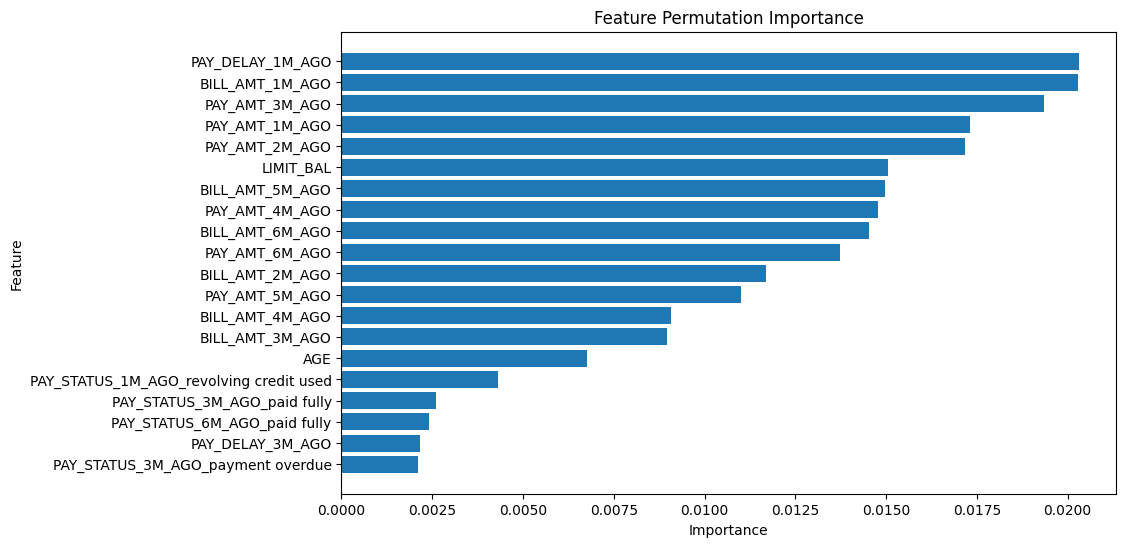

In [ ]:
plot_feat_permut_importance(rf_feat_permut_import_df)

In [ ]:
rf_perf, rf_orig_missing, rf_missing = measure_performance_decline(
    X_train, X_test, y_test, rf_classifier, rf_feat_permut_import_df,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family
)


--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO']

--- NEW ITERATION ---
Removing feature:  BILL_AMT_1M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_AMT_3M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_AMT_3M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_AMT_1M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_1M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_AMT_2M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO']

--- NEW ITERATION ---
Removing feature:  LIMIT_BAL
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', 'LIMIT_BAL']

--- NEW ITERATION ---
Removing feature:  BILL_AMT_5M_AGO
Original feat remove

In [ ]:
rf_perf

tp    tn   fp   fn  precision  recall  specificity  accuracy  f1_score  \
0   780  3861  812  547      48.99   58.78        82.62     77.35     53.44   
1   710  3937  736  617      49.10   53.50        84.25     77.45     51.21   
2   616  4113  560  711      52.38   46.42        88.02     78.82     49.22   
3   591  4157  516  736      53.39   44.54        88.96     79.13     48.56   
4   588  4162  511  739      53.50   44.31        89.06     79.17     48.47   
5   590  4161  512  737      53.54   44.46        89.04     79.18     48.58   
6   571  4168  505  756      53.07   43.03        89.19     78.98     47.52   
7   575  4175  498  752      53.59   43.33        89.34     79.17     47.92   
8   584  4168  505  743      53.63   44.01        89.19     79.20     48.34   
9   577  4168  505  750      53.33   43.48        89.19     79.08     47.90   
10  579  4168  505  748      53.41   43.63        89.19     79.12     48.03   
11  580  4174  499  747      53.75   43.71        89.32     79.23     48.21   
12  567  4186  487  760      53.80   42.73        89.58     79.22     47.63   
13  578  4181  492  749      54.02   43.56        89.47     79.32     48.23   
14  579  4172  501  748      53.61   43.63        89.28     79.18     48.11   
15  580  4173  500  747      53.70   43.71        89.30     79.22     48.19   
16  473  4252  421  854      52.91   35.64        90.99     78.75     42.59   
17  459  4283  390  868      54.06   34.59        91.65     79.03     42.19   
18  430  4327  346  897      55.41   32.40        92.60     79.28     40.89   
19  352  4410  263  975      57.24   26.53        94.37     79.37     36.25   
20  360  4406  267  967      57.42   27.13        94.29     79.43     36.85   

    balanced_accuracy  num_feat_missing  \
0               70.70                 0   
1               68.88                 1   
2               67.22                 2   
3               66.75                 3   
4               66.69                 4   
5               66.75                 5   
6               66.11                 6   
7               66.34                 7   
8               66.60                 8   
9               66.34                 9   
10              66.41                10   
11              66.51                11   
12              66.15                12   
13              66.51                13   
14              66.46                14   
15              66.50                15   
16              63.32                16   
17              63.12                17   
18              62.50                18   
19              60.45                19   
20              60.71                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2     ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO'] imputed  
3   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
4   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
5   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
6   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
7   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
8   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
9   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
10  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
11  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
12  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
13  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
14  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
15  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
16  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
17  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
18  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
19  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
20  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

rf_perf_mf, rf_orig_missing_mf, rf_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, rf_classifier, rf_feat_permut_import_df,
    imputation_dict=None, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 12:58:53.643819

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Nr. columns with nan:  1
Numerical columns:  ['LIMIT_BAL', 'AGE', 'BILL_AMT_1M_AGO', 'BILL_AMT_2M_AGO', 'BILL_AMT_3M_AGO', 'BILL_AMT_4M_AGO', 'BILL_AMT_5M_AGO', 'BILL_AMT_6M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO']
Categorical columns:  ['SEX_male', 'EDUCATION_high school', 'EDUCATION_others', 'EDUCATION_university', 'MARRIAGE_married', 'MARRIAGE_others', 'MARRIAGE_single', 'PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used', 'PAY_STATUS_2M_AGO_paid fully', 'PAY_STATUS_2M_AGO_payment overdue', 'PAY_STATUS_2M_AGO_revolving credit used', 'PAY_STATUS_3M_AGO_paid fully', 'PAY_STATUS_3M_AGO_payment overdue', 'PAY_STATUS_3M_AGO_revolving credit used', 'PAY_STA

In [ ]:
rf_perf_mf

tp    tn   fp   fn  precision  recall  specificity  accuracy  f1_score  \
0   780  3861  812  547      48.99   58.78        82.62     77.35     53.44   
1   727  3894  779  600      48.27   54.79        83.33     77.02     51.32   
2   690  4005  668  637      50.81   52.00        85.71     78.25     51.40   
3   655  4037  636  672      50.74   49.36        86.39     78.20     50.04   
4   639  4069  604  688      51.41   48.15        87.07     78.47     49.73   
5   630  4090  583  697      51.94   47.48        87.52     78.67     49.61   
6   606  4109  564  721      51.79   45.67        87.93     78.58     48.54   
7   600  4116  557  727      51.86   45.21        88.08     78.60     48.31   
8   594  4134  539  733      52.43   44.76        88.47     78.80     48.29   
9   598  4142  531  729      52.97   45.06        88.64     79.00     48.70   
10  580  4163  510  747      53.21   43.71        89.09     79.05     47.99   
11  563  4196  477  764      54.13   42.43        89.79     79.32     47.57   
12  563  4197  476  764      54.19   42.43        89.81     79.33     47.59   
13  567  4188  485  760      53.90   42.73        89.62     79.25     47.67   
14  589  4139  534  738      52.45   44.39        88.57     78.80     48.08   
15  585  4147  526  742      52.66   44.08        88.74     78.87     47.99   
16  475  4243  430  852      52.49   35.80        90.80     78.63     42.56   
17  475  4236  437  852      52.08   35.80        90.65     78.52     42.43   
18  461  4271  402  866      53.42   34.74        91.40     78.87     42.10   
19  397  4362  311  930      56.07   29.92        93.34     79.32     39.02   
20  418  4334  339  909      55.22   31.50        92.75     79.20     40.12   

    balanced_accuracy  num_feat_missing  \
0               70.70                 0   
1               69.06                 1   
2               68.85                 2   
3               67.87                 3   
4               67.61                 4   
5               67.50                 5   
6               66.80                 6   
7               66.65                 7   
8               66.61                 8   
9               66.85                 9   
10              66.40                10   
11              66.11                11   
12              66.12                12   
13              66.17                13   
14              66.48                14   
15              66.41                15   
16              63.30                16   
17              63.22                17   
18              63.07                18   
19              61.63                19   
20              62.12                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2     ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO'] imputed  
3   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
4   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
5   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
6   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
7   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
8   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
9   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
10  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
11  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
12  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
13  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
14  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
15  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
16  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
17  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
18  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
19  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
20  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...

In [ ]:
rf_perf_temp, rf_orig_missing_temp, rf_missing_temp = measure_temporal_performance_decline(
    X_train, X_test, y_test, rf_classifier, rf_feat_permut_import_df,
    default_cc_timeline_vars_family,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family, log_info=True
)


--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  45
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_payment overdue
Removing related features:  []
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Columns with zero variance, i.e. imputed:
                                    feature  variance
2                           BILL_AMT_1M_AGO       0.0
8                            PAY_AMT_1M_AGO       0.0
14                         PAY_DELAY_1M_

In [ ]:
rf_perf_temp

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0  780  3861  812   547      48.99   58.78        82.62     77.35     53.44   
1  528  4155  518   799      50.48   39.79        88.92     78.05     44.50   
2  448  4278  395   879      53.14   33.76        91.55     78.77     41.29   
3  313  4437  236  1014      57.01   23.59        94.95     79.17     33.37   
4  298  4452  221  1029      57.42   22.46        95.27     79.17     32.29   
5  191  4562  111  1136      63.25   14.39        97.62     79.22     23.45   
6    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   

   balanced_accuracy  num_feat_missing  \
0              70.70                 0   
1              64.35                 4   
2              62.65                 8   
3              59.27                12   
4              58.86                13   
5              56.01                17   
6              50.00                21   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

rf_perf_temp_mf, rf_orig_missing_temp_mf, rf_missing_temp_mf = measure_temporal_performance_decline(
    X_train, X_test, y_test, rf_classifier, rf_feat_permut_import_df,
    default_cc_timeline_vars_family, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars, log_info=True
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 13:05:18.824953

--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  45
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_payment overdue
Removing related features:  []
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Nr. columns with nan:  6
Numerical columns:  ['LIMIT_BAL', 'AGE', 'BILL_AMT_1M_AGO', 'BILL_AMT_2M_AGO', 'BILL_AMT_3M_AGO', 'BILL_AMT_4M_AGO', 'BILL_AMT_5M_AGO', 'BILL_AMT_6M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', '

In [ ]:
rf_perf_temp_mf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0  780  3861  812   547      48.99   58.78        82.62     77.35     53.44   
1  570  4072  601   757      48.68   42.95        87.14     77.37     45.64   
2  535  4145  528   792      50.33   40.32        88.70     78.00     44.77   
3  313  4420  253  1014      55.30   23.59        94.59     78.88     33.07   
4  311  4417  256  1016      54.85   23.44        94.52     78.80     32.84   
5  249  4469  204  1078      54.97   18.76        95.63     78.63     27.98   
6   29  4653   20  1298      59.18    2.19        99.57     78.03      4.22   

   balanced_accuracy  num_feat_missing  \
0              70.70                 0   
1              65.05                 4   
2              64.51                 8   
3              59.09                12   
4              58.98                13   
5              57.20                17   
6              50.88                21   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

## **Gradient-Boosted Trees**

Instead of class_weight='balanced', GBT and XGBoost recommends the use of scale_pos_weight = # majority class samples / # minority class samples

- https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html
- https://xgboost.readthedocs.io/en/latest/parameter.html

In [ ]:
# scale_pos_weight value
ratio_majority_minority = y_train[y_train==0].count()/y_train[y_train==1].count()
ratio_majority_minority

3.520625353173856

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  gbt_param_grid = {
      'n_estimators': [100, 200, 300],
      'max_depth': [2, 3, 4, 5, None],  # literature recommends weak learners
      'min_child_samples': [100, 25, 1],
      'min_split_gain': [1, 0.5, 0.0],
      'reg_lambda': [10.0, 5.0, 1.0, 0.5, 0.0]
  }
else:
  # best model
  gbt_param_grid = {
      'n_estimators': [100],
      'max_depth': [3],
      'min_child_samples': [100],
      'min_split_gain': [0.0],
      'reg_lambda': [5.0]
  }

gbt_classifier = LGBMClassifier(
    objective= "binary",
    scale_pos_weight=ratio_majority_minority, random_state=RANDOM_STATE,
    verbose=-1, n_jobs=1
)
gbt_grid_search, gbt_best_model, gbt_best_params = hyperparameter_tuning(
    gbt_classifier, gbt_param_grid, 3, 3, 'f1', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-18 10:26:25.990687

Nested Cross-validation Results:
Individual scores: [0.55239015 0.54677302 0.53266332]
Average nested CV score: 0.544 (+/- 0.017)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'max_depth': 3, 'min_child_samples': 100, 'min_split_gain': 0.0, 'n_estimators': 100, 'reg_lambda': 5.0}

Best Model Performance:
Best CV score: 0.544
2025-01-18 10:26:30.341034

Execution time: 0.07 minutes


```
Starting hyperparameter tuning at: 2025-01-17 16:38:11.853338

Nested Cross-validation Results:
Individual scores: [0.5523528  0.53984451 0.52810332]
Average nested CV score: 0.540 (+/- 0.020)

Fitting final model on entire dataset...
Fitting 3 folds for each of 675 candidates, totalling 2025 fits
Best parameters: {'max_depth': 3, 'min_child_samples': 100, 'min_split_gain': 0.0, 'n_estimators': 100, 'reg_lambda': 5.0}

Best Model Performance:
Best CV score: 0.544
2025-01-17 16:49:30.751407

Execution time: 11.31 minutes
```

In [ ]:
gbt_classifier, gbt_train_pred, gbt_test_pred = apply_model(gbt_best_model, X_train, y_train, X_test, y_test)
gbt_feat_permut_import_df = analyze_feat_permut_import(gbt_classifier, X_train, y_train, scoring_metric="f1")
gbt_feat_permut_import_df[gbt_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
14                         PAY_DELAY_1M_AGO    0.087265  0.000663
15                         PAY_DELAY_2M_AGO    0.007063  0.001459
0                                 LIMIT_BAL    0.006778  0.002339
4                           BILL_AMT_3M_AGO    0.006174  0.000742
2                           BILL_AMT_1M_AGO    0.005408  0.001653
16                         PAY_DELAY_3M_AGO    0.005025  0.000697
5                           BILL_AMT_4M_AGO    0.004827  0.000638
18                         PAY_DELAY_5M_AGO    0.002844  0.000954
36             PAY_STATUS_4M_AGO_paid fully    0.001991  0.000334
22                         EDUCATION_others    0.001837  0.000394
6                           BILL_AMT_5M_AGO    0.001811  0.000253
10                           PAY_AMT_3M_AGO    0.001760  0.000865
11                           PAY_AMT_4M_AGO    0.001473  0.001390
19                         PAY_DELAY_6M_AGO    0.001329  0.000740
24                         MARRIAGE_married    0.001305  0.000755
17                         PAY_DELAY_4M_AGO    0.001268  0.000450
38  PAY_STATUS_4M_AGO_revolving credit used    0.001126  0.000202
20                                 SEX_male    0.001087  0.000384
33             PAY_STATUS_3M_AGO_paid fully    0.000896  0.000084
9                            PAY_AMT_2M_AGO    0.000831  0.001216
27             PAY_STATUS_1M_AGO_paid fully    0.000825  0.000743
3                           BILL_AMT_2M_AGO    0.000820  0.000625
23                     EDUCATION_university    0.000606  0.000224
39             PAY_STATUS_5M_AGO_paid fully    0.000508  0.000256
26                          MARRIAGE_single    0.000481  0.000541
1                                       AGE    0.000064  0.000728
7                           BILL_AMT_6M_AGO   -0.000040  0.000420
35  PAY_STATUS_3M_AGO_revolving credit used   -0.000132  0.000071
8                            PAY_AMT_1M_AGO   -0.000343  0.000786
42             PAY_STATUS_6M_AGO_paid fully   -0.000380  0.001032
13                           PAY_AMT_6M_AGO   -0.000487  0.001239
12                           PAY_AMT_5M_AGO   -0.000703  0.000315
32  PAY_STATUS_2M_AGO_revolving credit used   -0.000880  0.000308
29  PAY_STATUS_1M_AGO_revolving credit used   -0.000904  0.000406

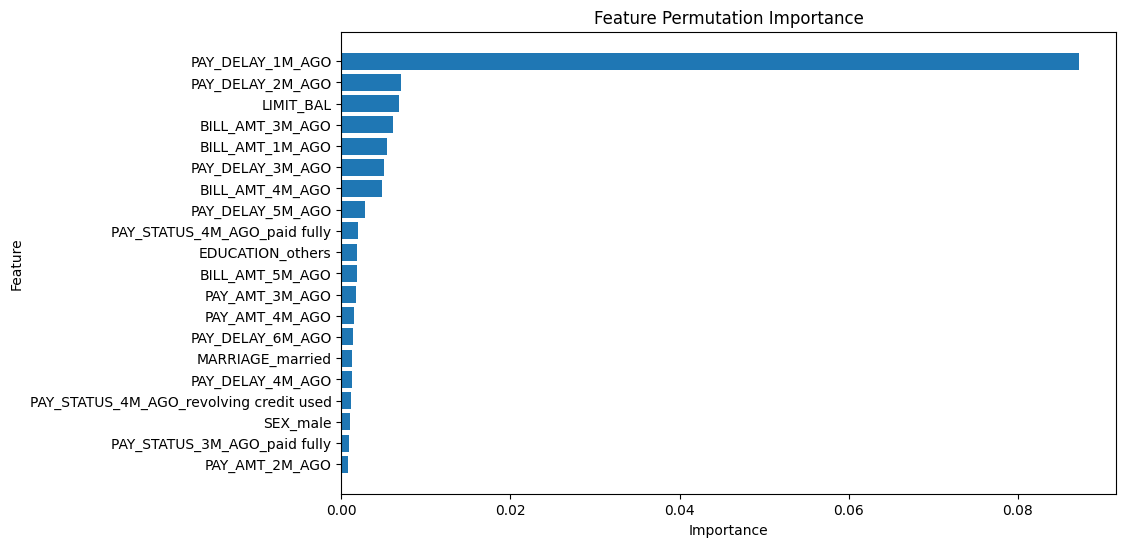

In [ ]:
plot_feat_permut_importance(gbt_feat_permut_import_df)

In [ ]:
gbt_perf, gbt_orig_missing, gbt_missing = measure_performance_decline(
    X_train, X_test, y_test, gbt_classifier, gbt_feat_permut_import_df,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family
)


--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_2M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO']

--- NEW ITERATION ---
Removing feature:  LIMIT_BAL
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'LIMIT_BAL']

--- NEW ITERATION ---
Removing feature:  BILL_AMT_3M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'LIMIT_BAL', 'BILL_AMT_3M_AGO']

--- NEW ITERATION ---
Removing feature:  BILL_AMT_1M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'LIMIT_BAL', 'BILL_AMT_3M_AGO', 'BILL_AMT_1M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_3M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'LIMIT_BAL', 'BILL_AMT_3M_AGO', 'BILL_AMT_1M_AGO', 'PAY_DELAY_3M_AGO']

--- NEW ITERATION ---
Removing feature:  BILL_AMT_4M_AGO
Original feat remo

In [ ]:
gbt_perf

tp    tn    fp    fn  precision  recall  specificity  accuracy  f1_score  \
0   837  3652  1021   490      45.05   63.07        78.15     74.82     52.56   
1   652  3840   833   675      43.91   49.13        82.17     74.87     46.37   
2   559  3927   746   768      42.84   42.13        84.04     74.77     42.48   
3   544  3934   739   783      42.40   40.99        84.19     74.63     41.69   
4   536  3920   753   791      41.58   40.39        83.89     74.27     40.98   
5   349  4372   301   978      53.69   26.30        93.56     78.68     35.31   
6   268  4469   204  1059      56.78   20.20        95.63     78.95     29.79   
7   268  4460   213  1059      55.72   20.20        95.44     78.80     29.65   
8   101  4583    90  1226      52.88    7.61        98.07     78.07     13.31   
9   101  4583    90  1226      52.88    7.61        98.07     78.07     13.31   
10   89  4592    81  1238      52.35    6.71        98.27     78.02     11.89   
11   88  4595    78  1239      53.01    6.63        98.33     78.05     11.79   
12   27  4658    15  1300      64.29    2.03        99.68     78.08      3.94   
13   16  4665     8  1311      66.67    1.21        99.83     78.02      2.37   
14    0  4672     1  1327       0.00    0.00        99.98     77.87      0.00   
15    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
16    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
17    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
18    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
19    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
20    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   

    balanced_accuracy  num_feat_missing  \
0               70.61                 0   
1               65.65                 1   
2               63.08                 2   
3               62.59                 3   
4               62.14                 4   
5               59.93                 5   
6               57.92                 6   
7               57.82                 7   
8               52.84                 8   
9               52.84                 9   
10              52.49                10   
11              52.48                11   
12              50.86                12   
13              50.52                13   
14              49.99                14   
15              50.00                15   
16              50.00                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2    ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO'] imputed  
3   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'LIMI...  
4   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'LIMI...  
5   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'LIMI...  
6   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'LIMI...  
7   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'LIMI...  
8   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'LIMI...  
9   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'LIMI...  
10  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'LIMI...  
11  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'LIMI...  
12  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'LIMI...  
13  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'LIMI...  
14  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'LIMI...  
15  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'LIMI...  
16  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'LIMI...  
17  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'LIMI...  
18  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'LIMI...  
19  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'LIMI...  
20  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'LIMI...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

gbt_perf_mf, gbt_orig_missing_mf, gbt_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, gbt_classifier, gbt_feat_permut_import_df,
    imputation_dict=None, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 13:07:20.139079

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Nr. columns with nan:  1
Numerical columns:  ['LIMIT_BAL', 'AGE', 'BILL_AMT_1M_AGO', 'BILL_AMT_2M_AGO', 'BILL_AMT_3M_AGO', 'BILL_AMT_4M_AGO', 'BILL_AMT_5M_AGO', 'BILL_AMT_6M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO']
Categorical columns:  ['SEX_male', 'EDUCATION_high school', 'EDUCATION_others', 'EDUCATION_university', 'MARRIAGE_married', 'MARRIAGE_others', 'MARRIAGE_single', 'PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used', 'PAY_STATUS_2M_AGO_paid fully', 'PAY_STATUS_2M_AGO_payment overdue', 'PAY_STATUS_2M_AGO_revolving credit used', 'PAY_STATUS_3M_AGO_paid fully', 'PAY_STATUS_3M_AGO_payment overdue', 'PAY_STATUS_3M_AGO_revolving credit used', 'PAY_STA

In [ ]:
gbt_perf_mf

tp    tn    fp   fn  precision  recall  specificity  accuracy  f1_score  \
0    837  3652  1021  490      45.05   63.07        78.15     74.82     52.56   
1   1052  2467  2206  275      32.29   79.28        52.79     58.65     45.89   
2   1027  2500  2173  300      32.09   77.39        53.50     58.78     45.37   
3    906  2826  1847  421      32.91   68.27        60.48     62.20     44.41   
4    904  2827  1846  423      32.87   68.12        60.50     62.18     44.35   
5    795  3236  1437  532      35.62   59.91        69.25     67.18     44.68   
6    746  3293  1380  581      35.09   56.22        70.47     67.32     43.21   
7    811  3098  1575  516      33.99   61.12        66.30     65.15     43.68   
8    955  2530  2143  372      30.83   71.97        54.14     58.08     43.16   
9    979  2370  2303  348      29.83   73.78        50.72     55.82     42.48   
10   982  2337  2336  345      29.60   74.00        50.01     55.32     42.28   
11  1020  2199  2474  307      29.19   76.87        47.06     53.65     42.31   
12  1020  2171  2502  307      28.96   76.87        46.46     53.18     42.07   
13  1020  2250  2423  307      29.63   76.87        48.15     54.50     42.77   
14  1170  1316  3357  157      25.84   88.17        28.16     41.43     39.97   
15  1141  1416  3257  186      25.94   85.98        30.30     42.62     39.86   
16  1198   934  3739  129      24.27   90.28        19.99     35.53     38.25   
17  1196   947  3726  131      24.30   90.13        20.27     35.72     38.28   
18  1226   888  3785  101      24.47   92.39        19.00     35.23     38.69   
19  1228   800  3873   99      24.07   92.54        17.12     33.80     38.21   
20  1253   653  4020   74      23.76   94.42        13.97     31.77     37.97   

    balanced_accuracy  num_feat_missing  \
0               70.61                 0   
1               66.03                 1   
2               65.45                 2   
3               64.37                 3   
4               64.31                 4   
5               64.58                 5   
6               63.34                 6   
7               63.71                 7   
8               63.05                 8   
9               62.25                 9   
10              62.01                10   
11              61.96                11   
12              61.66                12   
13              62.51                13   
14              58.17                14   
15              58.14                15   
16              55.13                16   
17              55.20                17   
18              55.70                18   
19              54.83                19   
20              54.20                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2    ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO'] imputed  
3   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'LIMI...  
4   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'LIMI...  
5   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'LIMI...  
6   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'LIMI...  
7   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'LIMI...  
8   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'LIMI...  
9   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'LIMI...  
10  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'LIMI...  
11  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'LIMI...  
12  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'LIMI...  
13  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'LIMI...  
14  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'LIMI...  
15  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'LIMI...  
16  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'LIMI...  
17  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'LIMI...  
18  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'LIMI...  
19  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'LIMI...  
20  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'LIMI...

In [ ]:
gbt_perf_temp, gbt_orig_missing_temp, gbt_missing_temp = measure_temporal_performance_decline(
    X_train, X_test, y_test, gbt_classifier, gbt_feat_permut_import_df,
    default_cc_timeline_vars_family,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family, log_info=True
)


--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  45
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_payment overdue
Removing related features:  []
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Columns with zero variance, i.e. imputed:
                                    feature  variance
2                           BILL_AMT_1M_AGO       0.0
8                            PAY_AMT_1M_AGO       0.0
14                         PAY_DELAY_1M_

In [ ]:
gbt_perf_temp

tp    tn    fp    fn  precision  recall  specificity  accuracy  f1_score  \
0  837  3652  1021   490      45.05   63.07        78.15     74.82     52.56   
1  485  4208   465   842      51.05   36.55        90.05     78.22     42.60   
2  375  4338   335   952      52.82   28.26        92.83     78.55     36.82   
3  332  4404   269   995      55.24   25.02        94.24     78.93     34.44   
4  259  4506   167  1068      60.80   19.52        96.43     79.42     29.55   
5    4  4671     2  1323      66.67    0.30        99.96     77.92      0.60   
6    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   

   balanced_accuracy  num_feat_missing  \
0              70.61                 0   
1              63.30                 4   
2              60.55                 8   
3              59.63                 9   
4              57.97                13   
5              50.13                17   
6              50.00                21   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

gbt_perf_temp_mf, gbt_orig_missing_temp_mf, gbt_missing_temp_mf = measure_temporal_performance_decline(
    X_train, X_test, y_test, gbt_classifier, gbt_feat_permut_import_df,
    default_cc_timeline_vars_family, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars, log_info=True
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 13:13:52.556672

--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  45
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_payment overdue
Removing related features:  []
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Nr. columns with nan:  6
Numerical columns:  ['LIMIT_BAL', 'AGE', 'BILL_AMT_1M_AGO', 'BILL_AMT_2M_AGO', 'BILL_AMT_3M_AGO', 'BILL_AMT_4M_AGO', 'BILL_AMT_5M_AGO', 'BILL_AMT_6M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', '

In [ ]:
gbt_perf_temp_mf

tp    tn    fp   fn  precision  recall  specificity  accuracy  f1_score  \
0   837  3652  1021  490      45.05   63.07        78.15     74.82     52.56   
1  1040  2294  2379  287      30.42   78.37        49.09     55.57     43.83   
2   787  3208  1465  540      34.95   59.31        68.65     66.58     43.98   
3   756  3204  1469  571      33.98   56.97        68.56     66.00     42.57   
4   795  2866  1807  532      30.55   59.91        61.33     61.02     40.47   
5   980  1930  2743  347      26.32   73.85        41.30     48.50     38.81   
6  1136  1036  3637  191      23.80   85.61        22.17     36.20     37.25   

   balanced_accuracy  num_feat_missing  \
0              70.61                 0   
1              63.73                 4   
2              63.98                 8   
3              62.77                 9   
4              60.62                13   
5              57.58                17   
6              53.89                21   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

## **XGBoost**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  xgb_param_grid = {
      'n_estimators': [100, 200, 300],
      'max_depth': [2, 3, 5, None],
      'reg_lambda':[10.0, 5.0, 1.0, 0.5, 0.0],   # L2 regularization on weights
      'gamma': [1.0, 0.5, 0.1, 0.05, 0.0],       # Minimum loss reduction required for node splitting (default=0)
      'colsample_bytree':[0.25, 0.5, 0.75, 1.0]  # Fraction of features used for each tree
  }
else:
  xgb_param_grid = {
      'n_estimators': [100],
      'max_depth': [2],
      'reg_lambda':[10.0],
      'gamma': [0.1],
      'colsample_bytree':[0.25]
  }

xgb_classifier = XGBClassifier(
    scale_pos_weight=ratio_majority_minority, random_state=RANDOM_STATE
)
xgb_grid_search, xgb_best_model, xgb_best_params = hyperparameter_tuning(
    xgb_classifier, xgb_param_grid, 3, 3, 'f1', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-18 10:33:02.362874

Nested Cross-validation Results:
Individual scores: [0.55200774 0.5418599  0.5309143 ]
Average nested CV score: 0.542 (+/- 0.017)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'colsample_bytree': 0.25, 'gamma': 0.1, 'max_depth': 2, 'n_estimators': 100, 'reg_lambda': 10.0}

Best Model Performance:
Best CV score: 0.542
2025-01-18 10:33:05.834461

Execution time: 0.06 minutes


```
Starting hyperparameter tuning at: 2025-01-17 16:49:30.760433

Nested Cross-validation Results:
Individual scores: [0.54951456 0.53957363 0.52624046]
Average nested CV score: 0.538 (+/- 0.019)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1200 candidates, totalling 3600 fits
Best parameters: {'colsample_bytree': 0.25, 'gamma': 0.1, 'max_depth': 2, 'n_estimators': 100, 'reg_lambda': 10.0}

Best Model Performance:
Best CV score: 0.542
2025-01-17 17:11:50.271162

Execution time: 22.33 minutes
```

In [ ]:
xgb_classifier, xgb_train_pred, xgb_test_pred = apply_model(xgb_best_model, X_train, y_train, X_test, y_test)
xgb_feat_permut_import_df = analyze_feat_permut_import(xgb_classifier, X_train, y_train, scoring_metric="f1")
xgb_feat_permut_import_df[xgb_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
14                         PAY_DELAY_1M_AGO    0.063620  0.001017
31        PAY_STATUS_2M_AGO_payment overdue    0.016380  0.000612
4                           BILL_AMT_3M_AGO    0.009908  0.001541
2                           BILL_AMT_1M_AGO    0.008171  0.001281
10                           PAY_AMT_3M_AGO    0.005425  0.001133
5                           BILL_AMT_4M_AGO    0.004867  0.001995
9                            PAY_AMT_2M_AGO    0.004862  0.001230
18                         PAY_DELAY_5M_AGO    0.004806  0.001210
0                                 LIMIT_BAL    0.004410  0.002900
16                         PAY_DELAY_3M_AGO    0.003922  0.001347
7                           BILL_AMT_6M_AGO    0.002603  0.000671
3                           BILL_AMT_2M_AGO    0.002290  0.000882
22                         EDUCATION_others    0.001951  0.000622
38  PAY_STATUS_4M_AGO_revolving credit used    0.001454  0.000363
37        PAY_STATUS_4M_AGO_payment overdue    0.001380  0.000428
28        PAY_STATUS_1M_AGO_payment overdue    0.001210  0.000720
24                         MARRIAGE_married    0.001209  0.000592
32  PAY_STATUS_2M_AGO_revolving credit used    0.000947  0.000155
41  PAY_STATUS_5M_AGO_revolving credit used    0.000779  0.000192
42             PAY_STATUS_6M_AGO_paid fully    0.000529  0.000551
19                         PAY_DELAY_6M_AGO    0.000433  0.000396
33             PAY_STATUS_3M_AGO_paid fully    0.000423  0.000196
6                           BILL_AMT_5M_AGO    0.000421  0.000553
25                          MARRIAGE_others    0.000380  0.000105
23                     EDUCATION_university    0.000344  0.000197
1                                       AGE    0.000329  0.000697
43        PAY_STATUS_6M_AGO_payment overdue    0.000294  0.000435
21                    EDUCATION_high school    0.000272  0.000169
8                            PAY_AMT_1M_AGO    0.000176  0.000840
26                          MARRIAGE_single    0.000098  0.000222
15                         PAY_DELAY_2M_AGO    0.000048  0.000480
34        PAY_STATUS_3M_AGO_payment overdue   -0.000087  0.000066
11                           PAY_AMT_4M_AGO   -0.000220  0.001256
29  PAY_STATUS_1M_AGO_revolving credit used   -0.000287  0.001012
30             PAY_STATUS_2M_AGO_paid fully   -0.000321  0.000218
12                           PAY_AMT_5M_AGO   -0.000601  0.001049
13                           PAY_AMT_6M_AGO   -0.001257  0.000507
20                                 SEX_male   -0.001386  0.000691
27             PAY_STATUS_1M_AGO_paid fully   -0.001512  0.000943

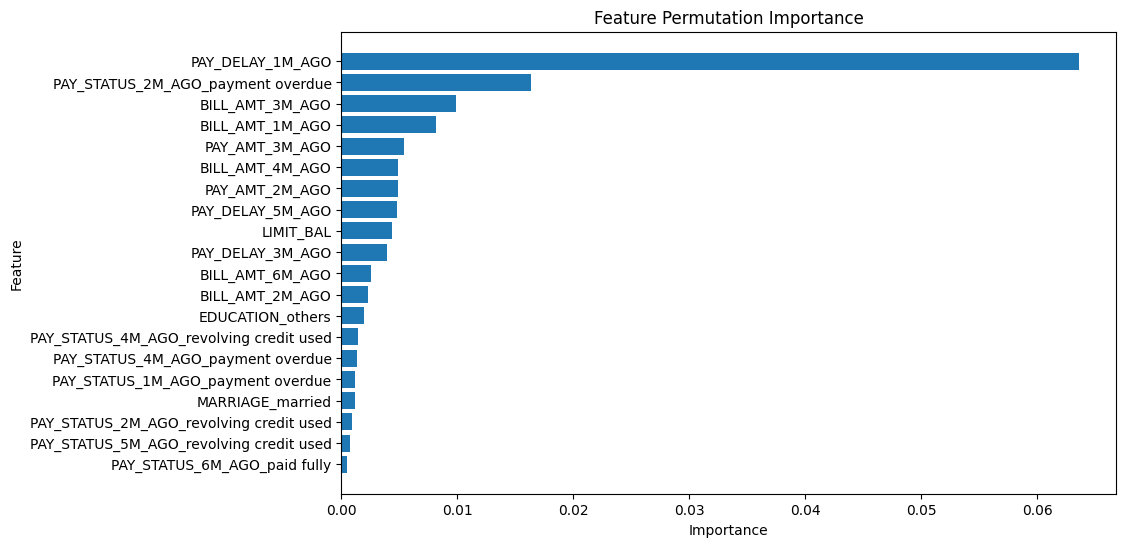

In [ ]:
plot_feat_permut_importance(xgb_feat_permut_import_df)

In [ ]:
xgb_perf, xgb_orig_missing, xgb_missing = measure_performance_decline(
    X_train, X_test, y_test, xgb_classifier, xgb_feat_permut_import_df,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family
)


--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_STATUS_2M_AGO_payment overdue
Removing related features:  ['PAY_STATUS_2M_AGO_paid fully', 'PAY_STATUS_2M_AGO_payment overdue', 'PAY_STATUS_2M_AGO_revolving credit used']
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_2M_AGO']

--- NEW ITERATION ---
Removing feature:  BILL_AMT_3M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_2M_AGO', 'BILL_AMT_3M_AGO']

--- NEW ITERATION ---
Removing feature:  BILL_AMT_1M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_2M_AGO', 'BILL_AMT_3M_AGO', 'BILL_AMT_1M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_AMT_3M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_2M_AGO', 'BILL_AMT_3M_AGO', 'BILL_AMT_1M_AGO', 'PAY_AMT_3M_AGO']

--- NEW ITERATION ---
Removing feature:  BILL_AMT_4M_AGO
Original feat removed so far:  ['PAY

In [ ]:
xgb_perf

tp    tn    fp    fn  precision  recall  specificity  accuracy  f1_score  \
0   831  3642  1031   496      44.63   62.62        77.94     74.55     52.12   
1   714  3771   902   613      44.18   53.81        80.70     74.75     48.52   
2   587  3901   772   740      43.19   44.24        83.48     74.80     43.71   
3   587  3861   812   740      41.96   44.24        82.62     74.13     43.07   
4   426  4265   408   901      51.08   32.10        91.27     78.18     39.43   
5   343  4400   273   984      55.68   25.85        94.16     79.05     35.31   
6   358  4382   291   969      55.16   26.98        93.77     79.00     36.23   
7   363  4390   283   964      56.19   27.35        93.94     79.22     36.80   
8   262  4488   185  1065      58.61   19.74        96.04     79.17     29.54   
9   191  4546   127  1136      60.06   14.39        97.28     78.95     23.22   
10  123  4615    58  1204      67.96    9.27        98.76     78.97     16.31   
11  116  4607    66  1211      63.74    8.74        98.59     78.72     15.37   
12  123  4597    76  1204      61.81    9.27        98.37     78.67     16.12   
13  116  4609    64  1211      64.44    8.74        98.63     78.75     15.39   
14   34  4655    18  1293      65.38    2.56        99.61     78.15      4.93   
15    3  4671     2  1324      60.00    0.23        99.96     77.90      0.45   
16    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
17    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
18    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
19    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
20    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   

    balanced_accuracy  num_feat_missing  \
0               70.28                 0   
1               67.25                 1   
2               63.86                 2   
3               63.43                 3   
4               61.69                 4   
5               60.00                 5   
6               60.38                 6   
7               60.65                 7   
8               57.89                 8   
9               55.84                 9   
10              54.01                10   
11              53.66                11   
12              53.82                12   
13              53.69                13   
14              51.09                14   
15              50.09                15   
16              50.00                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_2M_AGO_paid f...  
3   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_2M_AGO_paid f...  
4   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_2M_AGO_paid f...  
5   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_2M_AGO_paid f...  
6   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_2M_AGO_paid f...  
7   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_2M_AGO_paid f...  
8   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_2M_AGO_paid f...  
9   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_2M_AGO_paid f...  
10  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_2M_AGO_paid f...  
11  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_2M_AGO_paid f...  
12  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_2M_AGO_paid f...  
13  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_2M_AGO_paid f...  
14  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_2M_AGO_paid f...  
15  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_2M_AGO_paid f...  
16  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_2M_AGO_paid f...  
17  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_2M_AGO_paid f...  
18  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_2M_AGO_paid f...  
19  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_2M_AGO_paid f...  
20  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_2M_AGO_paid f...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

xgb_perf_mf, xgb_orig_missing_mf, xgb_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, xgb_classifier, xgb_feat_permut_import_df,
    imputation_dict=None, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 13:15:50.472115

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Nr. columns with nan:  1
Numerical columns:  ['LIMIT_BAL', 'AGE', 'BILL_AMT_1M_AGO', 'BILL_AMT_2M_AGO', 'BILL_AMT_3M_AGO', 'BILL_AMT_4M_AGO', 'BILL_AMT_5M_AGO', 'BILL_AMT_6M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO']
Categorical columns:  ['SEX_male', 'EDUCATION_high school', 'EDUCATION_others', 'EDUCATION_university', 'MARRIAGE_married', 'MARRIAGE_others', 'MARRIAGE_single', 'PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used', 'PAY_STATUS_2M_AGO_paid fully', 'PAY_STATUS_2M_AGO_payment overdue', 'PAY_STATUS_2M_AGO_revolving credit used', 'PAY_STATUS_3M_AGO_paid fully', 'PAY_STATUS_3M_AGO_payment overdue', 'PAY_STATUS_3M_AGO_revolving credit used', 'PAY_STA

In [ ]:
xgb_perf_mf

tp    tn    fp    fn  precision  recall  specificity  accuracy  f1_score  \
0   831  3642  1031   496      44.63   62.62        77.94     74.55     52.12   
1   728  3752   921   599      44.15   54.86        80.29     74.67     48.92   
2   691  3800   873   636      44.18   52.07        81.32     74.85     47.80   
3   695  3788   885   632      43.99   52.37        81.06     74.72     47.82   
4   604  4028   645   723      48.36   45.52        86.20     77.20     46.89   
5   564  4108   565   763      49.96   42.50        87.91     77.87     45.93   
6   523  4206   467   804      52.83   39.41        90.01     78.82     45.14   
7   499  4238   435   828      53.43   37.60        90.69     78.95     44.14   
8   458  4294   379   869      54.72   34.51        91.89     79.20     42.33   
9   424  4320   353   903      54.57   31.95        92.45     79.07     40.30   
10  371  4391   282   956      56.81   27.96        93.97     79.37     37.47   
11  375  4396   277   952      57.52   28.26        94.07     79.52     37.90   
12  334  4420   253   993      56.90   25.17        94.59     79.23     34.90   
13  331  4419   254   996      56.58   24.94        94.56     79.17     34.62   
14  253  4488   185  1074      57.76   19.07        96.04     79.02     28.67   
15  200  4494   179  1127      52.77   15.07        96.17     78.23     23.45   
16  163  4518   155  1164      51.26   12.28        96.68     78.02     19.82   
17  132  4512   161  1195      45.05    9.95        96.55     77.40     16.30   
18  274  4425   248  1053      52.49   20.65        94.69     78.32     29.64   
19  241  4448   225  1086      51.72   18.16        95.19     78.15     26.88   
20   37  4644    29  1290      56.06    2.79        99.38     78.02      5.31   

    balanced_accuracy  num_feat_missing  \
0               70.28                 0   
1               67.58                 1   
2               66.70                 2   
3               66.72                 3   
4               65.86                 4   
5               65.21                 5   
6               64.71                 6   
7               64.15                 7   
8               63.20                 8   
9               62.20                 9   
10              60.96                10   
11              61.17                11   
12              59.88                12   
13              59.75                13   
14              57.55                14   
15              55.62                15   
16              54.48                16   
17              53.25                17   
18              57.67                18   
19              56.67                19   
20              51.08                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_2M_AGO_paid f...  
3   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_2M_AGO_paid f...  
4   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_2M_AGO_paid f...  
5   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_2M_AGO_paid f...  
6   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_2M_AGO_paid f...  
7   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_2M_AGO_paid f...  
8   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_2M_AGO_paid f...  
9   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_2M_AGO_paid f...  
10  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_2M_AGO_paid f...  
11  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_2M_AGO_paid f...  
12  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_2M_AGO_paid f...  
13  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_2M_AGO_paid f...  
14  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_2M_AGO_paid f...  
15  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_2M_AGO_paid f...  
16  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_2M_AGO_paid f...  
17  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_2M_AGO_paid f...  
18  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_2M_AGO_paid f...  
19  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_2M_AGO_paid f...  
20  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_2M_AGO_paid f...

In [ ]:
xgb_perf_temp, xgb_orig_missing_temp, xgb_missing_temp = measure_temporal_performance_decline(
    X_train, X_test, y_test, xgb_classifier, xgb_feat_permut_import_df,
    default_cc_timeline_vars_family,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family, log_info=True
)


--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  45
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_payment overdue
Removing related features:  []
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Columns with zero variance, i.e. imputed:
                                    feature  variance
2                           BILL_AMT_1M_AGO       0.0
8                            PAY_AMT_1M_AGO       0.0
14                         PAY_DELAY_1M_

In [ ]:
xgb_perf_temp

tp    tn    fp    fn  precision  recall  specificity  accuracy  f1_score  \
0  831  3642  1031   496      44.63   62.62        77.94     74.55     52.12   
1  510  4171   502   817      50.40   38.43        89.26     78.02     43.61   
2  375  4314   359   952      51.09   28.26        92.32     78.15     36.39   
3  262  4464   209  1065      55.63   19.74        95.53     78.77     29.14   
4  220  4494   179  1107      55.14   16.58        96.17     78.57     25.49   
5    1  4673     0  1326     100.00    0.08       100.00     77.90      0.15   

   balanced_accuracy  num_feat_missing  \
0              70.28                 0   
1              63.84                 4   
2              60.29                 8   
3              57.64                12   
4              56.37                16   
5              50.04                20   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

xgb_perf_temp_mf, xgb_orig_missing_temp_mf, xgb_missing_temp_mf = measure_temporal_performance_decline(
    X_train, X_test, y_test, xgb_classifier, xgb_feat_permut_import_df,
    default_cc_timeline_vars_family, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars, log_info=True
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 13:22:18.815199

--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  45
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_payment overdue
Removing related features:  []
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Nr. columns with nan:  6
Numerical columns:  ['LIMIT_BAL', 'AGE', 'BILL_AMT_1M_AGO', 'BILL_AMT_2M_AGO', 'BILL_AMT_3M_AGO', 'BILL_AMT_4M_AGO', 'BILL_AMT_5M_AGO', 'BILL_AMT_6M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', '

In [ ]:
xgb_perf_temp_mf

tp    tn    fp    fn  precision  recall  specificity  accuracy  f1_score  \
0  831  3642  1031   496      44.63   62.62        77.94     74.55     52.12   
1  644  3887   786   683      45.03   48.53        83.18     75.52     46.72   
2  467  4151   522   860      47.22   35.19        88.83     76.97     40.33   
3  289  4417   256  1038      53.03   21.78        94.52     78.43     30.88   
4  229  4479   194  1098      54.14   17.26        95.85     78.47     26.17   
5   94  4613    60  1233      61.04    7.08        98.72     78.45     12.69   

   balanced_accuracy  num_feat_missing  \
0              70.28                 0   
1              65.86                 4   
2              62.01                 8   
3              58.15                12   
4              56.55                16   
5              52.90                20   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

## **Extra Trees Classifier**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  et_param_grid = {
      'n_estimators': [100, 200, 300, 500],
      'max_depth': [2, 3, 5, None],
      'max_features':['sqrt', 0.5, 1.0],
      'min_samples_split': [0.005, 0.001, 2],
      'min_samples_leaf': [0.005, 0.001, 1]
  }
else:
  et_param_grid = {
      'n_estimators': [500],
      'max_depth': [None],
      'max_features':[0.5],
      'min_samples_split': [0.005],
      'min_samples_leaf': [1]
  }

et_classifier = ExtraTreesClassifier(class_weight='balanced', random_state=RANDOM_STATE)
et_grid_search, et_best_model, et_best_params = hyperparameter_tuning(
    et_classifier, et_param_grid, 3, 3, 'f1', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-18 10:39:16.831348

Nested Cross-validation Results:
Individual scores: [0.54489952 0.5482882  0.53131313]
Average nested CV score: 0.542 (+/- 0.015)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'max_depth': None, 'max_features': 0.5, 'min_samples_leaf': 1, 'min_samples_split': 0.005, 'n_estimators': 500}

Best Model Performance:
Best CV score: 0.542
2025-01-18 10:40:23.960446

Execution time: 1.12 minutes


```
Starting hyperparameter tuning at: 2025-01-17 18:45:15.812447

Nested Cross-validation Results:
Individual scores: [0.54703033 0.54347275 0.53131313]
Average nested CV score: 0.541 (+/- 0.013)

Fitting final model on entire dataset...
Fitting 3 folds for each of 432 candidates, totalling 1296 fits
Best parameters: {'max_depth': None, 'max_features': 0.5, 'min_samples_leaf': 1, 'min_samples_split': 0.005, 'n_estimators': 500}

Best Model Performance:
Best CV score: 0.542
2025-01-17 19:46:52.995333

Execution time: 61.62 minutes
```

In [ ]:
# et_grid_search.cv_results_

In [ ]:
et_classifier, train_pred, test_pred = apply_model(et_best_model, X_train, y_train, X_test, y_test)
et_feat_permut_import_df = analyze_feat_permut_import(et_classifier, X_train, y_train, scoring_metric="f1")
et_feat_permut_import_df[et_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
28        PAY_STATUS_1M_AGO_payment overdue    0.041980  0.001106
14                         PAY_DELAY_1M_AGO    0.039945  0.001115
0                                 LIMIT_BAL    0.039436  0.001569
44  PAY_STATUS_6M_AGO_revolving credit used    0.025353  0.002050
6                           BILL_AMT_5M_AGO    0.020928  0.000774
2                           BILL_AMT_1M_AGO    0.020427  0.001797
3                           BILL_AMT_2M_AGO    0.020334  0.000706
8                            PAY_AMT_1M_AGO    0.018459  0.002502
29  PAY_STATUS_1M_AGO_revolving credit used    0.017432  0.001271
23                     EDUCATION_university    0.015916  0.000765
32  PAY_STATUS_2M_AGO_revolving credit used    0.015813  0.001614
5                           BILL_AMT_4M_AGO    0.015659  0.001120
20                                 SEX_male    0.015394  0.001226
27             PAY_STATUS_1M_AGO_paid fully    0.015147  0.000419
4                           BILL_AMT_3M_AGO    0.014907  0.000547
7                           BILL_AMT_6M_AGO    0.014322  0.000862
33             PAY_STATUS_3M_AGO_paid fully    0.014026  0.000748
1                                       AGE    0.013615  0.001003
9                            PAY_AMT_2M_AGO    0.013533  0.000870
35  PAY_STATUS_3M_AGO_revolving credit used    0.013047  0.001049
11                           PAY_AMT_4M_AGO    0.012416  0.001273
10                           PAY_AMT_3M_AGO    0.011857  0.001174
34        PAY_STATUS_3M_AGO_payment overdue    0.011725  0.001944
31        PAY_STATUS_2M_AGO_payment overdue    0.011673  0.001104
38  PAY_STATUS_4M_AGO_revolving credit used    0.011635  0.001137
26                          MARRIAGE_single    0.011507  0.001265
13                           PAY_AMT_6M_AGO    0.011366  0.000933
36             PAY_STATUS_4M_AGO_paid fully    0.010967  0.000954
41  PAY_STATUS_5M_AGO_revolving credit used    0.010864  0.001026
24                         MARRIAGE_married    0.010365  0.000738
12                           PAY_AMT_5M_AGO    0.010314  0.001076
37        PAY_STATUS_4M_AGO_payment overdue    0.009394  0.001197
42             PAY_STATUS_6M_AGO_paid fully    0.008441  0.000785
30             PAY_STATUS_2M_AGO_paid fully    0.007732  0.000731
39             PAY_STATUS_5M_AGO_paid fully    0.007223  0.001141
40        PAY_STATUS_5M_AGO_payment overdue    0.005734  0.000490
21                    EDUCATION_high school    0.005548  0.000453
22                         EDUCATION_others    0.004409  0.000445
43        PAY_STATUS_6M_AGO_payment overdue    0.003071  0.000328
16                         PAY_DELAY_3M_AGO    0.002532  0.001138
19                         PAY_DELAY_6M_AGO    0.002428  0.000163
15                         PAY_DELAY_2M_AGO    0.000973  0.000665
18                         PAY_DELAY_5M_AGO    0.000971  0.000331
25                          MARRIAGE_others    0.000650  0.000109
17                         PAY_DELAY_4M_AGO   -0.000621  0.000278

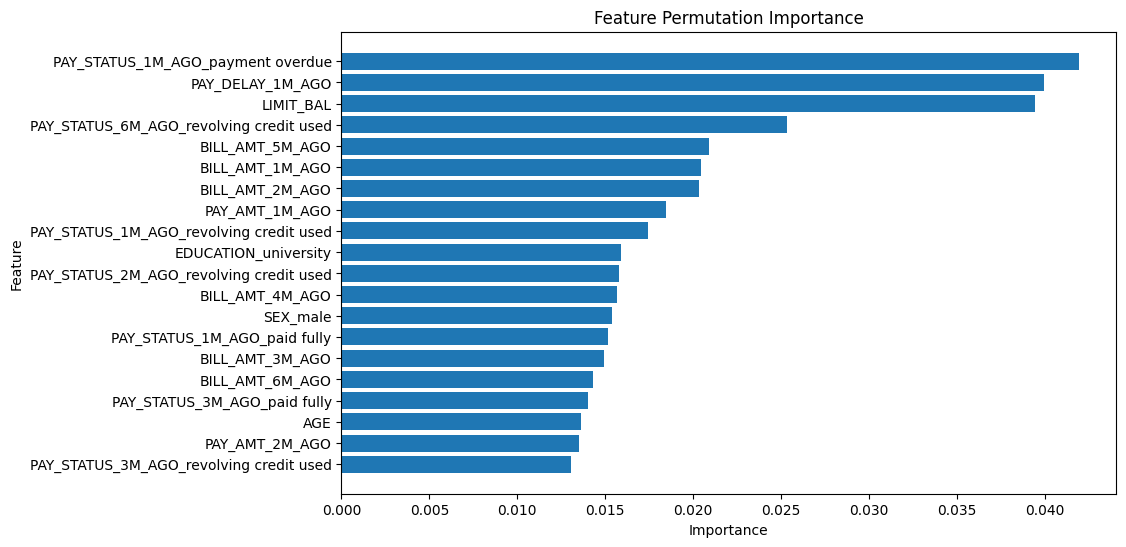

In [ ]:
plot_feat_permut_importance(et_feat_permut_import_df)

In [ ]:
et_perf, et_orig_missing, et_missing = measure_performance_decline(
    X_train, X_test, y_test, et_classifier, et_feat_permut_import_df,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family
)


--- NEW ITERATION ---
Removing feature:  PAY_STATUS_1M_AGO_payment overdue
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used']
Original feat removed so far:  ['PAY_STATUS_1M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Original feat removed so far:  ['PAY_STATUS_1M_AGO', 'PAY_DELAY_1M_AGO']

--- NEW ITERATION ---
Removing feature:  LIMIT_BAL
Original feat removed so far:  ['PAY_STATUS_1M_AGO', 'PAY_DELAY_1M_AGO', 'LIMIT_BAL']

--- NEW ITERATION ---
Removing feature:  PAY_STATUS_6M_AGO_revolving credit used
Removing related features:  ['PAY_STATUS_6M_AGO_paid fully', 'PAY_STATUS_6M_AGO_payment overdue', 'PAY_STATUS_6M_AGO_revolving credit used']
Original feat removed so far:  ['PAY_STATUS_1M_AGO', 'PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_6M_AGO']

--- NEW ITERATION ---
Removing feature:  BILL_AMT_5M_AGO
Original feat removed so far:  ['PAY_STATUS_1M_AGO', 'PAY_DELAY_1M_AGO',

In [ ]:
et_perf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0   798  3760  913   529      46.64   60.14        80.46     75.97     52.53   
1   663  3984  689   664      49.04   49.96        85.26     77.45     49.50   
2   617  4015  658   710      48.39   46.50        85.92     77.20     47.43   
3   579  4072  601   748      49.07   43.63        87.14     77.52     46.19   
4   557  4112  561   770      49.82   41.97        87.99     77.82     45.56   
5   562  4110  563   765      49.96   42.35        87.95     77.87     45.84   
6   562  4114  559   765      50.13   42.35        88.04     77.93     45.92   
7   562  4113  560   765      50.09   42.35        88.02     77.92     45.90   
8   559  4112  561   768      49.91   42.13        87.99     77.85     45.69   
9   557  4112  561   770      49.82   41.97        87.99     77.82     45.56   
10  381  4322  351   946      52.05   28.71        92.49     78.38     37.01   
11  383  4320  353   944      52.04   28.86        92.45     78.38     37.13   
12  381  4319  354   946      51.84   28.71        92.42     78.33     36.95   
13  383  4318  355   944      51.90   28.86        92.40     78.35     37.09   
14  388  4309  364   939      51.60   29.24        92.21     78.28     37.33   
15  390  4303  370   937      51.32   29.39        92.08     78.22     37.37   
16  390  4303  370   937      51.32   29.39        92.08     78.22     37.37   
17  392  4295  378   935      50.91   29.54        91.91     78.12     37.39   
18  393  4294  379   934      50.91   29.62        91.89     78.12     37.45   
19  371  4352  321   956      53.61   27.96        93.13     78.72     36.75   
20  258  4517  156  1069      62.32   19.44        96.66     79.58     29.64   

    balanced_accuracy  num_feat_missing  \
0               70.30                 0   
1               67.61                 1   
2               66.21                 2   
3               65.39                 3   
4               64.98                 4   
5               65.15                 5   
6               65.19                 6   
7               65.18                 7   
8               65.06                 8   
9               64.98                 9   
10              60.60                10   
11              60.65                11   
12              60.57                12   
13              60.63                13   
14              60.72                14   
15              60.74                15   
16              60.74                16   
17              60.73                17   
18              60.75                18   
19              60.54                19   
20              58.05                20   

                                              imputed  
0                                                      
1   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
2   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
3   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
4   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
5   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
6   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
7   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
8   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
9   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
10  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
11  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
12  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
13  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
14  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
15  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
16  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
17  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
18  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
19  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
20  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

et_perf_mf, et_orig_missing_mf, et_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, et_classifier, et_feat_permut_import_df,
    imputation_dict=None, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 13:23:56.824043

--- NEW ITERATION ---
Removing feature:  PAY_STATUS_1M_AGO_payment overdue
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used']
Nr. columns with nan:  3
Numerical columns:  ['LIMIT_BAL', 'AGE', 'BILL_AMT_1M_AGO', 'BILL_AMT_2M_AGO', 'BILL_AMT_3M_AGO', 'BILL_AMT_4M_AGO', 'BILL_AMT_5M_AGO', 'BILL_AMT_6M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO']
Categorical columns:  ['SEX_male', 'EDUCATION_high school', 'EDUCATION_others', 'EDUCATION_university', 'MARRIAGE_married', 'MARRIAGE_others', 'MARRIAGE_single', 'PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used', 'PAY_STATUS_2M_AGO_paid fully', 'PAY_STATUS_2M_AGO_payment overdue', 'PAY_

In [ ]:
et_perf_mf

tp    tn   fp   fn  precision  recall  specificity  accuracy  f1_score  \
0   798  3760  913  529      46.64   60.14        80.46     75.97     52.53   
1   725  3824  849  602      46.06   54.63        81.83     75.82     49.98   
2   675  3862  811  652      45.42   50.87        82.64     75.62     47.99   
3   673  3848  825  654      44.93   50.72        82.35     75.35     47.65   
4   651  3936  737  676      46.90   49.06        84.23     76.45     47.96   
5   642  3954  719  685      47.17   48.38        84.61     76.60     47.77   
6   599  4025  648  728      48.04   45.14        86.13     77.07     46.54   
7   597  4034  639  730      48.30   44.99        86.33     77.18     46.59   
8   593  4043  630  734      48.49   44.69        86.52     77.27     46.51   
9   589  4048  625  738      48.52   44.39        86.63     77.28     46.36   
10  527  4094  579  800      47.65   39.71        87.61     77.02     43.32   
11  528  4090  583  799      47.52   39.79        87.52     76.97     43.31   
12  548  4081  592  779      48.07   41.30        87.33     77.15     44.43   
13  559  4069  604  768      48.07   42.13        87.07     77.13     44.90   
14  566  4057  616  761      47.88   42.65        86.82     77.05     45.12   
15  517  4156  517  810      50.00   38.96        88.94     77.88     43.80   
16  510  4168  505  817      50.25   38.43        89.19     77.97     43.55   
17  512  4165  508  815      50.20   38.58        89.13     77.95     43.63   
18  509  4161  512  818      49.85   38.36        89.04     77.83     43.36   
19  515  4168  505  812      50.49   38.81        89.19     78.05     43.89   
20  431  4323  350  896      55.19   32.48        92.51     79.23     40.89   

    balanced_accuracy  num_feat_missing  \
0               70.30                 0   
1               68.23                 1   
2               66.76                 2   
3               66.53                 3   
4               66.64                 4   
5               66.50                 5   
6               65.64                 6   
7               65.66                 7   
8               65.60                 8   
9               65.51                 9   
10              63.66                10   
11              63.66                11   
12              64.31                12   
13              64.60                13   
14              64.74                14   
15              63.95                15   
16              63.81                16   
17              63.86                17   
18              63.70                18   
19              64.00                19   
20              62.49                20   

                                              imputed  
0                                                      
1   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
2   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
3   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
4   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
5   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
6   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
7   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
8   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
9   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
10  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
11  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
12  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
13  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
14  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
15  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
16  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
17  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
18  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
19  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
20  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...

In [ ]:
et_perf_temp, et_orig_missing_temp, et_missing_temp = measure_temporal_performance_decline(
    X_train, X_test, y_test, et_classifier, et_feat_permut_import_df,
    default_cc_timeline_vars_family,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family, log_info=True
)


--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  45
length removed:  0

Removing feature:  PAY_STATUS_1M_AGO_payment overdue
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_payment overdue
Removing related features:  []
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Columns with zero variance, i.e. imputed:
                                    feature  variance
2                           BILL_AMT_1M_AGO       0.0
8                            PAY_AMT_1M_AGO       0.0
14                     

In [ ]:
et_perf_temp

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0  798  3760  913   529      46.64   60.14        80.46     75.97     52.53   
1  569  4087  586   758      49.26   42.88        87.46     77.60     45.85   
2  561  4103  570   766      49.60   42.28        87.80     77.73     45.65   
3  564  4095  578   763      49.39   42.50        87.63     77.65     45.69   
4  539  4147  526   788      50.61   40.62        88.74     78.10     45.07   
5  238  4412  261  1089      47.70   17.94        94.41     77.50     26.07   
6  242  4410  263  1085      47.92   18.24        94.37     77.53     26.42   
7    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   

   balanced_accuracy  num_feat_missing  \
0              70.30                 0   
1              65.17                 4   
2              65.04                 5   
3              65.07                 9   
4              64.68                13   
5              56.17                17   
6              56.30                18   
7              50.00                22   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
7  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

et_perf_temp_mf, et_orig_missing_temp_mf, et_missing_temp_mf = measure_temporal_performance_decline(
    X_train, X_test, y_test, et_classifier, et_feat_permut_import_df,
    default_cc_timeline_vars_family, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars, log_info=True
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 13:30:30.105948

--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  45
length removed:  0

Removing feature:  PAY_STATUS_1M_AGO_payment overdue
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_payment overdue
Removing related features:  []
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Nr. columns with nan:  6
Numerical columns:  ['LIMIT_BAL', 'AGE', 'BILL_AMT_1M_AGO', 'BILL_AMT_2M_AGO', 'BILL_AMT_3M_AGO', 'BILL_AMT_4M_AGO', 'BILL_AMT_5M_AGO', 'BILL_AMT_6M_AGO', 'PAY_AMT_1M_AGO', 'P

In [ ]:
et_perf_temp_mf

tp    tn   fp   fn  precision  recall  specificity  accuracy  f1_score  \
0  798  3760  913  529      46.64   60.14        80.46     75.97     52.53   
1  623  3945  728  704      46.11   46.95        84.42     76.13     46.53   
2  613  3945  728  714      45.71   46.19        84.42     75.97     45.95   
3  595  4026  647  732      47.91   44.84        86.15     77.02     46.32   
4  586  4053  620  741      48.59   44.16        86.73     77.32     46.27   
5  448  4207  466  879      49.02   33.76        90.03     77.58     39.98   
6  453  4197  476  874      48.76   34.14        89.81     77.50     40.16   
7  411  4245  428  916      48.99   30.97        90.84     77.60     37.95   

   balanced_accuracy  num_feat_missing  \
0              70.30                 0   
1              65.68                 4   
2              65.31                 5   
3              65.50                 9   
4              65.45                13   
5              61.89                17   
6              61.98                18   
7              60.91                22   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
7  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

##**Support Vector Classifier**

In [ ]:
# scale data with MinMax
X_train_scaled, default_cc_scaler = scale_minmax_features(X_train, mode="train", scaler = None)
X_test_scaled, _ = scale_minmax_features(X_test, mode="test", scaler = default_cc_scaler)

In [ ]:
default_cc_imputation_scaled_values_dict = calculate_imputation_values_for_missing(X_train_scaled)

In [ ]:
default_cc_imputation_scaled_values_dict

{'LIMIT_BAL': 0.16455696202531644,
 'AGE': 0.2241379310344827,
 'BILL_AMT_1M_AGO': 0.19690791727980111,
 'BILL_AMT_2M_AGO': 0.1121472644446001,
 'BILL_AMT_3M_AGO': 0.047337585006910654,
 'BILL_AMT_4M_AGO': 0.21563435150718924,
 'BILL_AMT_5M_AGO': 0.10985617887131247,
 'BILL_AMT_6M_AGO': 0.19756856587812627,
 'PAY_AMT_1M_AGO': 0.0024039782405626685,
 'PAY_AMT_2M_AGO': 0.0011939968852771458,
 'PAY_AMT_3M_AGO': 0.0020313978064053144,
 'PAY_AMT_4M_AGO': 0.0024154589371980675,
 'PAY_AMT_5M_AGO': 0.0035167597044984044,
 'PAY_AMT_6M_AGO': 0.002845527684138839,
 'PAY_DELAY_1M_AGO': 0.0,
 'PAY_DELAY_2M_AGO': 0.0,
 'PAY_DELAY_3M_AGO': 0.0,
 'PAY_DELAY_4M_AGO': 0.0,
 'PAY_DELAY_5M_AGO': 0.0,
 'PAY_DELAY_6M_AGO': 0.0,
 'SEX_male': 0.0,
 'EDUCATION_high school': 0.0,
 'EDUCATION_others': 0.0,
 'EDUCATION_university': 0.0,
 'MARRIAGE_married': 0.0,
 'MARRIAGE_others': 0.0,
 'MARRIAGE_single': 1.0,
 'PAY_STATUS_1M_AGO_paid fully': 0.0,
 'PAY_STATUS_1M_AGO_payment overdue': 0.0,
 'PAY_STATUS_1M_AGO_re

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  svm_param_grid = {
      'C': [0.01, 0.1, 0.5, 1, 5],
      'kernel': ['linear', 'rbf'],
      'gamma': ['scale', 0.1, 0.5, 1]
  }
else:
  # best model
  svm_param_grid = {
      'C': [0.1],
      'kernel': ['rbf'],
      'gamma': [0.5]
}

svm_classifier = SVC(
    class_weight='balanced', cache_size=1000, random_state=RANDOM_STATE
)
svm_grid_search, svm_best_model, svm_best_params = hyperparameter_tuning(
    svm_classifier, svm_param_grid, 3, 3, 'f1', X_train_scaled, y_train
)

Starting hyperparameter tuning at: 2025-01-18 10:48:06.637069

Nested Cross-validation Results:
Individual scores: [0.54022685 0.53006452 0.52712358]
Average nested CV score: 0.532 (+/- 0.011)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'C': 0.1, 'gamma': 0.5, 'kernel': 'rbf'}

Best Model Performance:
Best CV score: 0.532
2025-01-18 10:49:37.220718

Execution time: 1.51 minutes


```
Starting hyperparameter tuning at: 2025-01-17 17:11:50.349350

Nested Cross-validation Results:
Individual scores: [0.54235537 0.53006452 0.52712358]
Average nested CV score: 0.533 (+/- 0.013)

Fitting final model on entire dataset...
Fitting 3 folds for each of 40 candidates, totalling 120 fits
Best parameters: {'C': 0.1, 'gamma': 0.5, 'kernel': 'rbf'}

Best Model Performance:
Best CV score: 0.532
2025-01-17 17:34:41.322594

Execution time: 22.85 minutes
```




In [ ]:
svm_classifier, train_pred, test_pred = apply_model(svm_best_model, X_train_scaled, y_train, X_test_scaled, y_test)
svm_feat_permut_import_df = analyze_feat_permut_import(svm_classifier, X_train_scaled, y_train, scoring_metric="f1", n_repeats=3)
svm_feat_permut_import_df[svm_feat_permut_import_df['Importance']!=0]

Feature  Importance           Std
28        PAY_STATUS_1M_AGO_payment overdue    0.091803  1.968596e-03
31        PAY_STATUS_2M_AGO_payment overdue    0.008213  3.017474e-04
36             PAY_STATUS_4M_AGO_paid fully    0.004199  3.985604e-04
33             PAY_STATUS_3M_AGO_paid fully    0.003992  1.129900e-04
34        PAY_STATUS_3M_AGO_payment overdue    0.003763  5.804614e-04
23                     EDUCATION_university    0.003714  3.328981e-04
39             PAY_STATUS_5M_AGO_paid fully    0.003626  4.005533e-04
30             PAY_STATUS_2M_AGO_paid fully    0.003375  2.842938e-08
35  PAY_STATUS_3M_AGO_revolving credit used    0.003232  6.948972e-04
32  PAY_STATUS_2M_AGO_revolving credit used    0.002959  3.942483e-04
42             PAY_STATUS_6M_AGO_paid fully    0.002691  2.587259e-04
29  PAY_STATUS_1M_AGO_revolving credit used    0.002479  7.842566e-04
26                          MARRIAGE_single    0.002424  1.825481e-04
44  PAY_STATUS_6M_AGO_revolving credit used    0.002266  1.630138e-04
20                                 SEX_male    0.002223  3.140501e-04
38  PAY_STATUS_4M_AGO_revolving credit used    0.002188  6.223015e-04
41  PAY_STATUS_5M_AGO_revolving credit used    0.002101  5.318766e-04
21                    EDUCATION_high school    0.001608  4.307754e-04
24                         MARRIAGE_married    0.001592  3.253622e-04
40        PAY_STATUS_5M_AGO_payment overdue    0.001453  8.788357e-04
37        PAY_STATUS_4M_AGO_payment overdue    0.001258  2.483545e-04
0                                 LIMIT_BAL    0.001050  2.690796e-04
1                                       AGE    0.000828  1.822419e-04
14                         PAY_DELAY_1M_AGO    0.000466  1.721665e-04
27             PAY_STATUS_1M_AGO_paid fully    0.000311  1.699481e-04
17                         PAY_DELAY_4M_AGO    0.000305  1.117111e-04
18                         PAY_DELAY_5M_AGO    0.000277  3.250181e-05
22                         EDUCATION_others    0.000170  1.122339e-04
12                           PAY_AMT_5M_AGO    0.000159  2.264646e-05
2                           BILL_AMT_1M_AGO    0.000133  7.158526e-05
4                           BILL_AMT_3M_AGO    0.000090  5.988630e-05
7                           BILL_AMT_6M_AGO    0.000090  5.988630e-05
6                           BILL_AMT_5M_AGO    0.000074  3.723984e-05
3                           BILL_AMT_2M_AGO    0.000058  4.185295e-05
16                         PAY_DELAY_3M_AGO    0.000054  1.124086e-04
5                           BILL_AMT_4M_AGO    0.000053  7.387009e-05
10                           PAY_AMT_3M_AGO    0.000037  5.989282e-05
25                          MARRIAGE_others    0.000016  2.264972e-05
19                         PAY_DELAY_6M_AGO   -0.000106  1.094622e-04
15                         PAY_DELAY_2M_AGO   -0.000201  1.511155e-04
43        PAY_STATUS_6M_AGO_payment overdue   -0.000231  2.489873e-04

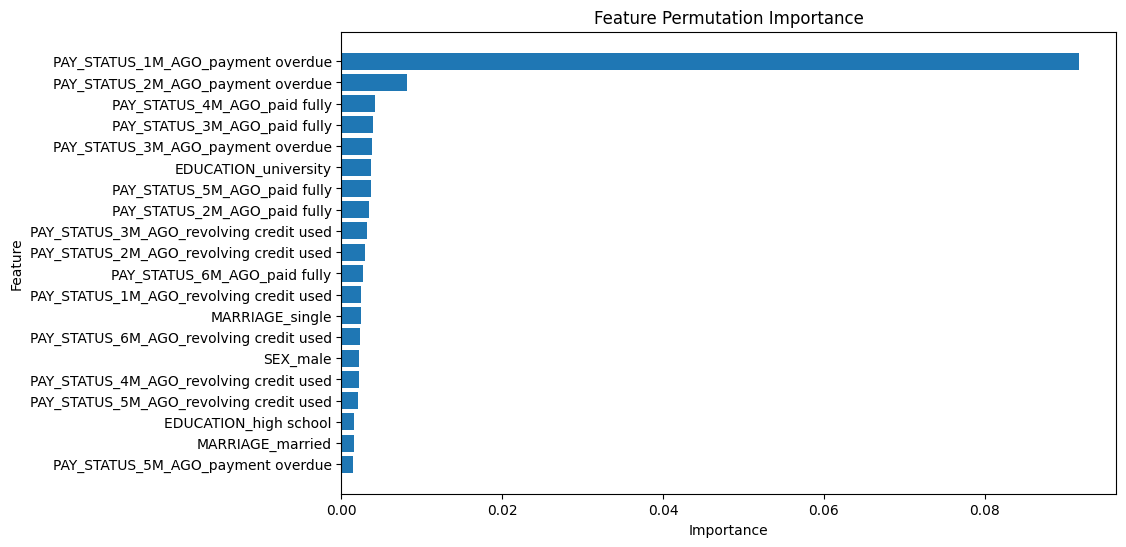

In [ ]:
plot_feat_permut_importance(svm_feat_permut_import_df)

In [ ]:
svm_perf, svm_orig_missing, svm_missing = measure_performance_decline(
    X_train_scaled, X_test_scaled, y_test, svm_classifier, svm_feat_permut_import_df,
    default_cc_imputation_scaled_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family
)


--- NEW ITERATION ---
Removing feature:  PAY_STATUS_1M_AGO_payment overdue
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used']
Original feat removed so far:  ['PAY_STATUS_1M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_STATUS_2M_AGO_payment overdue
Removing related features:  ['PAY_STATUS_2M_AGO_paid fully', 'PAY_STATUS_2M_AGO_payment overdue', 'PAY_STATUS_2M_AGO_revolving credit used']
Original feat removed so far:  ['PAY_STATUS_1M_AGO', 'PAY_STATUS_2M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_STATUS_4M_AGO_paid fully
Removing related features:  ['PAY_STATUS_4M_AGO_paid fully', 'PAY_STATUS_4M_AGO_payment overdue', 'PAY_STATUS_4M_AGO_revolving credit used']
Original feat removed so far:  ['PAY_STATUS_1M_AGO', 'PAY_STATUS_2M_AGO', 'PAY_STATUS_4M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_STATUS_3M_AGO_paid fully
Removing related features:  ['PAY_STATUS_3M_AGO_paid fully', 

In [ ]:
svm_perf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0   750  3853  820   577      47.77   56.52        82.45     76.72     51.78   
1   615  3976  697   712      46.88   46.35        85.08     76.52     46.61   
2   485  4170  503   842      49.09   36.55        89.24     77.58     41.90   
3   434  4251  422   893      50.70   32.71        90.97     78.08     39.76   
4   347  4390  283   980      55.08   26.15        93.94     78.95     35.46   
5   331  4410  263   996      55.72   24.94        94.37     79.02     34.46   
6   134  4597   76  1193      63.81   10.10        98.37     78.85     17.44   
7    12  4662   11  1315      52.17    0.90        99.76     77.90      1.78   
8    11  4663   10  1316      52.38    0.83        99.79     77.90      1.63   
9    11  4663   10  1316      52.38    0.83        99.79     77.90      1.63   
10   11  4663   10  1316      52.38    0.83        99.79     77.90      1.63   
11   11  4663   10  1316      52.38    0.83        99.79     77.90      1.63   
12    9  4666    7  1318      56.25    0.68        99.85     77.92      1.34   
13    2  4672    1  1325      66.67    0.15        99.98     77.90      0.30   
14    0  4672    1  1327       0.00    0.00        99.98     77.87      0.00   
15    0  4672    1  1327       0.00    0.00        99.98     77.87      0.00   
16    0  4672    1  1327       0.00    0.00        99.98     77.87      0.00   
17    0  4672    1  1327       0.00    0.00        99.98     77.87      0.00   
18    0  4672    1  1327       0.00    0.00        99.98     77.87      0.00   
19    0  4672    1  1327       0.00    0.00        99.98     77.87      0.00   
20    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   

    balanced_accuracy  num_feat_missing  \
0               69.49                 0   
1               65.71                 1   
2               62.89                 2   
3               61.84                 3   
4               60.05                 4   
5               59.66                 5   
6               54.24                 6   
7               50.33                 7   
8               50.31                 8   
9               50.31                 9   
10              50.31                10   
11              50.31                11   
12              50.26                12   
13              50.06                13   
14              49.99                14   
15              49.99                15   
16              49.99                16   
17              49.99                17   
18              49.99                18   
19              49.99                19   
20              50.00                20   

                                              imputed  
0                                                      
1   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
2   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
3   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
4   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
5   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
6   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
7   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
8   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
9   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
10  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
11  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
12  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
13  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
14  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
15  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
16  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
17  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
18  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
19  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
20  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

svm_perf_mf, svm_orig_missing_mf, svm_missing_mf = measure_performance_decline(
    X_train_scaled, X_test_scaled, y_test, svm_classifier, svm_feat_permut_import_df,
    imputation_dict=None, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 13:34:35.939387

--- NEW ITERATION ---
Removing feature:  PAY_STATUS_1M_AGO_payment overdue
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used']
Nr. columns with nan:  3
Numerical columns:  ['LIMIT_BAL', 'AGE', 'BILL_AMT_1M_AGO', 'BILL_AMT_2M_AGO', 'BILL_AMT_3M_AGO', 'BILL_AMT_4M_AGO', 'BILL_AMT_5M_AGO', 'BILL_AMT_6M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO']
Categorical columns:  ['SEX_male', 'EDUCATION_high school', 'EDUCATION_others', 'EDUCATION_university', 'MARRIAGE_married', 'MARRIAGE_others', 'MARRIAGE_single', 'PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used', 'PAY_STATUS_2M_AGO_paid fully', 'PAY_STATUS_2M_AGO_payment overdue', 'PAY_

In [ ]:
svm_perf_mf

tp    tn    fp    fn  precision  recall  specificity  accuracy  f1_score  \
0   750  3853   820   577      47.77   56.52        82.45     76.72     51.78   
1   610  3969   704   717      46.42   45.97        84.93     76.32     46.19   
2   614  3644  1029   713      37.37   46.27        77.98     70.97     41.35   
3   481  4123   550   846      46.65   36.25        88.23     76.73     40.80   
4   269  4477   196  1058      57.85   20.27        95.81     79.10     30.02   
5   274  4470   203  1053      57.44   20.65        95.66     79.07     30.38   
6    74  4619    54  1253      57.81    5.58        98.84     78.22     10.17   
7     6  4668     5  1321      54.55    0.45        99.89     77.90      0.90   
8     3  4669     4  1324      42.86    0.23        99.91     77.87      0.45   
9     3  4669     4  1324      42.86    0.23        99.91     77.87      0.45   
10    3  4669     4  1324      42.86    0.23        99.91     77.87      0.45   
11    3  4669     4  1324      42.86    0.23        99.91     77.87      0.45   
12    4  4669     4  1323      50.00    0.30        99.91     77.88      0.60   
13    2  4672     1  1325      66.67    0.15        99.98     77.90      0.30   
14    0  4672     1  1327       0.00    0.00        99.98     77.87      0.00   
15    0  4672     1  1327       0.00    0.00        99.98     77.87      0.00   
16    0  4672     1  1327       0.00    0.00        99.98     77.87      0.00   
17    0  4672     1  1327       0.00    0.00        99.98     77.87      0.00   
18    0  4672     1  1327       0.00    0.00        99.98     77.87      0.00   
19    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
20    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   

    balanced_accuracy  num_feat_missing  \
0               69.49                 0   
1               65.45                 1   
2               62.12                 2   
3               62.24                 3   
4               58.04                 4   
5               58.15                 5   
6               52.21                 6   
7               50.17                 7   
8               50.07                 8   
9               50.07                 9   
10              50.07                10   
11              50.07                11   
12              50.11                12   
13              50.06                13   
14              49.99                14   
15              49.99                15   
16              49.99                16   
17              49.99                17   
18              49.99                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
2   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
3   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
4   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
5   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
6   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
7   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
8   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
9   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
10  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
11  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
12  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
13  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
14  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
15  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
16  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
17  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
18  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
19  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
20  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...

In [ ]:
svm_perf_temp, svm_orig_missing_temp, svm_missing_temp = measure_temporal_performance_decline(
    X_train_scaled, X_test_scaled, y_test, svm_classifier, svm_feat_permut_import_df,
    default_cc_timeline_vars_family,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family, log_info=True
)


--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  45
length removed:  0

Removing feature:  PAY_STATUS_1M_AGO_payment overdue
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_payment overdue
Removing related features:  []
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Columns with zero variance, i.e. imputed:
                                    feature  variance
2                           BILL_AMT_1M_AGO       0.0
8                            PAY_AMT_1M_AGO       0.0
14                     

In [ ]:
svm_perf_temp

tp    tn    fp   fn  precision  recall  specificity  accuracy  f1_score  \
0   750  3853   820  577      47.77   56.52        82.45     76.72     51.78   
1  1327     0  4673    0      22.12  100.00         0.00     22.12     36.22   
2  1327     0  4673    0      22.12  100.00         0.00     22.12     36.22   
3  1327     0  4673    0      22.12  100.00         0.00     22.12     36.22   
4  1327     0  4673    0      22.12  100.00         0.00     22.12     36.22   
5  1327     0  4673    0      22.12  100.00         0.00     22.12     36.22   
6  1327     0  4673    0      22.12  100.00         0.00     22.12     36.22   

   balanced_accuracy  num_feat_missing  \
0              69.49                 0   
1              50.00                 4   
2              50.00                 8   
3              50.00                12   
4              50.00                16   
5              50.00                17   
6              50.00                21   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

svm_perf_temp_mf, svm_orig_missing_temp_mf, svm_missing_temp_mf = measure_temporal_performance_decline(
    X_train_scaled, X_test_scaled, y_test, svm_classifier, svm_feat_permut_import_df,
    default_cc_timeline_vars_family, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars, log_info=True
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 13:43:50.532086

--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  45
length removed:  0

Removing feature:  PAY_STATUS_1M_AGO_payment overdue
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_payment overdue
Removing related features:  []
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Nr. columns with nan:  6
Numerical columns:  ['LIMIT_BAL', 'AGE', 'BILL_AMT_1M_AGO', 'BILL_AMT_2M_AGO', 'BILL_AMT_3M_AGO', 'BILL_AMT_4M_AGO', 'BILL_AMT_5M_AGO', 'BILL_AMT_6M_AGO', 'PAY_AMT_1M_AGO', 'P

In [ ]:
svm_perf_temp_mf

tp    tn    fp    fn  precision  recall  specificity  accuracy  f1_score  \
0  750  3853   820   577      47.77   56.52        82.45     76.72     51.78   
1  609  3971   702   718      46.45   45.89        84.98     76.33     46.17   
2  612  3647  1026   715      37.36   46.12        78.04     70.98     41.28   
3  481  4123   550   846      46.65   36.25        88.23     76.73     40.80   
4  262  4483   190  1065      57.96   19.74        95.93     79.08     29.45   
5  270  4479   194  1057      58.19   20.35        95.85     79.15     30.15   
6   63  4628    45  1264      58.33    4.75        99.04     78.18      8.78   

   balanced_accuracy  num_feat_missing  \
0              69.49                 0   
1              65.44                 4   
2              62.08                 8   
3              62.24                12   
4              57.84                16   
5              58.10                17   
6              51.89                21   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

##**Logistic Regression**##

**Data pre-processing:** It is highly recommended to mitigate as much as possible the presence of multicolinearity between features before applying Logistic regression.

In [ ]:
present_features = list(X_train_scaled.columns) + ['Target']
filtered_default_cc_dist_corr = default_cc_dist_corr[present_features]
filtered_default_cc_dist_corr = filtered_default_cc_dist_corr[filtered_default_cc_dist_corr.index.isin(present_features)]
filtered_feat = filter_out_intercorrelated_features(filtered_default_cc_dist_corr, 'Target', 0.8)

appended feature:  PAY_DELAY_1M_AGO
eliminated feature:  PAY_STATUS_1M_AGO_payment overdue 0.9603579952219865
appended feature:  PAY_DELAY_2M_AGO
eliminated feature:  PAY_STATUS_2M_AGO_payment overdue 0.9974995350422445
appended feature:  PAY_DELAY_3M_AGO
eliminated feature:  PAY_STATUS_3M_AGO_payment overdue 0.9984579871108346
appended feature:  PAY_DELAY_4M_AGO
eliminated feature:  PAY_STATUS_4M_AGO_payment overdue 0.9977613943439647
appended feature:  PAY_DELAY_5M_AGO
eliminated feature:  PAY_STATUS_5M_AGO_payment overdue 0.9973790509201896
appended feature:  PAY_DELAY_6M_AGO
eliminated feature:  PAY_STATUS_6M_AGO_payment overdue 0.9980350932435607
appended feature:  PAY_STATUS_1M_AGO_revolving credit used
eliminated feature:  PAY_STATUS_2M_AGO_revolving credit used 0.8754640075186755
appended feature:  LIMIT_BAL
appended feature:  PAY_AMT_1M_AGO
appended feature:  PAY_AMT_2M_AGO
appended feature:  PAY_STATUS_3M_AGO_revolving credit used
appended feature:  PAY_AMT_3M_AGO
appended fe

In [ ]:
lr_X_train = X_train_scaled[filtered_feat]
lr_X_test = X_test_scaled[filtered_feat]
print('Nr features for LR: ', len(lr_X_train.columns))

Nr features for LR:  33


In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  lr_param_grid = {
      'C': [0.1, 1, 2, 5, 10, 20],  # Regularization strength
      'penalty': ['l2', 'l1', 'elasticnet'],  # Regularization type
      'solver': ['liblinear', 'saga']  # Algorithm to use in the optimization problem
  }
else:
  lr_param_grid = {
      'C': [5],
      'penalty': ['l1'],
      'solver': ['saga']
  }

lr_classifier = LogisticRegression(class_weight='balanced', random_state=RANDOM_STATE)
lr_grid_search, lr_best_model, lr_best_params = hyperparameter_tuning(
    lr_classifier, lr_param_grid, 3, 3, 'f1', lr_X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-18 11:11:07.365736

Nested Cross-validation Results:
Individual scores: [0.54041688 0.53128259 0.52655889]
Average nested CV score: 0.533 (+/- 0.012)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'C': 5, 'penalty': 'l1', 'solver': 'saga'}

Best Model Performance:
Best CV score: 0.533
2025-01-18 11:11:14.322324

Execution time: 0.12 minutes


```
Starting hyperparameter tuning at: 2025-01-17 17:34:41.576567

Nested Cross-validation Results:
Individual scores: [0.54027954 0.5286757  0.52702007]
Average nested CV score: 0.532 (+/- 0.012)

Fitting final model on entire dataset...
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters: {'C': 5, 'penalty': 'l1', 'solver': 'saga'}

Best Model Performance:
Best CV score: 0.533
2025-01-17 17:35:06.610696

Execution time: 0.42 minutes
```

In [ ]:
lr_classifier, train_pred, test_pred = apply_model(lr_best_model, lr_X_train, y_train, lr_X_test, y_test)
lr_feat_permut_import_df = analyze_feat_permut_import(lr_classifier, lr_X_train, y_train, scoring_metric="f1")
lr_feat_permut_import_df[lr_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
0                          PAY_DELAY_1M_AGO    0.116414  0.003383
7                                 LIMIT_BAL    0.018203  0.001994
29                          BILL_AMT_1M_AGO    0.008948  0.001676
2                          PAY_DELAY_3M_AGO    0.008356  0.000758
22             PAY_STATUS_1M_AGO_paid fully    0.006985  0.000775
3                          PAY_DELAY_4M_AGO    0.004286  0.001134
4                          PAY_DELAY_5M_AGO    0.004243  0.001061
19             PAY_STATUS_2M_AGO_paid fully    0.003629  0.000442
17  PAY_STATUS_6M_AGO_revolving credit used    0.002318  0.000730
18             PAY_STATUS_3M_AGO_paid fully    0.002005  0.000311
24                         EDUCATION_others    0.001559  0.000500
26                                 SEX_male    0.001508  0.000753
8                            PAY_AMT_1M_AGO    0.001197  0.000628
9                            PAY_AMT_2M_AGO    0.001012  0.000846
28                          MARRIAGE_single    0.000907  0.000900
20             PAY_STATUS_4M_AGO_paid fully    0.000754  0.000386
21             PAY_STATUS_5M_AGO_paid fully    0.000702  0.000159
16  PAY_STATUS_5M_AGO_revolving credit used    0.000671  0.000197
31                          BILL_AMT_6M_AGO    0.000657  0.000437
6   PAY_STATUS_1M_AGO_revolving credit used    0.000428  0.001426
32                          MARRIAGE_others    0.000355  0.000258
23             PAY_STATUS_6M_AGO_paid fully    0.000308  0.000103
30                                      AGE    0.000114  0.000437
27                    EDUCATION_high school   -0.000007  0.000145
15                           PAY_AMT_6M_AGO   -0.000058  0.000494
5                          PAY_DELAY_6M_AGO   -0.000064  0.000302
1                          PAY_DELAY_2M_AGO   -0.000112  0.000080
13                           PAY_AMT_4M_AGO   -0.000166  0.000299
25                     EDUCATION_university   -0.000333  0.000341
11                           PAY_AMT_3M_AGO   -0.000424  0.000291
12  PAY_STATUS_4M_AGO_revolving credit used   -0.000461  0.000343
10  PAY_STATUS_3M_AGO_revolving credit used   -0.000485  0.000430
14                           PAY_AMT_5M_AGO   -0.000818  0.000451

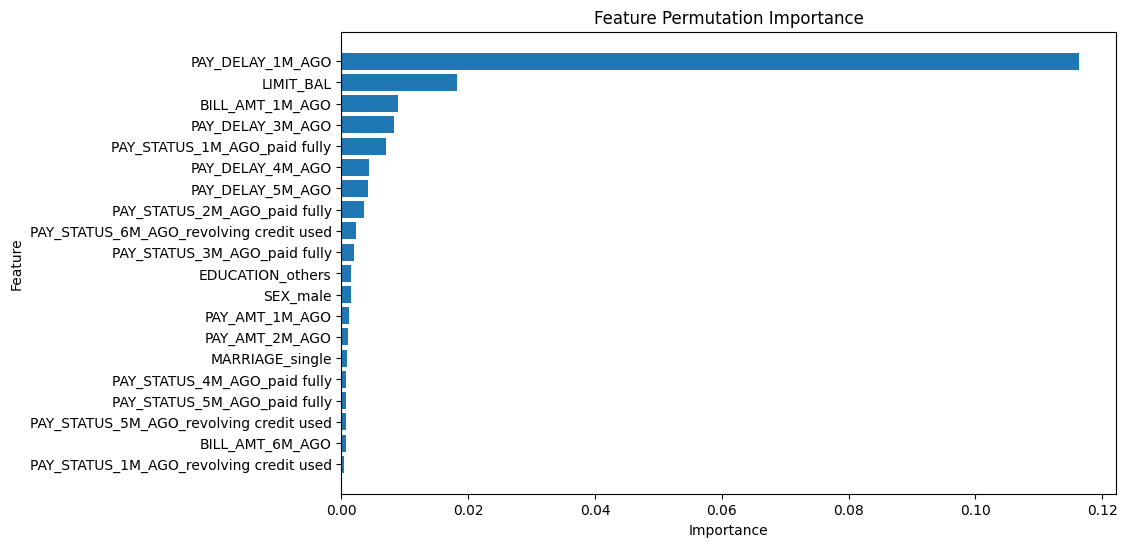

In [ ]:
plot_feat_permut_importance(lr_feat_permut_import_df)

In [ ]:
lr_perf, lr_orig_missing, lr_missing = measure_performance_decline(
    lr_X_train, lr_X_test, y_test, lr_classifier, lr_feat_permut_import_df,
    default_cc_imputation_scaled_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family
)


--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO']

--- NEW ITERATION ---
Removing feature:  LIMIT_BAL
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL']

--- NEW ITERATION ---
Removing feature:  BILL_AMT_1M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_3M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M_AGO', 'PAY_DELAY_3M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_revolving credit used']
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_STATUS_1M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_4M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M_AGO', 'PAY_DELAY_3M_AGO', 'PAY

In [ ]:
lr_perf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0   773  3802  871   554      47.02   58.25        81.36     76.25     52.04   
1   480  4187  486   847      49.69   36.17        89.60     77.78     41.87   
2   441  4225  448   886      49.61   33.23        90.41     77.77     39.80   
3   409  4230  443   918      48.00   30.82        90.52     77.32     37.54   
4   332  4336  337   995      49.63   25.02        92.79     77.80     33.27   
5   314  4436  237  1013      56.99   23.66        94.93     79.17     33.44   
6   243  4494  179  1084      57.58   18.31        96.17     78.95     27.79   
7    68  4627   46  1259      59.65    5.12        99.02     78.25      9.44   
8    70  4624   49  1257      58.82    5.28        98.95     78.23      9.68   
9     0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
10    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
11    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
12    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
13    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
14    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
15    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
16    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
17    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
18    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
19    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
20    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   

    balanced_accuracy  num_feat_missing  \
0               69.81                 0   
1               62.89                 1   
2               61.82                 2   
3               60.67                 3   
4               58.90                 4   
5               59.30                 5   
6               57.24                 6   
7               52.07                 7   
8               52.11                 8   
9               50.00                 9   
10              50.00                10   
11              50.00                11   
12              50.00                12   
13              50.00                13   
14              50.00                14   
15              50.00                15   
16              50.00                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2           ['PAY_DELAY_1M_AGO', 'LIMIT_BAL'] imputed  
3   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
4   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
5   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
6   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
7   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
8   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
9   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
10  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
11  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
12  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
13  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
14  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
15  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
16  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
17  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
18  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
19  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
20  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...

In [ ]:
lr_X_train.columns

Index(['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO',
       'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO',
       'PAY_STATUS_1M_AGO_revolving credit used', 'LIMIT_BAL',
       'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO',
       'PAY_STATUS_3M_AGO_revolving credit used', 'PAY_AMT_3M_AGO',
       'PAY_STATUS_4M_AGO_revolving credit used', 'PAY_AMT_4M_AGO',
       'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO',
       'PAY_STATUS_5M_AGO_revolving credit used',
       'PAY_STATUS_6M_AGO_revolving credit used',
       'PAY_STATUS_3M_AGO_paid fully', 'PAY_STATUS_2M_AGO_paid fully',
       'PAY_STATUS_4M_AGO_paid fully', 'PAY_STATUS_5M_AGO_paid fully',
       'PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_6M_AGO_paid fully',
       'EDUCATION_others', 'EDUCATION_university', 'SEX_male',
       'EDUCATION_high school', 'MARRIAGE_single', 'BILL_AMT_1M_AGO', 'AGE',
       'BILL_AMT_6M_AGO', 'MARRIAGE_others'],
      dtype='object')

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

lr_default_cc_cat_vars = [col for col in lr_X_train.columns if col in default_cc_cat_vars]

lr_perf_mf, lr_orig_missing_mf, lr_missing_mf = measure_performance_decline(
    lr_X_train, lr_X_test, y_test, lr_classifier, lr_feat_permut_import_df,
    imputation_dict=None, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=lr_default_cc_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 13:46:26.001195

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Nr. columns with nan:  1
Numerical columns:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO', 'LIMIT_BAL', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'BILL_AMT_1M_AGO', 'AGE', 'BILL_AMT_6M_AGO']
Categorical columns:  ['PAY_STATUS_1M_AGO_revolving credit used', 'PAY_STATUS_3M_AGO_revolving credit used', 'PAY_STATUS_4M_AGO_revolving credit used', 'PAY_STATUS_5M_AGO_revolving credit used', 'PAY_STATUS_6M_AGO_revolving credit used', 'PAY_STATUS_3M_AGO_paid fully', 'PAY_STATUS_2M_AGO_paid fully', 'PAY_STATUS_4M_AGO_paid fully', 'PAY_STATUS_5M_AGO_paid fully', 'PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_6M_AGO_paid fully', 'EDUCATION_others', 'EDUCATION_university', 'SEX_male', 'EDUCATION_high school', 'MARRIAGE_single', 'MARRIAGE_others']
Column imputed:  PAY_DELAY_1M_AGO

In [ ]:
lr_perf_mf

tp    tn   fp   fn  precision  recall  specificity  accuracy  f1_score  \
0   773  3802  871  554      47.02   58.25        81.36     76.25     52.04   
1   710  3726  947  617      42.85   53.50        79.73     73.93     47.59   
2   698  3807  866  629      44.63   52.60        81.47     75.08     48.29   
3   654  3905  768  673      45.99   49.28        83.57     75.98     47.58   
4   651  3908  765  676      45.97   49.06        83.63     75.98     47.47   
5   634  3969  704  693      47.38   47.78        84.93     76.72     47.58   
6   617  3991  682  710      47.50   46.50        85.41     76.80     46.99   
7   599  4024  649  728      48.00   45.14        86.11     77.05     46.52   
8   571  4092  581  756      49.57   43.03        87.57     77.72     46.07   
9   550  4104  569  777      49.15   41.45        87.82     77.57     44.97   
10  494  4233  440  833      52.89   37.23        90.58     78.78     43.70   
11  495  4236  437  832      53.11   37.30        90.65     78.85     43.82   
12  474  4275  398  853      54.36   35.72        91.48     79.15     43.11   
13  488  4254  419  839      53.80   36.77        91.03     79.03     43.69   
14  491  4255  418  836      54.02   37.00        91.05     79.10     43.92   
15  480  4269  404  847      54.30   36.17        91.35     79.15     43.42   
16  489  4244  429  838      53.27   36.85        90.82     78.88     43.56   
17  478  4253  420  849      53.23   36.02        91.01     78.85     42.97   
18  474  4262  411  853      53.56   35.72        91.20     78.93     42.86   
19  470  4271  402  857      53.90   35.42        91.40     79.02     42.75   
20  471  4269  404  856      53.83   35.49        91.35     79.00     42.78   

    balanced_accuracy  num_feat_missing  \
0               69.81                 0   
1               66.62                 1   
2               67.03                 2   
3               66.42                 3   
4               66.34                 4   
5               66.36                 5   
6               65.95                 6   
7               65.63                 7   
8               65.30                 8   
9               64.64                 9   
10              63.91                10   
11              63.98                11   
12              63.60                12   
13              63.90                13   
14              64.03                14   
15              63.76                15   
16              63.83                16   
17              63.52                17   
18              63.46                18   
19              63.41                19   
20              63.42                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2           ['PAY_DELAY_1M_AGO', 'LIMIT_BAL'] imputed  
3   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
4   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
5   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
6   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
7   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
8   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
9   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
10  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
11  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
12  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
13  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
14  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
15  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
16  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
17  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
18  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
19  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
20  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...

In [ ]:
lr_perf_temp, lr_orig_missing_temp, lr_missing_temp = measure_temporal_performance_decline(
    lr_X_train, lr_X_test, y_test, lr_classifier, lr_feat_permut_import_df,
    default_cc_timeline_vars_family,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family, log_info=True
)


--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  33
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Columns with zero variance, i.e. imputed:
                                    feature  variance
0                          PAY_DELAY_1M_AGO       0.0
6   PAY_STATUS_1M_AGO_revolving credit used       0.0
8                            PAY_AMT_1M_AGO       0.0
22             PAY_STATUS_1M_AGO_paid fully       0.0
29                          BILL_AMT_1M_AGO       0.0
Original feat re

In [ ]:
lr_perf_temp

tp    tn    fp    fn  precision  recall  specificity  accuracy  f1_score  \
0   773  3802   871   554      47.02   58.25        81.36     76.25     52.04   
1  1327     0  4673     0      22.12  100.00         0.00     22.12     36.22   
2     0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
3     0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
4     0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
5     0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
6     0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
7     0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   

   balanced_accuracy  num_feat_missing  \
0              69.81                 0   
1              50.00                 4   
2              50.00                 5   
3              50.00                 8   
4              50.00                11   
5              50.00                14   
6              50.00                17   
7              50.00                21   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
7  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

lr_perf_temp_mf, lr_orig_missing_temp_mf, lr_missing_temp_mf = measure_temporal_performance_decline(
    lr_X_train, lr_X_test, y_test, lr_classifier, lr_feat_permut_import_df,
    default_cc_timeline_vars_family, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=lr_default_cc_cat_vars, log_info=True
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 13:50:49.653904

--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  33
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Nr. columns with nan:  5
Numerical columns:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO', 'LIMIT_BAL', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'BILL_AMT_1M_AGO', 'AGE', 'BILL_AMT_6M_AGO']
Categorical columns:  [

In [ ]:
lr_perf_temp_mf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0  773  3802  871   554      47.02   58.25        81.36     76.25     52.04   
1  623  3919  754   704      45.24   46.95        83.86     75.70     46.08   
2  660  3891  782   667      45.77   49.74        83.27     75.85     47.67   
3  588  4063  610   739      49.08   44.31        86.95     77.52     46.57   
4  579  4010  663   748      46.62   43.63        85.81     76.48     45.08   
5  551  4096  577   776      48.85   41.52        87.65     77.45     44.89   
6  148  4565  108  1179      57.81   11.15        97.69     78.55     18.70   
7    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   

   balanced_accuracy  num_feat_missing  \
0              69.81                 0   
1              65.41                 4   
2              66.50                 5   
3              65.63                 8   
4              64.72                11   
5              64.59                14   
6              54.42                17   
7              50.00                21   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
7  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

# **Models optimized for Balanced Accuracy**

## **Decision Tree**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  dt2_param_grid = {
      'max_depth': [2, 3, 4, 5, None],
      'min_samples_split': [0.2, 0.1, 0.05, 0.01, 0.005, 0.001, 2],
      'min_samples_leaf': [0.1, 0.05, 0.01, 0.005, 0.001, 1]
  }
else:
  # best model
  dt2_param_grid = {
      'max_depth': [None],
      'min_samples_split': [0.05],
      'min_samples_leaf': [0.005]
  }

dt2_classifier = DecisionTreeClassifier(class_weight='balanced', random_state=RANDOM_STATE)
dt2_grid_search, dt2_best_model, dt2_best_params = hyperparameter_tuning(
    dt2_classifier, dt2_param_grid, 3, 3, 'balanced_accuracy', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-18 11:14:56.593597

Nested Cross-validation Results:
Individual scores: [0.70393528 0.70884231 0.69546073]
Average nested CV score: 0.703 (+/- 0.011)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'max_depth': None, 'min_samples_leaf': 0.005, 'min_samples_split': 0.05}

Best Model Performance:
Best CV score: 0.703
2025-01-18 11:14:57.800271

Execution time: 0.02 minutes


```
Starting hyperparameter tuning at: 2025-01-17 17:35:06.618900

Nested Cross-validation Results:
Individual scores: [0.70393528 0.70156206 0.69318996]
Average nested CV score: 0.700 (+/- 0.009)

Fitting final model on entire dataset...
Fitting 3 folds for each of 210 candidates, totalling 630 fits
Best parameters: {'max_depth': None, 'min_samples_leaf': 0.005, 'min_samples_split': 0.05}

Best Model Performance:
Best CV score: 0.703
2025-01-17 17:35:52.503848

Execution time: 0.76 minutes
```

In [ ]:
dt2_classifier, dt2_train_pred, dt2_test_pred = apply_model(dt2_best_model, X_train, y_train, X_test, y_test)
dt2_feat_permut_import_df = analyze_feat_permut_import(dt2_classifier, X_train, y_train, scoring_metric="balanced_accuracy")
dt2_feat_permut_import_df[dt2_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
14                   PAY_DELAY_1M_AGO    0.079606  0.002139
17                   PAY_DELAY_4M_AGO    0.024620  0.000753
8                      PAY_AMT_1M_AGO    0.012739  0.001213
36       PAY_STATUS_4M_AGO_paid fully    0.010085  0.000764
9                      PAY_AMT_2M_AGO    0.009975  0.001357
40  PAY_STATUS_5M_AGO_payment overdue    0.007953  0.001197
15                   PAY_DELAY_2M_AGO    0.007506  0.000507
10                     PAY_AMT_3M_AGO    0.004792  0.000448
42       PAY_STATUS_6M_AGO_paid fully    0.004228  0.000258
2                     BILL_AMT_1M_AGO    0.003904  0.000792
0                           LIMIT_BAL    0.003512  0.000827
11                     PAY_AMT_4M_AGO    0.003279  0.000364

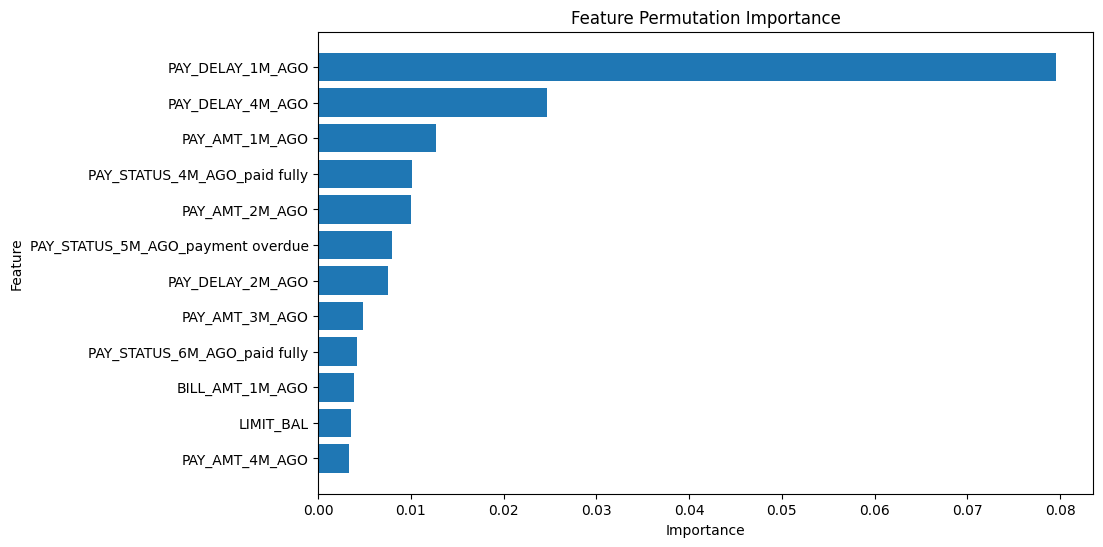

In [ ]:
plot_feat_permut_importance(dt2_feat_permut_import_df)

In [ ]:
dt2_perf, dt2_orig_missing, dt2_missing = measure_performance_decline(
    X_train, X_test, y_test, dt2_classifier, dt2_feat_permut_import_df,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family
)


--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_4M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_AMT_1M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_AMT_1M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_STATUS_4M_AGO_paid fully
Removing related features:  ['PAY_STATUS_4M_AGO_paid fully', 'PAY_STATUS_4M_AGO_payment overdue', 'PAY_STATUS_4M_AGO_revolving credit used']
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_AMT_1M_AGO', 'PAY_STATUS_4M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_AMT_2M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_AMT_1M_AGO', 'PAY_STATUS_4M_AGO', 'PAY_AMT_2M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_STATUS_5M_AGO_payment overdue
Removing related features:

In [ ]:
dt2_perf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0   777  3742  931   550      45.49   58.55        80.08     75.32     51.20   
1   552  3961  712   775      43.67   41.60        84.76     75.22     42.61   
2   350  4174  499   977      41.22   26.38        89.32     75.40     32.17   
3   325  4250  423  1002      43.45   24.49        90.95     76.25     31.33   
4   325  4250  423  1002      43.45   24.49        90.95     76.25     31.33   
5     0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
6     0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
7     0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
8     0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
9     0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
10    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
11    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
12    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
13    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
14    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
15    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
16    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
17    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
18    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
19    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
20    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   

    balanced_accuracy  num_feat_missing  \
0               69.32                 0   
1               63.18                 1   
2               57.85                 2   
3               57.72                 3   
4               57.72                 4   
5               50.00                 5   
6               50.00                 6   
7               50.00                 7   
8               50.00                 8   
9               50.00                 9   
10              50.00                10   
11              50.00                11   
12              50.00                12   
13              50.00                13   
14              50.00                14   
15              50.00                15   
16              50.00                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2    ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO'] imputed  
3   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
4   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
5   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
6   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
7   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
8   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
9   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
10  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
11  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
12  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
13  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
14  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
15  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
16  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
17  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
18  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
19  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
20  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

dt2_perf_mf, dt2_orig_missing_mf, dt2_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, dt2_classifier, dt2_feat_permut_import_df,
    imputation_dict=None, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 13:52:20.273841

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Nr. columns with nan:  1
Numerical columns:  ['LIMIT_BAL', 'AGE', 'BILL_AMT_1M_AGO', 'BILL_AMT_2M_AGO', 'BILL_AMT_3M_AGO', 'BILL_AMT_4M_AGO', 'BILL_AMT_5M_AGO', 'BILL_AMT_6M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO']
Categorical columns:  ['SEX_male', 'EDUCATION_high school', 'EDUCATION_others', 'EDUCATION_university', 'MARRIAGE_married', 'MARRIAGE_others', 'MARRIAGE_single', 'PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used', 'PAY_STATUS_2M_AGO_paid fully', 'PAY_STATUS_2M_AGO_payment overdue', 'PAY_STATUS_2M_AGO_revolving credit used', 'PAY_STATUS_3M_AGO_paid fully', 'PAY_STATUS_3M_AGO_payment overdue', 'PAY_STATUS_3M_AGO_revolving credit used', 'PAY_STA

In [ ]:
dt2_perf_mf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0   777  3742  931   550      45.49   58.55        80.08     75.32     51.20   
1   682  3768  905   645      42.97   51.39        80.63     74.17     46.81   
2   652  3827  846   675      43.52   49.13        81.90     74.65     46.16   
3   624  3899  774   703      44.64   47.02        83.44     75.38     45.80   
4   634  3856  817   693      43.69   47.78        82.52     74.83     45.64   
5   610  3924  749   717      44.89   45.97        83.97     75.57     45.42   
6   590  3957  716   737      45.18   44.46        84.68     75.78     44.82   
7   252  4254  419  1075      37.56   18.99        91.03     75.10     25.23   
8   180  4389  284  1147      38.79   13.56        93.92     76.15     20.10   
9   147  4492  181  1180      44.82   11.08        96.13     77.32     17.76   
10  142  4499  174  1185      44.94   10.70        96.28     77.35     17.29   
11  122  4548  125  1205      49.39    9.19        97.33     77.83     15.50   
12  119  4554  119  1208      50.00    8.97        97.45     77.88     15.21   
13  119  4554  119  1208      50.00    8.97        97.45     77.88     15.21   
14  119  4554  119  1208      50.00    8.97        97.45     77.88     15.21   
15  119  4554  119  1208      50.00    8.97        97.45     77.88     15.21   
16  119  4554  119  1208      50.00    8.97        97.45     77.88     15.21   
17  119  4554  119  1208      50.00    8.97        97.45     77.88     15.21   
18  136  4561  112  1191      54.84   10.25        97.60     78.28     17.27   
19   80  4591   82  1247      49.38    6.03        98.25     77.85     10.75   
20   74  4618   55  1253      57.36    5.58        98.82     78.20     10.16   

    balanced_accuracy  num_feat_missing  \
0               69.32                 0   
1               66.01                 1   
2               65.51                 2   
3               65.23                 3   
4               65.15                 4   
5               64.97                 5   
6               64.57                 6   
7               55.01                 7   
8               53.74                 8   
9               53.60                 9   
10              53.49                10   
11              53.26                11   
12              53.21                12   
13              53.21                13   
14              53.21                14   
15              53.21                15   
16              53.21                16   
17              53.21                17   
18              53.93                18   
19              52.14                19   
20              52.20                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2    ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO'] imputed  
3   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
4   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
5   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
6   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
7   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
8   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
9   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
10  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
11  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
12  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
13  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
14  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
15  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
16  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
17  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
18  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
19  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
20  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...

In [ ]:
dt2_perf_temp, dt2_orig_missing_temp, dt2_missing_temp = measure_temporal_performance_decline(
    X_train, X_test, y_test, dt2_classifier, dt2_feat_permut_import_df,
    default_cc_timeline_vars_family,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family, log_info=True
)


--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  45
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_payment overdue
Removing related features:  []
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Columns with zero variance, i.e. imputed:
                                    feature  variance
2                           BILL_AMT_1M_AGO       0.0
8                            PAY_AMT_1M_AGO       0.0
14                         PAY_DELAY_1M_

In [ ]:
dt2_perf_temp

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0  777  3742  931   550      45.49   58.55        80.08     75.32     51.20   
1  482  4179  494   845      49.39   36.32        89.43     77.68     41.86   
2  280  4392  281  1047      49.91   21.10        93.99     77.87     29.66   
3    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
4    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
5    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   

   balanced_accuracy  num_feat_missing  \
0              69.32                 0   
1              62.88                 4   
2              57.54                 8   
3              50.00                12   
4              50.00                16   
5              50.00                20   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

dt2_perf_temp_mf, dt2_orig_missing_temp_mf, dt2_missing_temp_mf = measure_temporal_performance_decline(
    X_train, X_test, y_test, dt2_classifier, dt2_feat_permut_import_df,
    default_cc_timeline_vars_family, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars, log_info=True
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 13:58:51.276011

--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  45
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_payment overdue
Removing related features:  []
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Nr. columns with nan:  6
Numerical columns:  ['LIMIT_BAL', 'AGE', 'BILL_AMT_1M_AGO', 'BILL_AMT_2M_AGO', 'BILL_AMT_3M_AGO', 'BILL_AMT_4M_AGO', 'BILL_AMT_5M_AGO', 'BILL_AMT_6M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', '

In [ ]:
dt2_perf_temp_mf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0  777  3742  931   550      45.49   58.55        80.08     75.32     51.20   
1  611  3955  718   716      45.97   46.04        84.64     76.10     46.01   
2  587  4007  666   740      46.85   44.24        85.75     76.57     45.50   
3  302  4418  255  1025      54.22   22.76        94.54     78.67     32.06   
4   39  4625   48  1288      44.83    2.94        98.97     77.73      5.52   
5   69  4615   58  1258      54.33    5.20        98.76     78.07      9.49   

   balanced_accuracy  num_feat_missing  \
0              69.32                 0   
1              65.34                 4   
2              64.99                 8   
3              58.65                12   
4              50.96                16   
5              51.98                20   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

## **Random Forests**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  rf2_param_grid = {
      'n_estimators': [100, 200, 300],
      'max_features': ['sqrt', 0.5, 1.0],
      'max_depth': [3, 5, None],
      'min_samples_split': [0.01, 0.005, 0.001, 2],
      'min_samples_leaf': [0.01, 0.005, 0.001, 1]
  }
else:
  # best model
  rf2_param_grid = {
    'n_estimators': [300],
    'max_features': ['sqrt'],
    'min_samples_split': [0.01],
    'min_samples_leaf': [0.001],
    'max_depth': [None],
}

rf2_classifier = RandomForestClassifier(class_weight='balanced', random_state=RANDOM_STATE)
rf2_grid_search, rf2_best_model, rf2_best_params = hyperparameter_tuning(
    rf2_classifier, rf2_param_grid, 3, 3, 'balanced_accuracy', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-18 11:21:05.754450

Nested Cross-validation Results:
Individual scores: [0.72581321 0.71498853 0.70907537]
Average nested CV score: 0.717 (+/- 0.014)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 0.001, 'min_samples_split': 0.01, 'n_estimators': 300}

Best Model Performance:
Best CV score: 0.717
2025-01-18 11:21:39.459423

Execution time: 0.56 minutes


```
Starting hyperparameter tuning at: 2025-01-17 23:44:16.159349

Nested Cross-validation Results:
Individual scores: [0.72345747 0.7130941  0.70859746]
Average nested CV score: 0.715 (+/- 0.012)

Fitting final model on entire dataset...
Fitting 3 folds for each of 432 candidates, totalling 1296 fits
Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 0.001, 'min_samples_split': 0.01, 'n_estimators': 300}

Best Model Performance:
Best CV score: 0.717
2025-01-18 01:30:56.781137

Execution time: 106.68 minutes

```

In [ ]:
rf2_classifier, rf2_train_pred, rf2_test_pred = apply_model(rf2_best_model, X_train, y_train, X_test, y_test)
rf2_feat_permut_import_df = analyze_feat_permut_import(rf2_classifier, X_train, y_train, scoring_metric="balanced_accuracy")
rf2_feat_permut_import_df[rf2_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
2                           BILL_AMT_1M_AGO    0.009967  0.000372
10                           PAY_AMT_3M_AGO    0.009092  0.000738
14                         PAY_DELAY_1M_AGO    0.008977  0.001234
8                            PAY_AMT_1M_AGO    0.007973  0.000998
11                           PAY_AMT_4M_AGO    0.007288  0.000923
6                           BILL_AMT_5M_AGO    0.006149  0.000666
9                            PAY_AMT_2M_AGO    0.006121  0.001313
0                                 LIMIT_BAL    0.005833  0.000234
13                           PAY_AMT_6M_AGO    0.004737  0.000391
3                           BILL_AMT_2M_AGO    0.003910  0.000242
4                           BILL_AMT_3M_AGO    0.003705  0.000430
7                           BILL_AMT_6M_AGO    0.003504  0.000558
12                           PAY_AMT_5M_AGO    0.002940  0.000496
29  PAY_STATUS_1M_AGO_revolving credit used    0.002206  0.000786
5                           BILL_AMT_4M_AGO    0.001622  0.000401
33             PAY_STATUS_3M_AGO_paid fully    0.001537  0.000227
1                                       AGE    0.001493  0.000330
42             PAY_STATUS_6M_AGO_paid fully    0.001338  0.000368
16                         PAY_DELAY_3M_AGO    0.001285  0.000200
34        PAY_STATUS_3M_AGO_payment overdue    0.001272  0.000289
40        PAY_STATUS_5M_AGO_payment overdue    0.001197  0.000425
18                         PAY_DELAY_5M_AGO    0.001183  0.000349
30             PAY_STATUS_2M_AGO_paid fully    0.001049  0.000202
37        PAY_STATUS_4M_AGO_payment overdue    0.000974  0.000455
17                         PAY_DELAY_4M_AGO    0.000920  0.000476
23                     EDUCATION_university    0.000811  0.000161
35  PAY_STATUS_3M_AGO_revolving credit used    0.000791  0.000175
44  PAY_STATUS_6M_AGO_revolving credit used    0.000783  0.000258
19                         PAY_DELAY_6M_AGO    0.000715  0.000175
32  PAY_STATUS_2M_AGO_revolving credit used    0.000676  0.000404
43        PAY_STATUS_6M_AGO_payment overdue    0.000618  0.000172
36             PAY_STATUS_4M_AGO_paid fully    0.000612  0.000289
27             PAY_STATUS_1M_AGO_paid fully    0.000545  0.000243
39             PAY_STATUS_5M_AGO_paid fully    0.000468  0.000339
20                                 SEX_male    0.000357  0.000181
21                    EDUCATION_high school    0.000323  0.000248
26                          MARRIAGE_single    0.000228  0.000227
41  PAY_STATUS_5M_AGO_revolving credit used    0.000194  0.000187
15                         PAY_DELAY_2M_AGO    0.000159  0.000412
22                         EDUCATION_others    0.000134  0.000042
24                         MARRIAGE_married    0.000074  0.000156
38  PAY_STATUS_4M_AGO_revolving credit used    0.000040  0.000298
31        PAY_STATUS_2M_AGO_payment overdue   -0.000161  0.000212
28        PAY_STATUS_1M_AGO_payment overdue   -0.000372  0.001090

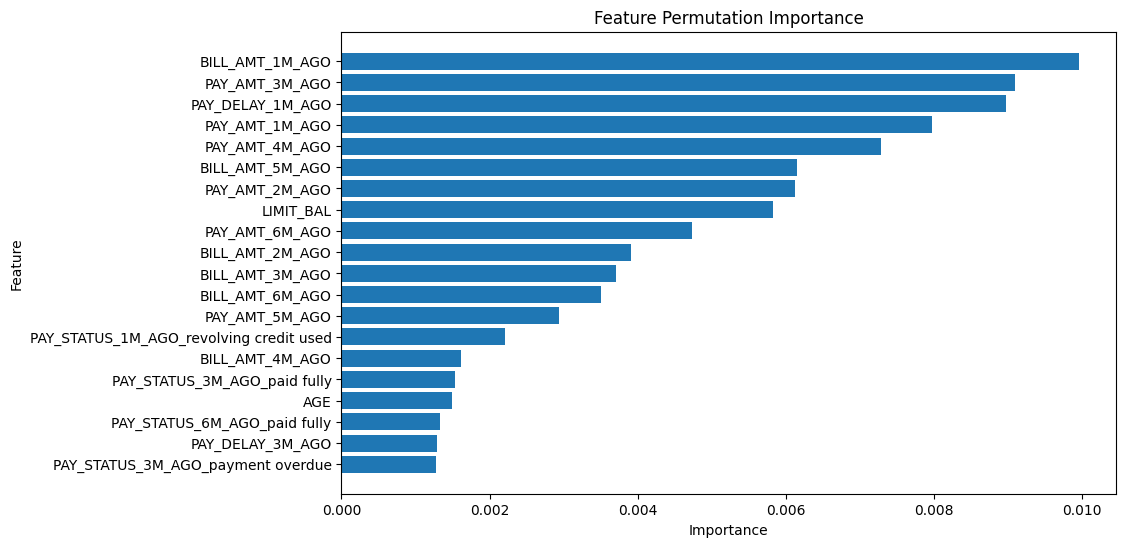

In [ ]:
plot_feat_permut_importance(rf2_feat_permut_import_df)

In [ ]:
rf2_perf, rf2_orig_missing, rf2_missing = measure_performance_decline(
    X_train, X_test, y_test, rf2_classifier, rf2_feat_permut_import_df,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family
)


--- NEW ITERATION ---
Removing feature:  BILL_AMT_1M_AGO
Original feat removed so far:  ['BILL_AMT_1M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_AMT_3M_AGO
Original feat removed so far:  ['BILL_AMT_1M_AGO', 'PAY_AMT_3M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Original feat removed so far:  ['BILL_AMT_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_DELAY_1M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_AMT_1M_AGO
Original feat removed so far:  ['BILL_AMT_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_DELAY_1M_AGO', 'PAY_AMT_1M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_AMT_4M_AGO
Original feat removed so far:  ['BILL_AMT_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_DELAY_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AMT_4M_AGO']

--- NEW ITERATION ---
Removing feature:  BILL_AMT_5M_AGO
Original feat removed so far:  ['BILL_AMT_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_DELAY_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AMT_4M_AGO', 'BILL_AMT_5M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_AMT_2M_AGO
Original fea

In [ ]:
rf2_perf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0   812  3774  899   515      47.46   61.19        80.76     76.43     53.46   
1   760  3869  804   567      48.59   57.27        82.79     77.15     52.58   
2   746  3919  754   581      49.73   56.22        83.86     77.75     52.78   
3   661  4074  599   666      52.46   49.81        87.18     78.92     51.10   
4   652  4092  581   675      52.88   49.13        87.57     79.07     50.94   
5   652  4099  574   675      53.18   49.13        87.72     79.18     51.08   
6   649  4100  573   678      53.11   48.91        87.74     79.15     50.92   
7   656  4100  573   671      53.38   49.43        87.74     79.27     51.33   
8   653  4116  557   674      53.97   49.21        88.08     79.48     51.48   
9   655  4124  549   672      54.40   49.36        88.25     79.65     51.76   
10  650  4140  533   677      54.95   48.98        88.59     79.83     51.79   
11  624  4147  526   703      54.26   47.02        88.74     79.52     50.38   
12  627  4145  528   700      54.29   47.25        88.70     79.53     50.52   
13  617  4149  524   710      54.08   46.50        88.79     79.43     50.00   
14  462  4279  394   865      53.97   34.82        91.57     79.02     42.33   
15  462  4281  392   865      54.10   34.82        91.61     79.05     42.37   
16  464  4281  392   863      54.21   34.97        91.61     79.08     42.51   
17  466  4278  395   861      54.12   35.12        91.55     79.07     42.60   
18  438  4303  370   889      54.21   33.01        92.08     79.02     41.03   
19  344  4412  261   983      56.86   25.92        94.41     79.27     35.61   
20  326  4436  237  1001      57.90   24.57        94.93     79.37     34.50   

    balanced_accuracy  num_feat_missing  \
0               70.98                 0   
1               70.03                 1   
2               70.04                 2   
3               68.50                 3   
4               68.35                 4   
5               68.43                 5   
6               68.32                 6   
7               68.59                 7   
8               68.64                 8   
9               68.81                 9   
10              68.79                10   
11              67.88                11   
12              67.98                12   
13              67.64                13   
14              63.19                14   
15              63.21                15   
16              63.29                16   
17              63.33                17   
18              62.54                18   
19              60.17                19   
20              59.75                20   

                                              imputed  
0                                                      
1                         ['BILL_AMT_1M_AGO'] imputed  
2       ['BILL_AMT_1M_AGO', 'PAY_AMT_3M_AGO'] imputed  
3   ['BILL_AMT_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_DEL...  
4   ['BILL_AMT_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_DEL...  
5   ['BILL_AMT_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_DEL...  
6   ['BILL_AMT_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_DEL...  
7   ['BILL_AMT_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_DEL...  
8   ['BILL_AMT_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_DEL...  
9   ['BILL_AMT_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_DEL...  
10  ['BILL_AMT_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_DEL...  
11  ['BILL_AMT_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_DEL...  
12  ['BILL_AMT_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_DEL...  
13  ['BILL_AMT_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_DEL...  
14  ['BILL_AMT_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_DEL...  
15  ['BILL_AMT_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_DEL...  
16  ['BILL_AMT_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_DEL...  
17  ['BILL_AMT_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_DEL...  
18  ['BILL_AMT_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_DEL...  
19  ['BILL_AMT_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_DEL...  
20  ['BILL_AMT_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_DEL...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

rf2_perf_mf, rf2_orig_missing_mf, rf2_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, rf2_classifier, rf2_feat_permut_import_df,
    imputation_dict=None, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 14:00:30.230243

--- NEW ITERATION ---
Removing feature:  BILL_AMT_1M_AGO
Nr. columns with nan:  1
Numerical columns:  ['LIMIT_BAL', 'AGE', 'BILL_AMT_1M_AGO', 'BILL_AMT_2M_AGO', 'BILL_AMT_3M_AGO', 'BILL_AMT_4M_AGO', 'BILL_AMT_5M_AGO', 'BILL_AMT_6M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO']
Categorical columns:  ['SEX_male', 'EDUCATION_high school', 'EDUCATION_others', 'EDUCATION_university', 'MARRIAGE_married', 'MARRIAGE_others', 'MARRIAGE_single', 'PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used', 'PAY_STATUS_2M_AGO_paid fully', 'PAY_STATUS_2M_AGO_payment overdue', 'PAY_STATUS_2M_AGO_revolving credit used', 'PAY_STATUS_3M_AGO_paid fully', 'PAY_STATUS_3M_AGO_payment overdue', 'PAY_STATUS_3M_AGO_revolving credit used', 'PAY_STAT

In [ ]:
rf2_perf_mf

tp    tn   fp   fn  precision  recall  specificity  accuracy  f1_score  \
0   812  3774  899  515      47.46   61.19        80.76     76.43     53.46   
1   795  3805  868  532      47.81   59.91        81.43     76.67     53.18   
2   774  3849  824  553      48.44   58.33        82.37     77.05     52.92   
3   729  3911  762  598      48.89   54.94        83.69     77.33     51.74   
4   720  3934  739  607      49.35   54.26        84.19     77.57     51.69   
5   705  3960  713  622      49.72   53.13        84.74     77.75     51.37   
6   669  4044  629  658      51.54   50.41        86.54     78.55     50.97   
7   662  4059  614  665      51.88   49.89        86.86     78.68     50.86   
8   647  4077  596  680      52.05   48.76        87.25     78.73     50.35   
9   643  4097  576  684      52.75   48.46        87.67     79.00     50.51   
10  620  4126  547  707      53.13   46.72        88.29     79.10     49.72   
11  616  4123  550  711      52.83   46.42        88.23     78.98     49.42   
12  626  4125  548  701      53.32   47.17        88.27     79.18     50.06   
13  617  4127  546  710      53.05   46.50        88.32     79.07     49.56   
14  527  4174  499  800      51.36   39.71        89.32     78.35     44.79   
15  592  4082  591  735      50.04   44.61        87.35     77.90     47.17   
16  588  4079  594  739      49.75   44.31        87.29     77.78     46.87   
17  572  4115  558  755      50.62   43.10        88.06     78.12     46.56   
18  559  4156  517  768      51.95   42.13        88.94     78.58     46.53   
19  547  4187  486  780      52.95   41.22        89.60     78.90     46.36   
20  542  4197  476  785      53.24   40.84        89.81     78.98     46.23   

    balanced_accuracy  num_feat_missing  \
0               70.98                 0   
1               70.67                 1   
2               70.35                 2   
3               69.31                 3   
4               69.22                 4   
5               68.93                 5   
6               68.48                 6   
7               68.37                 7   
8               68.00                 8   
9               68.06                 9   
10              67.51                10   
11              67.33                11   
12              67.72                12   
13              67.41                13   
14              64.52                14   
15              65.98                15   
16              65.80                16   
17              65.58                17   
18              65.53                18   
19              65.41                19   
20              65.33                20   

                                              imputed  
0                                                      
1                         ['BILL_AMT_1M_AGO'] imputed  
2       ['BILL_AMT_1M_AGO', 'PAY_AMT_3M_AGO'] imputed  
3   ['BILL_AMT_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_DEL...  
4   ['BILL_AMT_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_DEL...  
5   ['BILL_AMT_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_DEL...  
6   ['BILL_AMT_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_DEL...  
7   ['BILL_AMT_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_DEL...  
8   ['BILL_AMT_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_DEL...  
9   ['BILL_AMT_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_DEL...  
10  ['BILL_AMT_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_DEL...  
11  ['BILL_AMT_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_DEL...  
12  ['BILL_AMT_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_DEL...  
13  ['BILL_AMT_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_DEL...  
14  ['BILL_AMT_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_DEL...  
15  ['BILL_AMT_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_DEL...  
16  ['BILL_AMT_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_DEL...  
17  ['BILL_AMT_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_DEL...  
18  ['BILL_AMT_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_DEL...  
19  ['BILL_AMT_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_DEL...  
20  ['BILL_AMT_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_DEL...

In [ ]:
rf2_perf_temp, rf2_orig_missing_temp, rf2_missing_temp = measure_temporal_performance_decline(
    X_train, X_test, y_test, rf2_classifier, rf2_feat_permut_import_df,
    default_cc_timeline_vars_family,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family, log_info=True
)


--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  45
length removed:  0

Removing feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_payment overdue
Removing related features:  []
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Columns with zero variance, i.e. imputed:
                                    feature  variance
2                           BILL_AMT_1M_AGO       0.0
8                            PAY_AMT_1M_AGO       0.0
14                         PAY_DELAY_1M_A

In [ ]:
rf2_perf_temp

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0  812  3774  899   515      47.46   61.19        80.76     76.43     53.46   
1  545  4127  546   782      49.95   41.07        88.32     77.87     45.08   
2  461  4256  417   866      52.51   34.74        91.08     78.62     41.81   
3  411  4324  349   916      54.08   30.97        92.53     78.92     39.39   
4  310  4456  217  1017      58.82   23.36        95.36     79.43     33.44   
5    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   

   balanced_accuracy  num_feat_missing  \
0              70.98                 0   
1              64.69                 4   
2              62.91                 8   
3              61.75                12   
4              59.36                16   
5              50.00                20   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

rf2_perf_temp_mf, rf2_orig_missing_temp_mf, rf2_missing_temp_mf = measure_temporal_performance_decline(
    X_train, X_test, y_test, rf2_classifier, rf2_feat_permut_import_df,
    default_cc_timeline_vars_family, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars, log_info=True
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 14:07:00.315688

--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  45
length removed:  0

Removing feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_payment overdue
Removing related features:  []
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Nr. columns with nan:  6
Numerical columns:  ['LIMIT_BAL', 'AGE', 'BILL_AMT_1M_AGO', 'BILL_AMT_2M_AGO', 'BILL_AMT_3M_AGO', 'BILL_AMT_4M_AGO', 'BILL_AMT_5M_AGO', 'BILL_AMT_6M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', 'P

In [ ]:
rf2_perf_temp_mf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0  812  3774  899   515      47.46   61.19        80.76     76.43     53.46   
1  597  4013  660   730      47.49   44.99        85.88     76.83     46.21   
2  581  4089  584   746      49.87   43.78        87.50     77.83     46.63   
3  504  4204  469   823      51.80   37.98        89.96     78.47     43.83   
4  438  4297  376   889      53.81   33.01        91.95     78.92     40.92   
5   32  4654   19  1295      62.75    2.41        99.59     78.10      4.64   

   balanced_accuracy  num_feat_missing  \
0              70.98                 0   
1              65.43                 4   
2              65.64                 8   
3              63.97                12   
4              62.48                16   
5              51.00                20   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

##**Gradient-Boosted Trees**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  gbt2_param_grid = {
      'n_estimators': [100, 200, 300],
      'max_depth': [2, 3, 4, 5, None],  # literature recommends weak learners
      'min_child_samples': [100, 25, 1],
      'min_split_gain': [1, 0.5, 0.0],
      'reg_lambda': [10.0, 5.0, 1.0, 0.5, 0.0]
  }
else:
  # best model
  gbt2_param_grid = {
      'n_estimators': [100],
      'max_depth': [3],
      'min_child_samples': [100],
      'min_split_gain': [0.0],
      'reg_lambda': [5.0]
  }

gbt2_classifier = LGBMClassifier(
    objective= "binary",
    scale_pos_weight=ratio_majority_minority, random_state=RANDOM_STATE,
    verbose=-1, n_jobs=1
)
gbt2_grid_search, gbt2_best_model, gbt2_best_params = hyperparameter_tuning(
    gbt2_classifier, gbt2_param_grid, 3, 3, 'balanced_accuracy',
    X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-18 11:28:11.359888

Nested Cross-validation Results:
Individual scores: [0.72472672 0.72029409 0.71039394]
Average nested CV score: 0.718 (+/- 0.012)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'max_depth': 3, 'min_child_samples': 100, 'min_split_gain': 0.0, 'n_estimators': 100, 'reg_lambda': 5.0}

Best Model Performance:
Best CV score: 0.718
2025-01-18 11:28:16.231650

Execution time: 0.08 minutes


```
Starting hyperparameter tuning at: 2025-01-17 17:35:52.517610

Nested Cross-validation Results:
Individual scores: [0.72227032 0.71472463 0.70696874]
Average nested CV score: 0.715 (+/- 0.012)

Fitting final model on entire dataset...
Fitting 3 folds for each of 675 candidates, totalling 2025 fits
Best parameters: {'max_depth': 3, 'min_child_samples': 100, 'min_split_gain': 0.0, 'n_estimators': 100, 'reg_lambda': 5.0}

Best Model Performance:
Best CV score: 0.718
2025-01-17 17:47:00.584824

Execution time: 11.13 minutes
```

In [ ]:
gbt2_classifier, gbt2_train_pred, gbt2_test_pred = apply_model(gbt2_best_model, X_train, y_train, X_test, y_test)
gbt2_feat_permut_import_df = analyze_feat_permut_import(gbt2_classifier, X_train, y_train, scoring_metric="balanced_accuracy")
gbt2_feat_permut_import_df[gbt2_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
14                         PAY_DELAY_1M_AGO    0.063909  0.000543
2                           BILL_AMT_1M_AGO    0.010860  0.001101
0                                 LIMIT_BAL    0.006283  0.001786
11                           PAY_AMT_4M_AGO    0.005327  0.001021
10                           PAY_AMT_3M_AGO    0.004809  0.000658
8                            PAY_AMT_1M_AGO    0.003923  0.000571
9                            PAY_AMT_2M_AGO    0.003907  0.001037
4                           BILL_AMT_3M_AGO    0.003230  0.000591
15                         PAY_DELAY_2M_AGO    0.003134  0.001137
16                         PAY_DELAY_3M_AGO    0.002491  0.000499
5                           BILL_AMT_4M_AGO    0.001801  0.000444
27             PAY_STATUS_1M_AGO_paid fully    0.001784  0.000579
22                         EDUCATION_others    0.001529  0.000311
13                           PAY_AMT_6M_AGO    0.001511  0.000856
6                           BILL_AMT_5M_AGO    0.001313  0.000184
18                         PAY_DELAY_5M_AGO    0.001309  0.000787
19                         PAY_DELAY_6M_AGO    0.001002  0.000591
3                           BILL_AMT_2M_AGO    0.000971  0.000441
36             PAY_STATUS_4M_AGO_paid fully    0.000930  0.000247
24                         MARRIAGE_married    0.000822  0.000568
17                         PAY_DELAY_4M_AGO    0.000814  0.000343
20                                 SEX_male    0.000798  0.000293
42             PAY_STATUS_6M_AGO_paid fully    0.000722  0.000760
38  PAY_STATUS_4M_AGO_revolving credit used    0.000630  0.000139
33             PAY_STATUS_3M_AGO_paid fully    0.000491  0.000073
23                     EDUCATION_university    0.000449  0.000163
26                          MARRIAGE_single    0.000275  0.000403
39             PAY_STATUS_5M_AGO_paid fully    0.000143  0.000200
7                           BILL_AMT_6M_AGO    0.000129  0.000302
1                                       AGE    0.000122  0.000560
35  PAY_STATUS_3M_AGO_revolving credit used   -0.000069  0.000051
32  PAY_STATUS_2M_AGO_revolving credit used   -0.000092  0.000235
29  PAY_STATUS_1M_AGO_revolving credit used   -0.000464  0.000339
12                           PAY_AMT_5M_AGO   -0.000532  0.000218

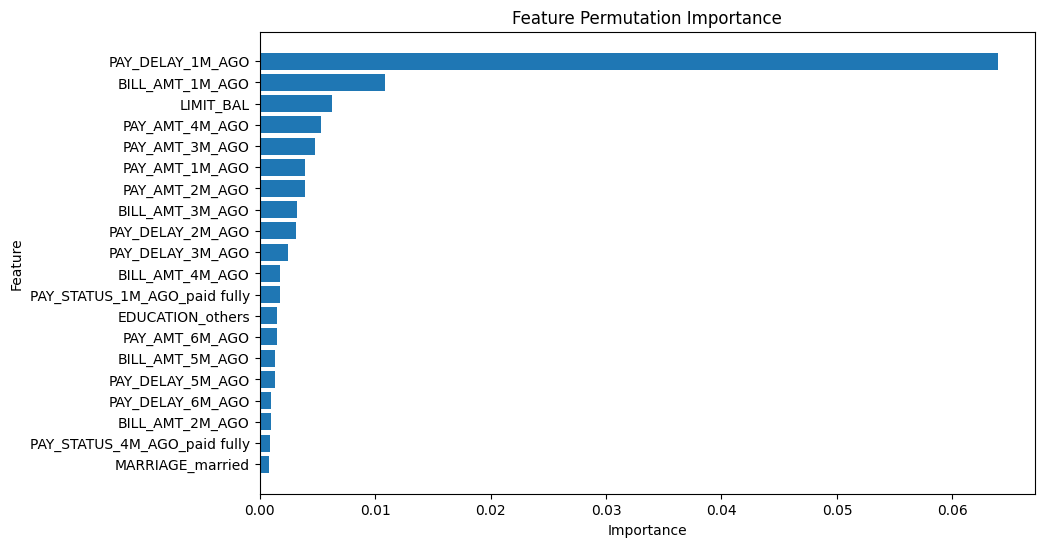

In [ ]:
plot_feat_permut_importance(gbt2_feat_permut_import_df)

In [ ]:
gbt2_perf, gbt2_orig_missing, gbt2_missing = measure_performance_decline(
    X_train, X_test, y_test, gbt2_classifier, gbt2_feat_permut_import_df,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family
)


--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO']

--- NEW ITERATION ---
Removing feature:  BILL_AMT_1M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO']

--- NEW ITERATION ---
Removing feature:  LIMIT_BAL
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT_BAL']

--- NEW ITERATION ---
Removing feature:  PAY_AMT_4M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT_BAL', 'PAY_AMT_4M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_AMT_3M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT_BAL', 'PAY_AMT_4M_AGO', 'PAY_AMT_3M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_AMT_1M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT_BAL', 'PAY_AMT_4M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_1M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_AMT_2M_AGO
Original feat removed so far:  ['PAY

In [ ]:
gbt2_perf

tp    tn    fp    fn  precision  recall  specificity  accuracy  f1_score  \
0   837  3652  1021   490      45.05   63.07        78.15     74.82     52.56   
1   652  3840   833   675      43.91   49.13        82.17     74.87     46.37   
2   505  4193   480   822      51.27   38.06        89.73     78.30     43.69   
3   466  4254   419   861      52.66   35.12        91.03     78.67     42.13   
4   463  4253   420   864      52.43   34.89        91.01     78.60     41.90   
5   443  4306   367   884      54.69   33.38        92.15     79.15     41.46   
6   426  4312   361   901      54.13   32.10        92.27     78.97     40.30   
7   389  4347   326   938      54.41   29.31        93.02     78.93     38.10   
8   368  4375   298   959      55.26   27.73        93.62     79.05     36.93   
9   304  4444   229  1023      57.04   22.91        95.10     79.13     32.69   
10  245  4508   165  1082      59.76   18.46        96.47     79.22     28.21   
11  238  4520   153  1089      60.87   17.94        96.73     79.30     27.71   
12  237  4525   148  1090      61.56   17.86        96.83     79.37     27.69   
13  227  4532   141  1100      61.68   17.11        96.98     79.32     26.78   
14  230  4530   143  1097      61.66   17.33        96.94     79.33     27.06   
15  228  4532   141  1099      61.79   17.18        96.98     79.33     26.89   
16   21  4659    14  1306      60.00    1.58        99.70     78.00      3.08   
17    1  4671     2  1326      33.33    0.08        99.96     77.87      0.15   
18    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
19    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
20    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   

    balanced_accuracy  num_feat_missing  \
0               70.61                 0   
1               65.65                 1   
2               63.89                 2   
3               63.08                 3   
4               62.95                 4   
5               62.76                 5   
6               62.19                 6   
7               61.17                 7   
8               60.68                 8   
9               59.00                 9   
10              57.47                10   
11              57.33                11   
12              57.35                12   
13              57.04                13   
14              57.14                14   
15              57.08                15   
16              50.64                16   
17              50.02                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2     ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO'] imputed  
3   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
4   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
5   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
6   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
7   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
8   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
9   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
10  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
11  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
12  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
13  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
14  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
15  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
16  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
17  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
18  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
19  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
20  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

gbt2_perf_mf, gbt2_orig_missing_mf, gbt2_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, gbt2_classifier, gbt2_feat_permut_import_df,
    imputation_dict=None, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 14:08:38.724918

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Nr. columns with nan:  1
Numerical columns:  ['LIMIT_BAL', 'AGE', 'BILL_AMT_1M_AGO', 'BILL_AMT_2M_AGO', 'BILL_AMT_3M_AGO', 'BILL_AMT_4M_AGO', 'BILL_AMT_5M_AGO', 'BILL_AMT_6M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO']
Categorical columns:  ['SEX_male', 'EDUCATION_high school', 'EDUCATION_others', 'EDUCATION_university', 'MARRIAGE_married', 'MARRIAGE_others', 'MARRIAGE_single', 'PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used', 'PAY_STATUS_2M_AGO_paid fully', 'PAY_STATUS_2M_AGO_payment overdue', 'PAY_STATUS_2M_AGO_revolving credit used', 'PAY_STATUS_3M_AGO_paid fully', 'PAY_STATUS_3M_AGO_payment overdue', 'PAY_STATUS_3M_AGO_revolving credit used', 'PAY_STA

In [ ]:
gbt2_perf_mf

tp    tn    fp   fn  precision  recall  specificity  accuracy  f1_score  \
0    837  3652  1021  490      45.05   63.07        78.15     74.82     52.56   
1   1052  2467  2206  275      32.29   79.28        52.79     58.65     45.89   
2   1004  2650  2023  323      33.17   75.66        56.71     60.90     46.12   
3    900  3050  1623  427      35.67   67.82        65.27     65.83     46.75   
4    819  3240  1433  508      36.37   61.72        69.33     67.65     45.77   
5    782  3349  1324  545      37.13   58.93        71.67     68.85     45.56   
6    755  3426  1247  572      37.71   56.90        73.31     69.68     45.36   
7    756  3438  1235  571      37.97   56.97        73.57     69.90     45.57   
8    730  3498  1175  597      38.32   55.01        74.86     70.47     45.17   
9    657  3611  1062  670      38.22   49.51        77.27     71.13     43.14   
10   581  3683   990  746      36.98   43.78        78.81     71.07     40.10   
11   644  3543  1130  683      36.30   48.53        75.82     69.78     41.53   
12   826  2759  1914  501      30.15   62.25        59.04     59.75     40.62   
13   828  2714  1959  499      29.71   62.40        58.08     59.03     40.25   
14   771  2862  1811  556      29.86   58.10        61.25     60.55     39.45   
15   816  2669  2004  511      28.94   61.49        57.12     58.08     39.35   
16  1011  1822  2851  316      26.18   76.19        38.99     47.22     38.97   
17  1173   911  3762  154      23.77   88.39        19.49     34.73     37.46   
18  1160  1018  3655  167      24.09   87.42        21.78     36.30     37.77   
19  1205   738  3935  122      23.44   90.81        15.79     32.38     37.27   
20  1185   848  3825  142      23.65   89.30        18.15     33.88     37.40   

    balanced_accuracy  num_feat_missing  \
0               70.61                 0   
1               66.03                 1   
2               66.18                 2   
3               66.55                 3   
4               65.53                 4   
5               65.30                 5   
6               65.11                 6   
7               65.27                 7   
8               64.93                 8   
9               63.39                 9   
10              61.30                10   
11              62.17                11   
12              60.64                12   
13              60.24                13   
14              59.67                14   
15              59.30                15   
16              57.59                16   
17              53.94                17   
18              54.60                18   
19              53.30                19   
20              53.72                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2     ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO'] imputed  
3   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
4   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
5   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
6   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
7   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
8   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
9   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
10  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
11  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
12  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
13  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
14  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
15  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
16  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
17  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
18  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
19  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
20  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...

In [ ]:
gbt2_perf_temp, gbt2_orig_missing_temp, gbt2_missing_temp = measure_temporal_performance_decline(
    X_train, X_test, y_test, gbt2_classifier, gbt2_feat_permut_import_df,
    default_cc_timeline_vars_family,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family, log_info=True
)


--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  45
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_payment overdue
Removing related features:  []
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Columns with zero variance, i.e. imputed:
                                    feature  variance
2                           BILL_AMT_1M_AGO       0.0
8                            PAY_AMT_1M_AGO       0.0
14                         PAY_DELAY_1M_

In [ ]:
gbt2_perf_temp

tp    tn    fp    fn  precision  recall  specificity  accuracy  f1_score  \
0  837  3652  1021   490      45.05   63.07        78.15     74.82     52.56   
1  485  4208   465   842      51.05   36.55        90.05     78.22     42.60   
2  447  4281   392   880      53.28   33.69        91.61     78.80     41.27   
3  403  4332   341   924      54.17   30.37        92.70     78.92     38.92   
4  237  4521   152  1090      60.93   17.86        96.75     79.30     27.62   
5    4  4671     2  1323      66.67    0.30        99.96     77.92      0.60   
6    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
7    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   

   balanced_accuracy  num_feat_missing  \
0              70.61                 0   
1              63.30                 4   
2              62.65                 5   
3              61.54                 9   
4              57.30                13   
5              50.13                17   
6              50.00                18   
7              50.00                22   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
7  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

gbt2_perf_temp_mf, gbt2_orig_missing_temp_mf, gbt2_missing_temp_mf = measure_temporal_performance_decline(
    X_train, X_test, y_test, gbt2_classifier, gbt2_feat_permut_import_df,
    default_cc_timeline_vars_family, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars, log_info=True
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 14:14:59.016186

--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  45
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_payment overdue
Removing related features:  []
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Nr. columns with nan:  6
Numerical columns:  ['LIMIT_BAL', 'AGE', 'BILL_AMT_1M_AGO', 'BILL_AMT_2M_AGO', 'BILL_AMT_3M_AGO', 'BILL_AMT_4M_AGO', 'BILL_AMT_5M_AGO', 'BILL_AMT_6M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', '

In [ ]:
gbt2_perf_temp_mf

tp    tn    fp   fn  precision  recall  specificity  accuracy  f1_score  \
0   837  3652  1021  490      45.05   63.07        78.15     74.82     52.56   
1  1040  2294  2379  287      30.42   78.37        49.09     55.57     43.83   
2   997  2514  2159  330      31.59   75.13        53.80     58.52     44.48   
3  1072  1948  2725  255      28.23   80.78        41.69     50.33     41.84   
4  1110  1819  2854  217      28.00   83.65        38.93     48.82     41.96   
5   980  1930  2743  347      26.32   73.85        41.30     48.50     38.81   
6   988  1888  2785  339      26.19   74.45        40.40     47.93     38.75   
7  1177   787  3886  150      23.25   88.70        16.84     32.73     36.84   

   balanced_accuracy  num_feat_missing  \
0              70.61                 0   
1              63.73                 4   
2              64.47                 5   
3              61.24                 9   
4              61.29                13   
5              57.58                17   
6              57.43                18   
7              52.77                22   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
7  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

##**XGBoost**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  xgb2_param_grid = {
      'n_estimators': [100, 200, 300],
      'max_depth': [2, 3, 5, None],
      'reg_lambda':[10.0, 5.0, 1.0, 0.5, 0],     # L2 regularization on weights
      'gamma': [1.0, 0.5, 0.1, 0.05, 0.0],       # Minimum loss reduction required for node splitting (default=0)
      'colsample_bytree':[0.25, 0.5, 0.75, 1.0]  # Fraction of features used for each tree
  }
else:
  # best model
  xgb2_param_grid = {
    'n_estimators': [100],
    'max_depth': [2],
    'reg_lambda':[5.0],
    'gamma': [0.05],
    'colsample_bytree':[0.25]
}

xgb2_classifier = XGBClassifier(
    scale_pos_weight=ratio_majority_minority, random_state=RANDOM_STATE, n_jobs=1
)
xgb2_grid_search, xgb2_best_model, xgb2_best_params = hyperparameter_tuning(
    xgb2_classifier, xgb2_param_grid, 3, 3, 'balanced_accuracy', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-18 11:34:40.102225

Nested Cross-validation Results:
Individual scores: [0.72316375 0.71541158 0.71181272]
Average nested CV score: 0.717 (+/- 0.009)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'colsample_bytree': 0.25, 'gamma': 0.05, 'max_depth': 2, 'n_estimators': 100, 'reg_lambda': 5.0}

Best Model Performance:
Best CV score: 0.717
2025-01-18 11:34:43.700490

Execution time: 0.06 minutes


```
Starting hyperparameter tuning at: 2025-01-17 17:47:00.593646

Nested Cross-validation Results:
Individual scores: [0.72213741 0.71390619 0.70610541]
Average nested CV score: 0.714 (+/- 0.013)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1200 candidates, totalling 3600 fits
Best parameters: {'colsample_bytree': 0.25, 'gamma': 0.05, 'max_depth': 2, 'n_estimators': 100, 'reg_lambda': 5.0}

Best Model Performance:
Best CV score: 0.717
2025-01-17 18:09:18.936817

Execution time: 22.31 minutes
```

In [ ]:
xgb2_classifier, xgb2_train_pred, xgb2_test_pred = apply_model(xgb2_best_model, X_train, y_train, X_test, y_test)
xgb2_feat_permut_import_df = analyze_feat_permut_import(xgb2_classifier, X_train, y_train, scoring_metric="balanced_accuracy")
xgb2_feat_permut_import_df[xgb2_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
14                         PAY_DELAY_1M_AGO    0.044743  0.000694
2                           BILL_AMT_1M_AGO    0.010588  0.001263
10                           PAY_AMT_3M_AGO    0.009169  0.000723
31        PAY_STATUS_2M_AGO_payment overdue    0.008145  0.000378
9                            PAY_AMT_2M_AGO    0.006196  0.000446
4                           BILL_AMT_3M_AGO    0.005602  0.000764
0                                 LIMIT_BAL    0.005521  0.002000
11                           PAY_AMT_4M_AGO    0.005085  0.000623
8                            PAY_AMT_1M_AGO    0.004297  0.000763
12                           PAY_AMT_5M_AGO    0.003527  0.000934
13                           PAY_AMT_6M_AGO    0.003228  0.000481
18                         PAY_DELAY_5M_AGO    0.003140  0.000876
16                         PAY_DELAY_3M_AGO    0.002727  0.000948
5                           BILL_AMT_4M_AGO    0.002104  0.000546
42             PAY_STATUS_6M_AGO_paid fully    0.002080  0.000492
7                           BILL_AMT_6M_AGO    0.001746  0.000990
22                         EDUCATION_others    0.001622  0.000473
37        PAY_STATUS_4M_AGO_payment overdue    0.001261  0.000486
1                                       AGE    0.001097  0.000421
43        PAY_STATUS_6M_AGO_payment overdue    0.001070  0.000438
3                           BILL_AMT_2M_AGO    0.001062  0.000434
32  PAY_STATUS_2M_AGO_revolving credit used    0.000970  0.000111
27             PAY_STATUS_1M_AGO_paid fully    0.000951  0.000719
33             PAY_STATUS_3M_AGO_paid fully    0.000796  0.000450
24                         MARRIAGE_married    0.000786  0.000357
6                           BILL_AMT_5M_AGO    0.000701  0.000175
23                     EDUCATION_university    0.000684  0.000455
19                         PAY_DELAY_6M_AGO    0.000471  0.000274
28        PAY_STATUS_1M_AGO_payment overdue    0.000411  0.000366
15                         PAY_DELAY_2M_AGO    0.000410  0.000181
29  PAY_STATUS_1M_AGO_revolving credit used    0.000322  0.000445
25                          MARRIAGE_others    0.000279  0.000119
30             PAY_STATUS_2M_AGO_paid fully    0.000267  0.000161
17                         PAY_DELAY_4M_AGO    0.000118  0.000075
26                          MARRIAGE_single    0.000041  0.000606
20                                 SEX_male   -0.000012  0.000372
36             PAY_STATUS_4M_AGO_paid fully   -0.000017  0.000199
34        PAY_STATUS_3M_AGO_payment overdue   -0.000121  0.000127
44  PAY_STATUS_6M_AGO_revolving credit used   -0.000142  0.000174

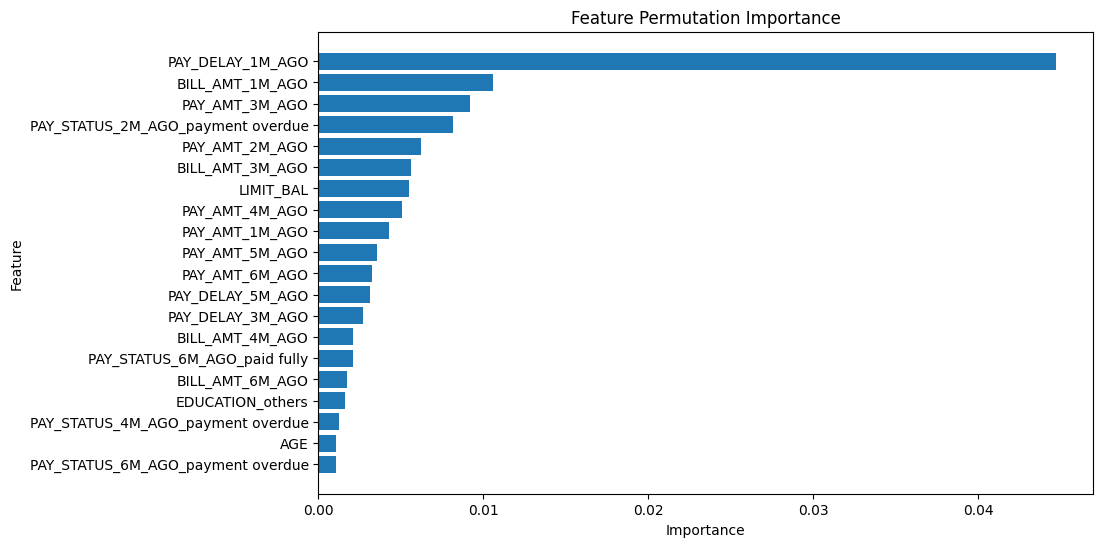

In [ ]:
plot_feat_permut_importance(xgb2_feat_permut_import_df)

In [ ]:
xgb2_perf, xgb2_orig_missing, xgb2_missing = measure_performance_decline(
    X_train, X_test, y_test, xgb2_classifier, xgb2_feat_permut_import_df,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family
)


--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO']

--- NEW ITERATION ---
Removing feature:  BILL_AMT_1M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_AMT_3M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_AMT_3M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_STATUS_2M_AGO_payment overdue
Removing related features:  ['PAY_STATUS_2M_AGO_paid fully', 'PAY_STATUS_2M_AGO_payment overdue', 'PAY_STATUS_2M_AGO_revolving credit used']
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_STATUS_2M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_AMT_2M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_STATUS_2M_AGO', 'PAY_AMT_2M_AGO']

--- NEW ITERATION ---
Removing feature:  BILL_AMT_3M_AGO
Original feat removed so far:  ['PAY_DELAY_1

In [ ]:
xgb2_perf

tp    tn    fp    fn  precision  recall  specificity  accuracy  f1_score  \
0   825  3627  1046   502      44.09   62.17        77.62     74.20     51.59   
1   700  3758   915   627      43.34   52.75        80.42     74.30     47.59   
2   569  4150   523   758      52.11   42.88        88.81     78.65     47.04   
3   543  4191   482   784      52.98   40.92        89.69     78.90     46.17   
4   380  4368   305   947      55.47   28.64        93.47     79.13     37.77   
5   391  4349   324   936      54.69   29.46        93.07     79.00     38.30   
6   362  4395   278   965      56.56   27.28        94.05     79.28     36.81   
7   306  4469   204  1021      60.00   23.06        95.63     79.58     33.32   
8   308  4463   210  1019      59.46   23.21        95.51     79.52     33.39   
9   323  4428   245  1004      56.87   24.34        94.76     79.18     34.09   
10  280  4500   173  1047      61.81   21.10        96.30     79.67     31.46   
11  280  4480   193  1047      59.20   21.10        95.87     79.33     31.11   
12   62  4606    67  1265      48.06    4.67        98.57     77.80      8.52   
13   25  4637    36  1302      40.98    1.88        99.23     77.70      3.60   
14   17  4662    11  1310      60.71    1.28        99.76     77.98      2.51   
15    7  4667     6  1320      53.85    0.53        99.87     77.90      1.04   
16    1  4670     3  1326      25.00    0.08        99.94     77.85      0.15   
17    1  4670     3  1326      25.00    0.08        99.94     77.85      0.15   
18    1  4671     2  1326      33.33    0.08        99.96     77.87      0.15   
19    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
20    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   

    balanced_accuracy  num_feat_missing  \
0               69.89                 0   
1               66.58                 1   
2               65.84                 2   
3               65.30                 3   
4               61.05                 4   
5               61.27                 5   
6               60.67                 6   
7               59.35                 7   
8               59.36                 8   
9               59.55                 9   
10              58.70                10   
11              58.49                11   
12              51.62                12   
13              50.56                13   
14              50.52                14   
15              50.20                15   
16              50.01                16   
17              50.01                17   
18              50.02                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2     ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO'] imputed  
3   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
4   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
5   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
6   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
7   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
8   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
9   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
10  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
11  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
12  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
13  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
14  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
15  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
16  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
17  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
18  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
19  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
20  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())


xgb2_perf_mf, xgb2_orig_missing_mf, xgb2_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, xgb2_classifier, xgb2_feat_permut_import_df,
    imputation_dict=None, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 14:17:13.508633

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Nr. columns with nan:  1
Numerical columns:  ['LIMIT_BAL', 'AGE', 'BILL_AMT_1M_AGO', 'BILL_AMT_2M_AGO', 'BILL_AMT_3M_AGO', 'BILL_AMT_4M_AGO', 'BILL_AMT_5M_AGO', 'BILL_AMT_6M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO']
Categorical columns:  ['SEX_male', 'EDUCATION_high school', 'EDUCATION_others', 'EDUCATION_university', 'MARRIAGE_married', 'MARRIAGE_others', 'MARRIAGE_single', 'PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used', 'PAY_STATUS_2M_AGO_paid fully', 'PAY_STATUS_2M_AGO_payment overdue', 'PAY_STATUS_2M_AGO_revolving credit used', 'PAY_STATUS_3M_AGO_paid fully', 'PAY_STATUS_3M_AGO_payment overdue', 'PAY_STATUS_3M_AGO_revolving credit used', 'PAY_STA

In [ ]:
xgb2_perf_mf

tp    tn    fp    fn  precision  recall  specificity  accuracy  f1_score  \
0   825  3627  1046   502      44.09   62.17        77.62     74.20     51.59   
1   713  3739   934   614      43.29   53.73        80.01     74.20     47.95   
2   673  3900   773   654      46.54   50.72        83.46     76.22     48.54   
3   635  4010   663   692      48.92   47.85        85.81     77.42     48.38   
4   601  4044   629   726      48.86   45.29        86.54     77.42     47.01   
5   562  4112   561   765      50.04   42.35        87.99     77.90     45.88   
6   550  4112   561   777      49.50   41.45        87.99     77.70     45.12   
7   523  4165   508   804      50.73   39.41        89.13     78.13     44.36   
8   468  4270   403   859      53.73   35.27        91.38     78.97     42.58   
9   467  4277   396   860      54.11   35.19        91.53     79.07     42.65   
10  442  4307   366   885      54.70   33.31        92.17     79.15     41.41   
11  432  4309   364   895      54.27   32.55        92.21     79.02     40.70   
12  388  4361   312   939      55.43   29.24        93.32     79.15     38.28   
13  290  4467   206  1037      58.47   21.85        95.59     79.28     31.82   
14  301  4471   202  1026      59.84   22.68        95.68     79.53     32.90   
15  252  4488   185  1075      57.67   18.99        96.04     79.00     28.57   
16  270  4469   204  1057      56.96   20.35        95.63     78.98     29.98   
17  258  4474   199  1069      56.46   19.44        95.74     78.87     28.92   
18  196  4528   145  1131      57.48   14.77        96.90     78.73     23.50   
19  182  4537   136  1145      57.23   13.72        97.09     78.65     22.13   
20  146  4546   127  1181      53.48   11.00        97.28     78.20     18.25   

    balanced_accuracy  num_feat_missing  \
0               69.89                 0   
1               66.87                 1   
2               67.09                 2   
3               66.83                 3   
4               65.91                 4   
5               65.17                 5   
6               64.72                 6   
7               64.27                 7   
8               63.32                 8   
9               63.36                 9   
10              62.74                10   
11              62.38                11   
12              61.28                12   
13              58.72                13   
14              59.18                14   
15              57.52                15   
16              57.99                16   
17              57.59                17   
18              55.83                18   
19              55.40                19   
20              54.14                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2     ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO'] imputed  
3   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
4   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
5   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
6   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
7   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
8   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
9   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
10  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
11  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
12  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
13  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
14  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
15  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
16  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
17  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
18  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
19  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
20  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...

In [ ]:
xgb2_perf_temp, xgb2_orig_missing_temp, xgb2_missing_temp = measure_temporal_performance_decline(
    X_train, X_test, y_test, xgb2_classifier, xgb2_feat_permut_import_df,
    default_cc_timeline_vars_family,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family, log_info=True
)


--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  45
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_payment overdue
Removing related features:  []
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Columns with zero variance, i.e. imputed:
                                    feature  variance
2                           BILL_AMT_1M_AGO       0.0
8                            PAY_AMT_1M_AGO       0.0
14                         PAY_DELAY_1M_

In [ ]:
xgb2_perf_temp

tp    tn    fp    fn  precision  recall  specificity  accuracy  f1_score  \
0  825  3627  1046   502      44.09   62.17        77.62     74.20     51.59   
1  508  4186   487   819      51.06   38.28        89.58     78.23     43.76   
2  386  4341   332   941      53.76   29.09        92.90     78.78     37.75   
3  247  4475   198  1080      55.51   18.61        95.76     78.70     27.88   
4  216  4512   161  1111      57.29   16.28        96.55     78.80     25.35   
5  144  4564   109  1183      56.92   10.85        97.67     78.47     18.23   
6    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   

   balanced_accuracy  num_feat_missing  \
0              69.89                 0   
1              63.93                 4   
2              60.99                 8   
3              57.19                12   
4              56.42                13   
5              54.26                17   
6              50.00                21   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

xgb2_perf_temp_mf, xgb2_orig_missing_temp_mf, xgb2_missing_temp_mf = measure_temporal_performance_decline(
    X_train, X_test, y_test, xgb2_classifier, xgb2_feat_permut_import_df,
    default_cc_timeline_vars_family, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars, log_info=True
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 14:23:33.571205

--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  45
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_payment overdue
Removing related features:  []
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Nr. columns with nan:  6
Numerical columns:  ['LIMIT_BAL', 'AGE', 'BILL_AMT_1M_AGO', 'BILL_AMT_2M_AGO', 'BILL_AMT_3M_AGO', 'BILL_AMT_4M_AGO', 'BILL_AMT_5M_AGO', 'BILL_AMT_6M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', '

In [ ]:
xgb2_perf_temp_mf

tp    tn    fp    fn  precision  recall  specificity  accuracy  f1_score  \
0  825  3627  1046   502      44.09   62.17        77.62     74.20     51.59   
1  649  3840   833   678      43.79   48.91        82.17     74.82     46.21   
2  580  4076   597   747      49.28   43.71        87.22     77.60     46.33   
3  296  4399   274  1031      51.93   22.31        94.14     78.25     31.21   
4  272  4437   236  1055      53.54   20.50        94.95     78.48     29.65   
5  207  4493   180  1120      53.49   15.60        96.15     78.33     24.15   
6   57  4634    39  1270      59.38    4.30        99.17     78.18      8.01   

   balanced_accuracy  num_feat_missing  \
0              69.89                 0   
1              65.54                 4   
2              65.47                 8   
3              58.22                12   
4              57.72                13   
5              55.87                17   
6              51.73                21   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

## **Extra Trees Classifier**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  et2_param_grid = {
      'n_estimators': [100, 200, 300, 500],
      'max_depth': [2, 3, 5, None],
      'max_features':['sqrt', 0.5, 1.0],
      'min_samples_split': [0.005, 0.001, 2],
      'min_samples_leaf': [0.005, 0.001, 1]
  }
else:
  et2_param_grid = {
      'n_estimators': [100],
      'max_depth': [None],
      'max_features':[1.0],
      'min_samples_split': [0.005],
      'min_samples_leaf': [0.001]
  }

et2_classifier = ExtraTreesClassifier(class_weight='balanced', random_state=RANDOM_STATE)
et2_grid_search, et2_best_model, et2_best_params = hyperparameter_tuning(
    et2_classifier, et2_param_grid, 3, 3, 'balanced_accuracy', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-18 11:41:07.450976

Nested Cross-validation Results:
Individual scores: [0.7199554  0.71786462 0.70257774]
Average nested CV score: 0.713 (+/- 0.015)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'max_depth': None, 'max_features': 1.0, 'min_samples_leaf': 0.001, 'min_samples_split': 0.005, 'n_estimators': 100}

Best Model Performance:
Best CV score: 0.713
2025-01-18 11:41:30.059670

Execution time: 0.38 minutes


```
Starting hyperparameter tuning at: 2025-01-17 19:46:53.007485

Nested Cross-validation Results:
Individual scores: [0.71653499 0.71430158 0.70584288]
Average nested CV score: 0.712 (+/- 0.009)

Fitting final model on entire dataset...
Fitting 3 folds for each of 432 candidates, totalling 1296 fits
Best parameters: {'max_depth': None, 'max_features': 1.0, 'min_samples_leaf': 0.001, 'min_samples_split': 0.005, 'n_estimators': 100}

Best Model Performance:
Best CV score: 0.713
2025-01-17 20:46:54.779562

Execution time: 60.03 minutes
```




In [ ]:
et2_classifier, train_pred, test_pred = apply_model(et2_best_model, X_train, y_train, X_test, y_test)
et2_feat_permut_import_df = analyze_feat_permut_import(et2_classifier, X_train, y_train, scoring_metric="balanced_accuracy")
et2_feat_permut_import_df[et2_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
28        PAY_STATUS_1M_AGO_payment overdue    0.097032  0.002228
0                                 LIMIT_BAL    0.021180  0.000738
44  PAY_STATUS_6M_AGO_revolving credit used    0.013105  0.000414
27             PAY_STATUS_1M_AGO_paid fully    0.011639  0.000389
3                           BILL_AMT_2M_AGO    0.011353  0.000482
2                           BILL_AMT_1M_AGO    0.010646  0.000159
6                           BILL_AMT_5M_AGO    0.009955  0.000246
33             PAY_STATUS_3M_AGO_paid fully    0.009865  0.001060
34        PAY_STATUS_3M_AGO_payment overdue    0.009398  0.000861
40        PAY_STATUS_5M_AGO_payment overdue    0.009080  0.000561
32  PAY_STATUS_2M_AGO_revolving credit used    0.008006  0.000669
4                           BILL_AMT_3M_AGO    0.007763  0.000712
8                            PAY_AMT_1M_AGO    0.007415  0.000543
29  PAY_STATUS_1M_AGO_revolving credit used    0.007396  0.000611
5                           BILL_AMT_4M_AGO    0.007052  0.000375
23                     EDUCATION_university    0.006745  0.000563
20                                 SEX_male    0.006319  0.000965
7                           BILL_AMT_6M_AGO    0.006038  0.000528
38  PAY_STATUS_4M_AGO_revolving credit used    0.005365  0.000527
11                           PAY_AMT_4M_AGO    0.005223  0.001124
42             PAY_STATUS_6M_AGO_paid fully    0.004996  0.000253
36             PAY_STATUS_4M_AGO_paid fully    0.004953  0.000749
30             PAY_STATUS_2M_AGO_paid fully    0.004934  0.000846
31        PAY_STATUS_2M_AGO_payment overdue    0.004924  0.000610
9                            PAY_AMT_2M_AGO    0.004819  0.000373
35  PAY_STATUS_3M_AGO_revolving credit used    0.004252  0.000174
1                                       AGE    0.004105  0.000564
24                         MARRIAGE_married    0.004009  0.000284
14                         PAY_DELAY_1M_AGO    0.003690  0.000649
10                           PAY_AMT_3M_AGO    0.003457  0.000500
39             PAY_STATUS_5M_AGO_paid fully    0.003259  0.000764
26                          MARRIAGE_single    0.003162  0.000331
13                           PAY_AMT_6M_AGO    0.002991  0.000524
12                           PAY_AMT_5M_AGO    0.002078  0.000522
41  PAY_STATUS_5M_AGO_revolving credit used    0.001654  0.000398
21                    EDUCATION_high school    0.001413  0.000347
16                         PAY_DELAY_3M_AGO    0.000993  0.000359
37        PAY_STATUS_4M_AGO_payment overdue    0.000657  0.000351
43        PAY_STATUS_6M_AGO_payment overdue    0.000469  0.000170
19                         PAY_DELAY_6M_AGO    0.000375  0.000044
17                         PAY_DELAY_4M_AGO    0.000342  0.000356
22                         EDUCATION_others    0.000260  0.000172
18                         PAY_DELAY_5M_AGO   -0.000003  0.000340
15                         PAY_DELAY_2M_AGO   -0.001410  0.000762

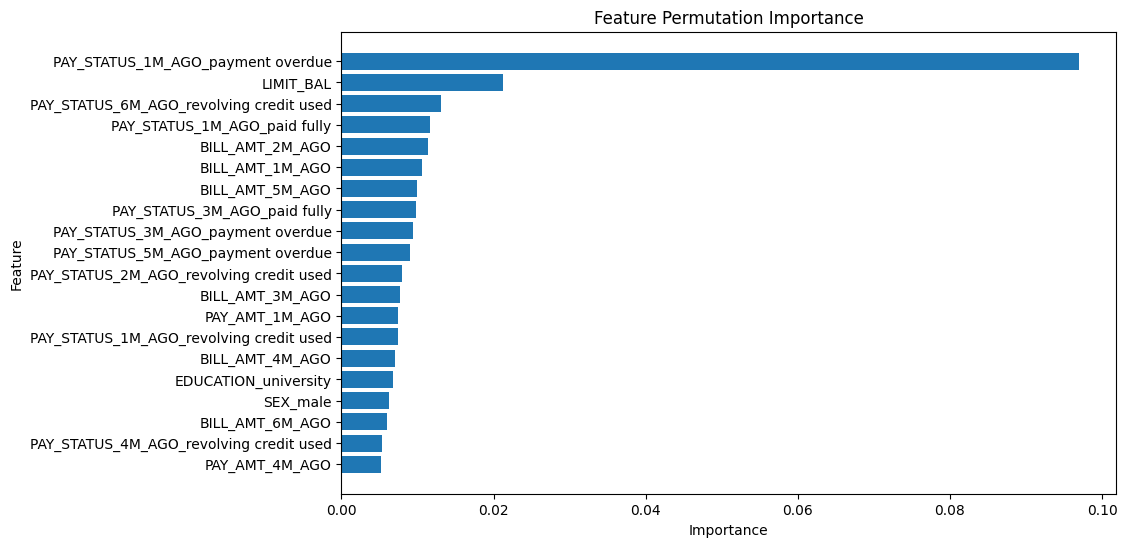

In [ ]:
plot_feat_permut_importance(et2_feat_permut_import_df)

In [ ]:
et2_perf, et2_orig_missing, et2_missing = measure_performance_decline(
    X_train, X_test, y_test, et2_classifier, et2_feat_permut_import_df,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family
)


--- NEW ITERATION ---
Removing feature:  PAY_STATUS_1M_AGO_payment overdue
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used']
Original feat removed so far:  ['PAY_STATUS_1M_AGO']

--- NEW ITERATION ---
Removing feature:  LIMIT_BAL
Original feat removed so far:  ['PAY_STATUS_1M_AGO', 'LIMIT_BAL']

--- NEW ITERATION ---
Removing feature:  PAY_STATUS_6M_AGO_revolving credit used
Removing related features:  ['PAY_STATUS_6M_AGO_paid fully', 'PAY_STATUS_6M_AGO_payment overdue', 'PAY_STATUS_6M_AGO_revolving credit used']
Original feat removed so far:  ['PAY_STATUS_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_6M_AGO']

--- NEW ITERATION ---

--- NEW ITERATION ---
Removing feature:  BILL_AMT_2M_AGO
Original feat removed so far:  ['PAY_STATUS_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_6M_AGO', 'BILL_AMT_2M_AGO']

--- NEW ITERATION ---
Removing feature:  BILL_AMT_1M_AGO
Original feat removed so far:  ['PAY_STATUS_1M_AGO', 'LIM

In [ ]:
et2_perf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0   807  3757  916   520      46.84   60.81        80.40     76.07     52.92   
1   512  4164  509   815      50.15   38.58        89.11     77.93     43.61   
2   432  4276  397   895      52.11   32.55        91.50     78.47     40.07   
3   405  4307  366   922      52.53   30.52        92.17     78.53     38.61   
4   402  4312  361   925      52.69   30.29        92.27     78.57     38.47   
5   397  4319  354   930      52.86   29.92        92.42     78.60     38.21   
6   396  4322  351   931      53.01   29.84        92.49     78.63     38.19   
7   521  4181  492   806      51.43   39.26        89.47     78.37     44.53   
8   492  4251  422   835      53.83   37.08        90.97     79.05     43.91   
9   264  4492  181  1063      59.33   19.89        96.13     79.27     29.80   
10  272  4498  175  1055      60.85   20.50        96.26     79.50     30.67   
11  274  4496  177  1053      60.75   20.65        96.21     79.50     30.82   
12  270  4504  169  1057      61.50   20.35        96.38     79.57     30.58   
13  258  4517  156  1069      62.32   19.44        96.66     79.58     29.64   
14  262  4511  162  1065      61.79   19.74        96.53     79.55     29.93   
15  284  4496  177  1043      61.61   21.40        96.21     79.67     31.77   
16    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
17    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
18    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
19    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
20    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   

    balanced_accuracy  num_feat_missing  \
0               70.61                 0   
1               63.85                 1   
2               62.03                 2   
3               61.34                 3   
4               61.28                 4   
5               61.17                 5   
6               61.17                 6   
7               64.37                 7   
8               64.02                 8   
9               58.01                 9   
10              58.38                10   
11              58.43                11   
12              58.37                12   
13              58.05                13   
14              58.14                14   
15              58.81                15   
16              50.00                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
2   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
3   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
4   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
5   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
6   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
7   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
8   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
9   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
10  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
11  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
12  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
13  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
14  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
15  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
16  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
17  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
18  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
19  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
20  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

et2_perf_mf, et2_orig_missing_mf, et2_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, et2_classifier, et2_feat_permut_import_df,
    imputation_dict=None, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 14:25:29.157063

--- NEW ITERATION ---
Removing feature:  PAY_STATUS_1M_AGO_payment overdue
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used']
Nr. columns with nan:  3
Numerical columns:  ['LIMIT_BAL', 'AGE', 'BILL_AMT_1M_AGO', 'BILL_AMT_2M_AGO', 'BILL_AMT_3M_AGO', 'BILL_AMT_4M_AGO', 'BILL_AMT_5M_AGO', 'BILL_AMT_6M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO']
Categorical columns:  ['SEX_male', 'EDUCATION_high school', 'EDUCATION_others', 'EDUCATION_university', 'MARRIAGE_married', 'MARRIAGE_others', 'MARRIAGE_single', 'PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used', 'PAY_STATUS_2M_AGO_paid fully', 'PAY_STATUS_2M_AGO_payment overdue', 'PAY_

In [ ]:
et2_perf_mf

tp    tn   fp   fn  precision  recall  specificity  accuracy  f1_score  \
0   807  3757  916  520      46.84   60.81        80.40     76.07     52.92   
1   690  3818  855  637      44.66   52.00        81.70     75.13     48.05   
2   666  3835  838  661      44.28   50.19        82.07     75.02     47.05   
3   656  3899  774  671      45.87   49.43        83.44     75.92     47.59   
4   647  3918  755  680      46.15   48.76        83.84     76.08     47.42   
5   609  3980  693  718      46.77   45.89        85.17     76.48     46.33   
6   610  3977  696  717      46.71   45.97        85.11     76.45     46.33   
7   620  3900  773  707      44.51   46.72        83.46     75.33     45.59   
8   542  4139  534  785      50.37   40.84        88.57     78.02     45.11   
9   387  4331  342  940      53.09   29.16        92.68     78.63     37.65   
10  383  4339  334  944      53.42   28.86        92.85     78.70     37.48   
11  380  4342  331  947      53.45   28.64        92.92     78.70     37.29   
12  377  4351  322  950      53.93   28.41        93.11     78.80     37.22   
13  380  4358  315  947      54.68   28.64        93.26     78.97     37.59   
14  420  4307  366  907      53.44   31.65        92.17     78.78     39.75   
15  439  4294  379  888      53.67   33.08        91.89     78.88     40.93   
16  386  4350  323  941      54.44   29.09        93.09     78.93     37.92   
17  395  4347  326  932      54.79   29.77        93.02     79.03     38.57   
18  402  4348  325  925      55.30   30.29        93.05     79.17     39.14   
19  401  4349  324  926      55.31   30.22        93.07     79.17     39.08   
20  332  4429  244  995      57.64   25.02        94.78     79.35     34.89   

    balanced_accuracy  num_feat_missing  \
0               70.61                 0   
1               66.85                 1   
2               66.13                 2   
3               66.44                 3   
4               66.30                 4   
5               65.53                 5   
6               65.54                 6   
7               65.09                 7   
8               64.71                 8   
9               60.92                 9   
10              60.86                10   
11              60.78                11   
12              60.76                12   
13              60.95                13   
14              61.91                14   
15              62.49                15   
16              61.09                16   
17              61.40                17   
18              61.67                18   
19              61.64                19   
20              59.90                20   

                                              imputed  
0                                                      
1   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
2   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
3   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
4   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
5   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
6   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
7   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
8   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
9   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
10  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
11  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
12  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
13  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
14  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
15  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
16  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
17  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
18  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
19  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
20  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...

In [ ]:
et2_perf_temp, et2_orig_missing_temp, et2_missing_temp = measure_temporal_performance_decline(
    X_train, X_test, y_test, et2_classifier, et2_feat_permut_import_df,
    default_cc_timeline_vars_family,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family, log_info=True
)


--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  45
length removed:  0

Removing feature:  PAY_STATUS_1M_AGO_payment overdue
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_payment overdue
Removing related features:  []
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Columns with zero variance, i.e. imputed:
                                    feature  variance
2                           BILL_AMT_1M_AGO       0.0
8                            PAY_AMT_1M_AGO       0.0
14                     

In [ ]:
et2_perf_temp

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0  807  3757  916   520      46.84   60.81        80.40     76.07     52.92   
1  422  4278  395   905      51.65   31.80        91.55     78.33     39.37   
2  399  4316  357   928      52.78   30.07        92.36     78.58     38.31   
3  394  4319  354   933      52.67   29.69        92.42     78.55     37.98   
4  283  4453  220  1044      56.26   21.33        95.29     78.93     30.93   
5   12  4653   20  1315      37.50    0.90        99.57     77.75      1.77   
6   24  4655   18  1303      57.14    1.81        99.61     77.98      3.51   

   balanced_accuracy  num_feat_missing  \
0              70.61                 0   
1              61.67                 4   
2              61.21                 5   
3              61.06                 9   
4              58.31                13   
5              50.24                17   
6              50.71                21   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

et2_perf_temp_mf, et2_orig_missing_temp_mf, et2_missing_temp_mf = measure_temporal_performance_decline(
    X_train, X_test, y_test, et2_classifier, et2_feat_permut_import_df,
    default_cc_timeline_vars_family, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars, log_info=True
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 14:32:00.293577

--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  45
length removed:  0

Removing feature:  PAY_STATUS_1M_AGO_payment overdue
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_payment overdue
Removing related features:  []
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Nr. columns with nan:  6
Numerical columns:  ['LIMIT_BAL', 'AGE', 'BILL_AMT_1M_AGO', 'BILL_AMT_2M_AGO', 'BILL_AMT_3M_AGO', 'BILL_AMT_4M_AGO', 'BILL_AMT_5M_AGO', 'BILL_AMT_6M_AGO', 'PAY_AMT_1M_AGO', 'P

In [ ]:
et2_perf_temp_mf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0  807  3757  916   520      46.84   60.81        80.40     76.07     52.92   
1  642  3885  788   685      44.90   48.38        83.14     75.45     46.57   
2  616  3922  751   711      45.06   46.42        83.93     75.63     45.73   
3  608  3968  705   719      46.31   45.82        84.91     76.27     46.06   
4  608  3696  977   719      38.36   45.82        79.09     71.73     41.76   
5  462  4172  501   865      47.98   34.82        89.28     77.23     40.35   
6  232  4443  230  1095      50.22   17.48        95.08     77.92     25.94   

   balanced_accuracy  num_feat_missing  \
0              70.61                 0   
1              65.76                 4   
2              65.17                 5   
3              65.37                 9   
4              62.46                13   
5              62.05                17   
6              56.28                21   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

## **Support Vector Classifier**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  svm2_param_grid = {
      'C': [0.01, 0.1, 0.5, 1, 5],
      'kernel': ['linear', 'rbf'],
      'gamma': ['scale', 0.1, 0.5, 1]
  }
else:
  # best model
  svm2_param_grid = {
      'C': [1.0],
      'kernel': ['rbf'],
      'gamma': ['scale']
}

svm2_classifier = SVC(
    class_weight='balanced', cache_size=1000, random_state=RANDOM_STATE
)
svm2_grid_search, svm2_best_model, svm2_best_params = hyperparameter_tuning(
    svm2_classifier, svm2_param_grid, 3, 3, 'balanced_accuracy',
    X_train_scaled, y_train
)

Starting hyperparameter tuning at: 2025-01-18 11:48:12.853083

Nested Cross-validation Results:
Individual scores: [0.71066534 0.70497955 0.69920151]
Average nested CV score: 0.705 (+/- 0.009)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'C': 1.0, 'gamma': 'scale', 'kernel': 'rbf'}

Best Model Performance:
Best CV score: 0.705
2025-01-18 11:49:40.998607

Execution time: 1.47 minutes


```
Starting hyperparameter tuning at: 2025-01-17 18:09:18.949949

Nested Cross-validation Results:
Individual scores: [0.71228097 0.70359614 0.69920151]
Average nested CV score: 0.705 (+/- 0.011)

Fitting final model on entire dataset...
Fitting 3 folds for each of 40 candidates, totalling 120 fits
Best parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}

Best Model Performance:
Best CV score: 0.705
2025-01-17 18:32:26.738479

Execution time: 23.13 minutes
```

In [ ]:
svm2_classifier, train_pred, test_pred = apply_model(svm2_best_model, X_train_scaled, y_train, X_test_scaled, y_test)
svm2_feat_permut_import_df = analyze_feat_permut_import(
    svm2_classifier, X_train_scaled, y_train,
    scoring_metric="balanced_accuracy", n_repeats=3
)
svm2_feat_permut_import_df[svm2_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
28        PAY_STATUS_1M_AGO_payment overdue    0.067774  0.002092
31        PAY_STATUS_2M_AGO_payment overdue    0.014462  0.000604
37        PAY_STATUS_4M_AGO_payment overdue    0.007340  0.001040
34        PAY_STATUS_3M_AGO_payment overdue    0.006481  0.000973
32  PAY_STATUS_2M_AGO_revolving credit used    0.002279  0.000579
40        PAY_STATUS_5M_AGO_payment overdue    0.001807  0.000794
36             PAY_STATUS_4M_AGO_paid fully    0.001541  0.000518
44  PAY_STATUS_6M_AGO_revolving credit used    0.001534  0.000094
20                                 SEX_male    0.001449  0.000298
39             PAY_STATUS_5M_AGO_paid fully    0.001398  0.000335
23                     EDUCATION_university    0.001101  0.000599
30             PAY_STATUS_2M_AGO_paid fully    0.000926  0.000220
42             PAY_STATUS_6M_AGO_paid fully    0.000911  0.000423
24                         MARRIAGE_married    0.000789  0.000326
22                         EDUCATION_others    0.000609  0.000241
26                          MARRIAGE_single    0.000604  0.000218
43        PAY_STATUS_6M_AGO_payment overdue    0.000379  0.000437
33             PAY_STATUS_3M_AGO_paid fully    0.000360  0.000127
41  PAY_STATUS_5M_AGO_revolving credit used    0.000357  0.000237
0                                 LIMIT_BAL    0.000350  0.000203
2                           BILL_AMT_1M_AGO    0.000143  0.000028
5                           BILL_AMT_4M_AGO    0.000116  0.000064
8                            PAY_AMT_1M_AGO    0.000089  0.000013
35  PAY_STATUS_3M_AGO_revolving credit used    0.000083  0.000017
38  PAY_STATUS_4M_AGO_revolving credit used    0.000075  0.000586
25                          MARRIAGE_others    0.000045  0.000013
13                           PAY_AMT_6M_AGO    0.000045  0.000013
3                           BILL_AMT_2M_AGO    0.000040  0.000040
6                           BILL_AMT_5M_AGO    0.000036  0.000025
12                           PAY_AMT_5M_AGO    0.000027  0.000022
10                           PAY_AMT_3M_AGO    0.000027  0.000000
9                            PAY_AMT_2M_AGO    0.000009  0.000025
11                           PAY_AMT_4M_AGO    0.000009  0.000025
21                    EDUCATION_high school   -0.000001  0.000275
17                         PAY_DELAY_4M_AGO   -0.000005  0.000051
4                           BILL_AMT_3M_AGO   -0.000027  0.000000
7                           BILL_AMT_6M_AGO   -0.000036  0.000064
27             PAY_STATUS_1M_AGO_paid fully   -0.000054  0.000173
14                         PAY_DELAY_1M_AGO   -0.000076  0.000115
1                                       AGE   -0.000082  0.000227
15                         PAY_DELAY_2M_AGO   -0.000113  0.000123
29  PAY_STATUS_1M_AGO_revolving credit used   -0.000127  0.000764
18                         PAY_DELAY_5M_AGO   -0.000212  0.000220
19                         PAY_DELAY_6M_AGO   -0.000246  0.000023
16                         PAY_DELAY_3M_AGO   -0.000254  0.000057

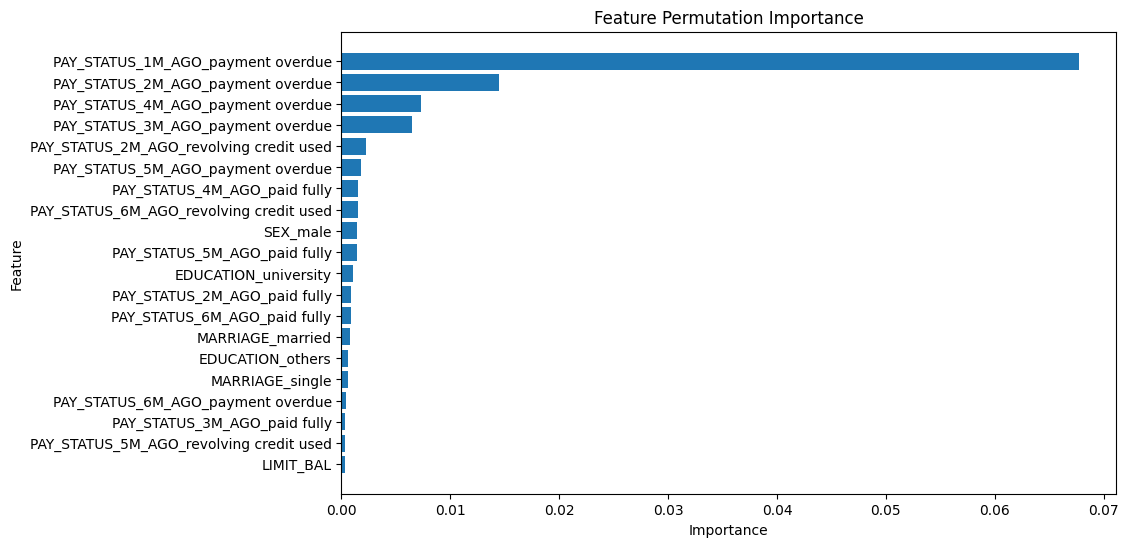

In [ ]:
plot_feat_permut_importance(svm2_feat_permut_import_df)

In [ ]:
svm2_perf, svm2_orig_missing, svm2_missing = measure_performance_decline(
    X_train_scaled, X_test_scaled, y_test, svm2_classifier, svm2_feat_permut_import_df,
    default_cc_imputation_scaled_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family
)


--- NEW ITERATION ---
Removing feature:  PAY_STATUS_1M_AGO_payment overdue
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used']
Original feat removed so far:  ['PAY_STATUS_1M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_STATUS_2M_AGO_payment overdue
Removing related features:  ['PAY_STATUS_2M_AGO_paid fully', 'PAY_STATUS_2M_AGO_payment overdue', 'PAY_STATUS_2M_AGO_revolving credit used']
Original feat removed so far:  ['PAY_STATUS_1M_AGO', 'PAY_STATUS_2M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_STATUS_4M_AGO_payment overdue
Removing related features:  ['PAY_STATUS_4M_AGO_paid fully', 'PAY_STATUS_4M_AGO_payment overdue', 'PAY_STATUS_4M_AGO_revolving credit used']
Original feat removed so far:  ['PAY_STATUS_1M_AGO', 'PAY_STATUS_2M_AGO', 'PAY_STATUS_4M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_STATUS_3M_AGO_payment overdue
Removing related features:  ['PAY_STATUS_3M_AGO_pai

In [ ]:
svm2_perf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0   756  3847  826   571      47.79   56.97        82.32     76.72     51.98   
1   599  4011  662   728      47.50   45.14        85.83     76.83     46.29   
2   444  4194  479   883      48.10   33.46        89.75     77.30     39.47   
3   371  4318  355   956      51.10   27.96        92.40     78.15     36.14   
4   282  4451  222  1045      55.95   21.25        95.25     78.88     30.80   
5    61  4647   26  1266      70.11    4.60        99.44     78.47      8.63   
6    23  4657   16  1304      58.97    1.73        99.66     78.00      3.37   
7    22  4656   17  1305      56.41    1.66        99.64     77.97      3.22   
8    22  4657   16  1305      57.89    1.66        99.66     77.98      3.22   
9    20  4657   16  1307      55.56    1.51        99.66     77.95      2.93   
10   20  4657   16  1307      55.56    1.51        99.66     77.95      2.93   
11   21  4657   16  1306      56.76    1.58        99.66     77.97      3.08   
12   21  4656   17  1306      55.26    1.58        99.64     77.95      3.08   
13   21  4656   17  1306      55.26    1.58        99.64     77.95      3.08   
14   21  4657   16  1306      56.76    1.58        99.66     77.97      3.08   
15   21  4657   16  1306      56.76    1.58        99.66     77.97      3.08   
16   21  4657   16  1306      56.76    1.58        99.66     77.97      3.08   
17   21  4657   16  1306      56.76    1.58        99.66     77.97      3.08   
18   21  4657   16  1306      56.76    1.58        99.66     77.97      3.08   
19   21  4657   16  1306      56.76    1.58        99.66     77.97      3.08   
20   21  4657   16  1306      56.76    1.58        99.66     77.97      3.08   

    balanced_accuracy  num_feat_missing  \
0               69.65                 0   
1               65.49                 1   
2               61.60                 2   
3               60.18                 3   
4               58.25                 4   
5               52.02                 5   
6               50.70                 6   
7               50.65                 7   
8               50.66                 8   
9               50.58                 9   
10              50.58                10   
11              50.62                11   
12              50.61                12   
13              50.61                13   
14              50.62                14   
15              50.62                15   
16              50.62                16   
17              50.62                17   
18              50.62                18   
19              50.62                19   
20              50.62                20   

                                              imputed  
0                                                      
1   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
2   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
3   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
4   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
5   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
6   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
7   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
8   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
9   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
10  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
11  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
12  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
13  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
14  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
15  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
16  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
17  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
18  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
19  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
20  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

svm2_perf_mf, svm2_orig_missing_mf, svm2_missing_mf = measure_performance_decline(
    X_train_scaled, X_test_scaled, y_test, svm2_classifier, svm2_feat_permut_import_df,
    imputation_dict=None, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 14:35:43.976566

--- NEW ITERATION ---
Removing feature:  PAY_STATUS_1M_AGO_payment overdue
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used']
Nr. columns with nan:  3
Numerical columns:  ['LIMIT_BAL', 'AGE', 'BILL_AMT_1M_AGO', 'BILL_AMT_2M_AGO', 'BILL_AMT_3M_AGO', 'BILL_AMT_4M_AGO', 'BILL_AMT_5M_AGO', 'BILL_AMT_6M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO']
Categorical columns:  ['SEX_male', 'EDUCATION_high school', 'EDUCATION_others', 'EDUCATION_university', 'MARRIAGE_married', 'MARRIAGE_others', 'MARRIAGE_single', 'PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used', 'PAY_STATUS_2M_AGO_paid fully', 'PAY_STATUS_2M_AGO_payment overdue', 'PAY_

In [ ]:
svm2_perf_mf

tp    tn    fp    fn  precision  recall  specificity  accuracy  f1_score  \
0   756  3847   826   571      47.79   56.97        82.32     76.72     51.98   
1   604  3980   693   723      46.57   45.52        85.17     76.40     46.04   
2   610  3667  1006   717      37.75   45.97        78.47     71.28     41.45   
3   466  4151   522   861      47.17   35.12        88.83     76.95     40.26   
4   226  4518   155  1101      59.32   17.03        96.68     79.07     26.46   
5    77  4637    36  1250      68.14    5.80        99.23     78.57     10.69   
6     7  4668     5  1320      58.33    0.53        99.89     77.92      1.05   
7     6  4668     5  1321      54.55    0.45        99.89     77.90      0.90   
8     7  4668     5  1320      58.33    0.53        99.89     77.92      1.05   
9     1  4670     3  1326      25.00    0.08        99.94     77.85      0.15   
10    1  4670     3  1326      25.00    0.08        99.94     77.85      0.15   
11    1  4670     3  1326      25.00    0.08        99.94     77.85      0.15   
12    2  4670     3  1325      40.00    0.15        99.94     77.87      0.30   
13    2  4670     3  1325      40.00    0.15        99.94     77.87      0.30   
14    2  4670     3  1325      40.00    0.15        99.94     77.87      0.30   
15    2  4670     3  1325      40.00    0.15        99.94     77.87      0.30   
16    2  4670     3  1325      40.00    0.15        99.94     77.87      0.30   
17    2  4670     3  1325      40.00    0.15        99.94     77.87      0.30   
18    2  4670     3  1325      40.00    0.15        99.94     77.87      0.30   
19    2  4670     3  1325      40.00    0.15        99.94     77.87      0.30   
20    2  4670     3  1325      40.00    0.15        99.94     77.87      0.30   

    balanced_accuracy  num_feat_missing  \
0               69.65                 0   
1               65.34                 1   
2               62.22                 2   
3               61.97                 3   
4               56.86                 4   
5               52.52                 5   
6               50.21                 6   
7               50.17                 7   
8               50.21                 8   
9               50.01                 9   
10              50.01                10   
11              50.01                11   
12              50.04                12   
13              50.04                13   
14              50.04                14   
15              50.04                15   
16              50.04                16   
17              50.04                17   
18              50.04                18   
19              50.04                19   
20              50.04                20   

                                              imputed  
0                                                      
1   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
2   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
3   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
4   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
5   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
6   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
7   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
8   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
9   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
10  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
11  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
12  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
13  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
14  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
15  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
16  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
17  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
18  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
19  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
20  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...

In [ ]:
svm2_perf_temp, svm2_orig_missing_temp, svm2_missing_temp = measure_temporal_performance_decline(
    X_train_scaled, X_test_scaled, y_test, svm2_classifier, svm2_feat_permut_import_df,
    default_cc_timeline_vars_family,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family, log_info=True
)


--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  45
length removed:  0

Removing feature:  PAY_STATUS_1M_AGO_payment overdue
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_payment overdue
Removing related features:  []
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Columns with zero variance, i.e. imputed:
                                    feature  variance
2                           BILL_AMT_1M_AGO       0.0
8                            PAY_AMT_1M_AGO       0.0
14                     

In [ ]:
svm2_perf_temp

tp    tn    fp   fn  precision  recall  specificity  accuracy  f1_score  \
0   756  3847   826  571      47.79   56.97        82.32     76.72     51.98   
1  1327     0  4673    0      22.12  100.00         0.00     22.12     36.22   
2  1327     0  4673    0      22.12  100.00         0.00     22.12     36.22   
3  1327     0  4673    0      22.12  100.00         0.00     22.12     36.22   
4  1327     0  4673    0      22.12  100.00         0.00     22.12     36.22   
5  1327     0  4673    0      22.12  100.00         0.00     22.12     36.22   

   balanced_accuracy  num_feat_missing  \
0              69.65                 0   
1              50.00                 4   
2              50.00                 8   
3              50.00                12   
4              50.00                16   
5              50.00                20   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

svm2_perf_temp_mf, svm2_orig_missing_temp_mf, svm2_missing_temp_mf = measure_temporal_performance_decline(
    X_train_scaled, X_test_scaled, y_test, svm2_classifier, svm2_feat_permut_import_df,
    default_cc_timeline_vars_family, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars, log_info=True
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 14:44:41.331231

--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  45
length removed:  0

Removing feature:  PAY_STATUS_1M_AGO_payment overdue
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_payment overdue
Removing related features:  []
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Nr. columns with nan:  6
Numerical columns:  ['LIMIT_BAL', 'AGE', 'BILL_AMT_1M_AGO', 'BILL_AMT_2M_AGO', 'BILL_AMT_3M_AGO', 'BILL_AMT_4M_AGO', 'BILL_AMT_5M_AGO', 'BILL_AMT_6M_AGO', 'PAY_AMT_1M_AGO', 'P

In [ ]:
svm2_perf_temp_mf

tp    tn    fp    fn  precision  recall  specificity  accuracy  f1_score  \
0  756  3847   826   571      47.79   56.97        82.32     76.72     51.98   
1  605  3985   688   722      46.79   45.59        85.28     76.50     46.18   
2  603  3669  1004   724      37.52   45.44        78.51     71.20     41.10   
3  456  4155   518   871      46.82   34.36        88.92     76.85     39.63   
4  204  4527   146  1123      58.29   15.37        96.88     78.85     24.33   
5    8  4671     2  1319      80.00    0.60        99.96     77.98      1.20   

   balanced_accuracy  num_feat_missing  \
0              69.65                 0   
1              65.43                 4   
2              61.98                 8   
3              61.64                12   
4              56.12                16   
5              50.28                20   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

##**Logistic Regression**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  lr2_param_grid = {
      'C': [0.1, 1, 2, 5, 10, 20, 100],       # Regularization strength
      'penalty': ['l2', 'l1', 'elasticnet'],  # Regularization type
      'solver': ['liblinear', 'saga']         # Algorithm to use in the optimization problem
  }
else:
  lr2_param_grid = {
      'C': [20.0],
      'penalty': ['l1'],
      'solver': ['saga']
  }

lr2_classifier = LogisticRegression(class_weight='balanced', random_state=RANDOM_STATE)
lr2_grid_search, lr2_best_model, lr2_best_params = hyperparameter_tuning(
    lr2_classifier, lr2_param_grid, 3, 3, 'balanced_accuracy', lr_X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-18 12:10:20.793917

Nested Cross-validation Results:
Individual scores: [0.71194317 0.7041067  0.70126869]
Average nested CV score: 0.706 (+/- 0.009)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'C': 20.0, 'penalty': 'l1', 'solver': 'saga'}

Best Model Performance:
Best CV score: 0.706
2025-01-18 12:10:28.436422

Execution time: 0.13 minutes


```
Starting hyperparameter tuning at: 2025-01-17 21:07:24.269959

Nested Cross-validation Results:
Individual scores: [0.71194317 0.7020105  0.70118844]
Average nested CV score: 0.705 (+/- 0.010)

Fitting final model on entire dataset...
Fitting 3 folds for each of 42 candidates, totalling 126 fits
Best parameters: {'C': 20, 'penalty': 'l1', 'solver': 'saga'}

Best Model Performance:
Best CV score: 0.706
2025-01-17 21:07:53.870464

Execution time: 0.49 minutes
```

In [ ]:
lr2_classifier, train_pred, test_pred = apply_model(lr2_best_model, lr_X_train, y_train, lr_X_test, y_test)
lr2_feat_permut_import_df = analyze_feat_permut_import(lr2_classifier, lr_X_train, y_train, scoring_metric="balanced_accuracy")
lr2_feat_permut_import_df[lr2_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
0                          PAY_DELAY_1M_AGO    0.083855  0.002476
7                                 LIMIT_BAL    0.010966  0.001366
22             PAY_STATUS_1M_AGO_paid fully    0.005078  0.000550
2                          PAY_DELAY_3M_AGO    0.004887  0.000623
17  PAY_STATUS_6M_AGO_revolving credit used    0.003065  0.000475
29                          BILL_AMT_1M_AGO    0.002851  0.001315
3                          PAY_DELAY_4M_AGO    0.002628  0.000762
4                          PAY_DELAY_5M_AGO    0.002382  0.000696
19             PAY_STATUS_2M_AGO_paid fully    0.001283  0.000378
24                         EDUCATION_others    0.001283  0.000353
8                            PAY_AMT_1M_AGO    0.001143  0.000625
9                            PAY_AMT_2M_AGO    0.000917  0.000644
26                                 SEX_male    0.000830  0.000608
6   PAY_STATUS_1M_AGO_revolving credit used    0.000820  0.001017
28                          MARRIAGE_single    0.000642  0.000584
18             PAY_STATUS_3M_AGO_paid fully    0.000372  0.000184
27                    EDUCATION_high school    0.000322  0.000106
32                          MARRIAGE_others    0.000244  0.000180
31                          BILL_AMT_6M_AGO    0.000142  0.000420
15                           PAY_AMT_6M_AGO    0.000079  0.000284
30                                      AGE    0.000065  0.000377
5                          PAY_DELAY_6M_AGO    0.000034  0.000198
23             PAY_STATUS_6M_AGO_paid fully   -0.000021  0.000017
16  PAY_STATUS_5M_AGO_revolving credit used   -0.000037  0.000128
21             PAY_STATUS_5M_AGO_paid fully   -0.000053  0.000152
13                           PAY_AMT_4M_AGO   -0.000053  0.000201
10  PAY_STATUS_3M_AGO_revolving credit used   -0.000055  0.000318
1                          PAY_DELAY_2M_AGO   -0.000067  0.000049
12  PAY_STATUS_4M_AGO_revolving credit used   -0.000219  0.000250
11                           PAY_AMT_3M_AGO   -0.000238  0.000171
25                     EDUCATION_university   -0.000323  0.000245
20             PAY_STATUS_4M_AGO_paid fully   -0.000379  0.000225
14                           PAY_AMT_5M_AGO   -0.000401  0.000360

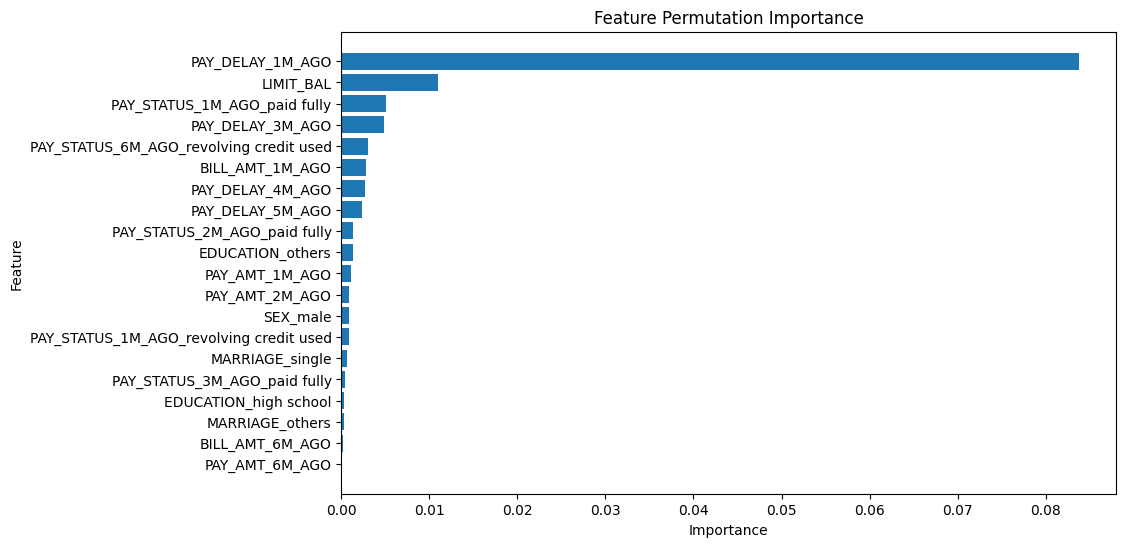

In [ ]:
plot_feat_permut_importance(lr2_feat_permut_import_df)

In [ ]:
lr2_perf, lr2_orig_missing, lr2_missing = measure_performance_decline(
    lr_X_train, lr_X_test, y_test, lr2_classifier, lr2_feat_permut_import_df,
    default_cc_imputation_scaled_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family
)


--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO']

--- NEW ITERATION ---
Removing feature:  LIMIT_BAL
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL']

--- NEW ITERATION ---
Removing feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_revolving credit used']
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_1M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_3M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_1M_AGO', 'PAY_DELAY_3M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_STATUS_6M_AGO_revolving credit used
Removing related features:  ['PAY_STATUS_6M_AGO_paid fully', 'PAY_STATUS_6M_AGO_revolving credit used']
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_1M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_STATUS_6M_AGO']

--- NEW ITERATION ---
Removing f

In [ ]:
lr2_perf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0   774  3799  874   553      46.97   58.33        81.30     76.22     52.03   
1   481  4185  488   846      49.64   36.25        89.56     77.77     41.90   
2   442  4222  451   885      49.50   33.31        90.35     77.73     39.82   
3   444  4204  469   883      48.63   33.46        89.96     77.47     39.64   
4   357  4316  357   970      50.00   26.90        92.36     77.88     34.98   
5   263  4427  246  1064      51.67   19.82        94.74     78.17     28.65   
6   208  4546  127  1119      62.09   15.67        97.28     79.23     25.03   
7    55  4644   29  1272      65.48    4.14        99.38     78.32      7.80   
8     0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
9     0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
10    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
11    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
12    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
13    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
14    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
15    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
16    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
17    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
18    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
19    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
20    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   

    balanced_accuracy  num_feat_missing  \
0               69.81                 0   
1               62.90                 1   
2               61.83                 2   
3               61.71                 3   
4               59.63                 4   
5               57.28                 5   
6               56.48                 6   
7               51.76                 7   
8               50.00                 8   
9               50.00                 9   
10              50.00                10   
11              50.00                11   
12              50.00                12   
13              50.00                13   
14              50.00                14   
15              50.00                15   
16              50.00                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2           ['PAY_DELAY_1M_AGO', 'LIMIT_BAL'] imputed  
3   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
4   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
5   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
6   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
7   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
8   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
9   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
10  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
11  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
12  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
13  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
14  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
15  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
16  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
17  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
18  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
19  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
20  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

lr2_perf_mf, lr2_orig_missing_mf, lr2_missing_mf = measure_performance_decline(
    lr_X_train, lr_X_test, y_test, lr2_classifier, lr2_feat_permut_import_df,
    imputation_dict=None, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=lr_default_cc_cat_vars
)


print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 14:46:50.101502

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Nr. columns with nan:  1
Numerical columns:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO', 'LIMIT_BAL', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'BILL_AMT_1M_AGO', 'AGE', 'BILL_AMT_6M_AGO']
Categorical columns:  ['PAY_STATUS_1M_AGO_revolving credit used', 'PAY_STATUS_3M_AGO_revolving credit used', 'PAY_STATUS_4M_AGO_revolving credit used', 'PAY_STATUS_5M_AGO_revolving credit used', 'PAY_STATUS_6M_AGO_revolving credit used', 'PAY_STATUS_3M_AGO_paid fully', 'PAY_STATUS_2M_AGO_paid fully', 'PAY_STATUS_4M_AGO_paid fully', 'PAY_STATUS_5M_AGO_paid fully', 'PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_6M_AGO_paid fully', 'EDUCATION_others', 'EDUCATION_university', 'SEX_male', 'EDUCATION_high school', 'MARRIAGE_single', 'MARRIAGE_others']
Column imputed:  PAY_DELAY_1M_AGO

In [ ]:
lr2_perf_mf

tp    tn   fp   fn  precision  recall  specificity  accuracy  f1_score  \
0   774  3799  874  553      46.97   58.33        81.30     76.22     52.03   
1   713  3724  949  614      42.90   53.73        79.69     73.95     47.71   
2   698  3799  874  629      44.40   52.60        81.30     74.95     48.15   
3   674  3839  834  653      44.69   50.79        82.15     75.22     47.55   
4   668  3853  820  659      44.89   50.34        82.45     75.35     47.46   
5   650  3865  808  677      44.58   48.98        82.71     75.25     46.68   
6   615  3974  699  712      46.80   46.35        85.04     76.48     46.57   
7   606  3983  690  721      46.76   45.67        85.23     76.48     46.21   
8   576  4045  628  751      47.84   43.41        86.56     77.02     45.52   
9   550  4103  570  777      49.11   41.45        87.80     77.55     44.95   
10  565  4083  590  762      48.92   42.58        87.37     77.47     45.53   
11  593  3974  699  734      45.90   44.69        85.04     76.12     45.28   
12  600  3959  714  727      45.66   45.21        84.72     75.98     45.44   
13  576  4042  631  751      47.72   43.41        86.50     76.97     45.46   
14  507  4213  460  820      52.43   38.21        90.16     78.67     44.20   
15  478  4269  404  849      54.20   36.02        91.35     79.12     43.28   
16  483  4246  427  844      53.08   36.40        90.86     78.82     43.18   
17  483  4243  430  844      52.90   36.40        90.80     78.77     43.12   
18  483  4260  413  844      53.91   36.40        91.16     79.05     43.45   
19  470  4275  398  857      54.15   35.42        91.48     79.08     42.82   
20  469  4271  402  858      53.85   35.34        91.40     79.00     42.68   

    balanced_accuracy  num_feat_missing  \
0               69.81                 0   
1               66.71                 1   
2               66.95                 2   
3               66.47                 3   
4               66.40                 4   
5               65.85                 5   
6               65.69                 6   
7               65.45                 7   
8               64.98                 8   
9               64.62                 9   
10              64.98                10   
11              64.86                11   
12              64.97                12   
13              64.95                13   
14              64.18                14   
15              63.69                15   
16              63.63                16   
17              63.60                17   
18              63.78                18   
19              63.45                19   
20              63.37                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2           ['PAY_DELAY_1M_AGO', 'LIMIT_BAL'] imputed  
3   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
4   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
5   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
6   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
7   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
8   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
9   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
10  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
11  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
12  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
13  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
14  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
15  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
16  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
17  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
18  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
19  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
20  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...

In [ ]:
lr2_perf_temp, lr2_orig_missing_temp, lr2_missing_temp = measure_temporal_performance_decline(
    lr_X_train, lr_X_test, y_test, lr2_classifier, lr2_feat_permut_import_df,
    default_cc_timeline_vars_family,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family, log_info=True
)


--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  33
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Columns with zero variance, i.e. imputed:
                                    feature  variance
0                          PAY_DELAY_1M_AGO       0.0
6   PAY_STATUS_1M_AGO_revolving credit used       0.0
8                            PAY_AMT_1M_AGO       0.0
22             PAY_STATUS_1M_AGO_paid fully       0.0
29                          BILL_AMT_1M_AGO       0.0
Original feat re

In [ ]:
lr2_perf_temp

tp    tn    fp    fn  precision  recall  specificity  accuracy  f1_score  \
0   774  3799   874   553      46.97   58.33         81.3     76.22     52.03   
1  1327     0  4673     0      22.12  100.00          0.0     22.12     36.22   
2     0  4673     0  1327       0.00    0.00        100.0     77.88      0.00   
3     0  4673     0  1327       0.00    0.00        100.0     77.88      0.00   
4     0  4673     0  1327       0.00    0.00        100.0     77.88      0.00   
5     0  4673     0  1327       0.00    0.00        100.0     77.88      0.00   
6     0  4673     0  1327       0.00    0.00        100.0     77.88      0.00   
7     0  4673     0  1327       0.00    0.00        100.0     77.88      0.00   

   balanced_accuracy  num_feat_missing  \
0              69.81                 0   
1              50.00                 4   
2              50.00                 5   
3              50.00                 8   
4              50.00                12   
5              50.00                15   
6              50.00                18   
7              50.00                21   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
7  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

lr2_perf_temp_mf, lr2_orig_missing_temp_mf, lr2_missing_temp_mf = measure_temporal_performance_decline(
    lr_X_train, lr_X_test, y_test, lr2_classifier, lr2_feat_permut_import_df,
    default_cc_timeline_vars_family, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=lr_default_cc_cat_vars, log_info=True
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 14:51:11.668439

--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  33
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Nr. columns with nan:  5
Numerical columns:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO', 'LIMIT_BAL', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'BILL_AMT_1M_AGO', 'AGE', 'BILL_AMT_6M_AGO']
Categorical columns:  [

In [ ]:
lr2_perf_temp_mf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0  774  3799  874   553      46.97   58.33        81.30     76.22     52.03   
1  623  3916  757   704      45.14   46.95        83.80     75.65     46.03   
2  660  3890  783   667      45.74   49.74        83.24     75.83     47.65   
3  588  4064  609   739      49.12   44.31        86.97     77.53     46.59   
4  580  3996  677   747      46.14   43.71        85.51     76.27     44.89   
5  563  4031  642   764      46.72   42.43        86.26     76.57     44.47   
6  500  4129  544   827      47.89   37.68        88.36     77.15     42.18   
7    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   

   balanced_accuracy  num_feat_missing  \
0              69.81                 0   
1              65.37                 4   
2              66.49                 5   
3              65.64                 8   
4              64.61                12   
5              64.34                15   
6              63.02                18   
7              50.00                21   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
7  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

# **Results comparison - Standard Scenario**



## **F1-score**

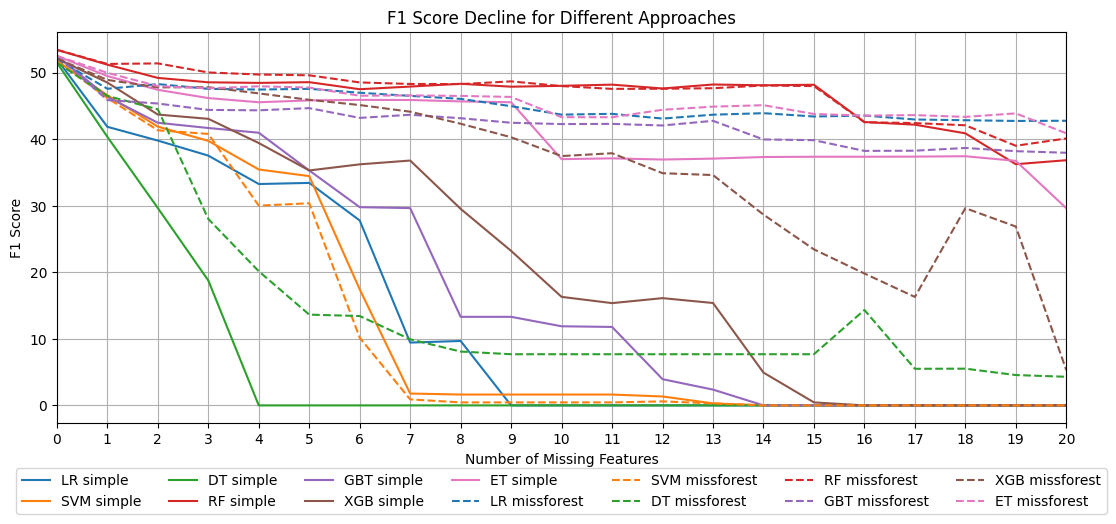

In [ ]:
# # Line plot for the f1 score of the different models
plt.figure(figsize=(12, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']

plt.plot(lr_perf['num_feat_missing'], lr_perf['f1_score'], label='LR simple', color=colors[0])
plt.plot(svm_perf['num_feat_missing'], svm_perf['f1_score'], label='SVM simple', color=colors[1])
plt.plot(dt_perf['num_feat_missing'], dt_perf['f1_score'], label='DT simple', color=colors[2])
plt.plot(rf_perf['num_feat_missing'], rf_perf['f1_score'], label='RF simple', color=colors[3])
plt.plot(gbt_perf['num_feat_missing'], gbt_perf['f1_score'], label='GBT simple', color=colors[4])
plt.plot(xgb_perf['num_feat_missing'], xgb_perf['f1_score'], label='XGB simple', color=colors[5])
plt.plot(et_perf['num_feat_missing'], et_perf['f1_score'], label='ET simple', color=colors[6])

plt.plot(lr_perf_mf['num_feat_missing'], lr_perf_mf['f1_score'], label='LR missforest', color=colors[0], linestyle='--')
plt.plot(svm_perf_mf['num_feat_missing'], svm_perf_mf['f1_score'], label='SVM missforest', color=colors[1], linestyle='--')
plt.plot(dt_perf_mf['num_feat_missing'], dt_perf_mf['f1_score'], label='DT missforest', color=colors[2], linestyle='--')
plt.plot(rf_perf_mf['num_feat_missing'], rf_perf_mf['f1_score'], label='RF missforest', color=colors[3], linestyle='--')
plt.plot(gbt_perf_mf['num_feat_missing'], gbt_perf_mf['f1_score'], label='GBT missforest', color=colors[4], linestyle='--')
plt.plot(xgb_perf_mf['num_feat_missing'], xgb_perf_mf['f1_score'], label='XGB missforest', color=colors[5], linestyle='--')
plt.plot(et_perf_mf['num_feat_missing'], et_perf_mf['f1_score'], label='ET missforest', color=colors[6], linestyle='--')

plt.xlabel('Number of Missing Features')
plt.ylabel('F1 Score')
plt.title('F1 Score Decline for Different Approaches')
plt.xticks(et_perf.index.astype(int))
plt.xticks(range(0, NUM_FEAT+1))
plt.xlim(0, NUM_FEAT)
plt.legend(loc='lower center',  bbox_to_anchor=(0.5, -0.25), ncol=7)
plt.grid(True)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

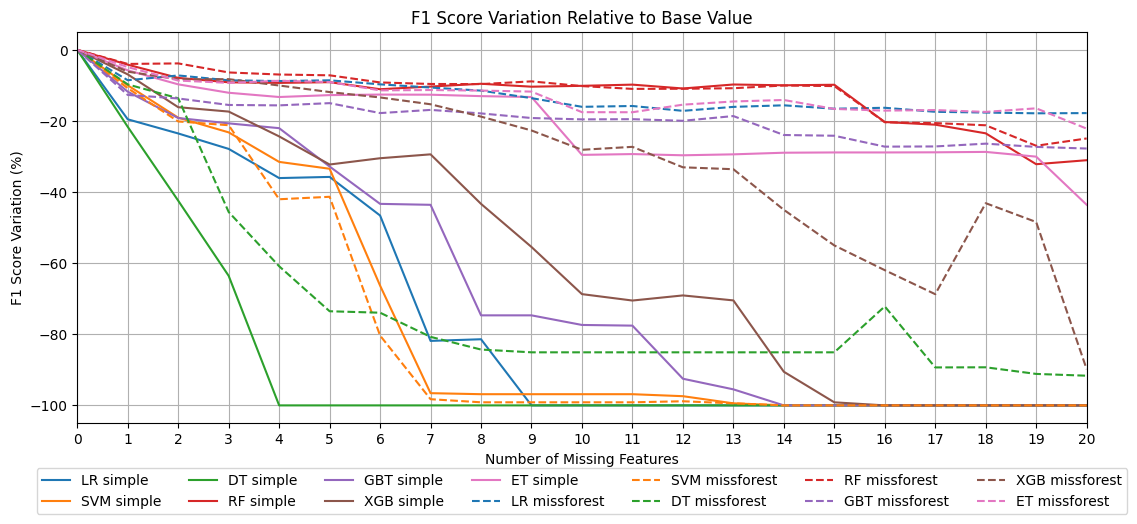

In [ ]:
# Line plot for the f1 score variation relative to the first value
plt.figure(figsize=(12, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2',
          '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
linestyles = ['-', '-', '-', '-', '-', '-', '-', '--', '--', '--', '--', '--', '--', '--']

# Calculate and plot the F1-score variation for each model
for perf_df, label, color, linestyle in zip(
    [lr_perf, svm_perf, dt_perf, rf_perf, gbt_perf, xgb_perf, et_perf,
     lr_perf_mf, svm_perf_mf, dt_perf_mf, rf_perf_mf, gbt_perf_mf, xgb_perf_mf, et_perf_mf],
    ['LR simple', 'SVM simple', 'DT simple', 'RF simple', 'GBT simple', 'XGB simple', 'ET simple',
     'LR missforest', 'SVM missforest', 'DT missforest', 'RF missforest', 'GBT missforest', 'XGB missforest', 'ET missforest'],
    colors,
    linestyles
):
    # Calculate the variation relative to the base F1-score
    f1_variation = (perf_df['f1_score'] - perf_df['f1_score'].iloc[0]) / perf_df['f1_score'].iloc[0] * 100
    plt.plot(perf_df['num_feat_missing'], f1_variation, label=label, color=color, linestyle=linestyle)

plt.xlabel('Number of Missing Features')
plt.ylabel('F1 Score Variation (%)')
plt.title('F1 Score Variation Relative to Base Value')
plt.xticks(range(0, 21))
plt.legend(loc='lower center',  bbox_to_anchor=(0.5, -0.25), ncol=7)
plt.grid(True)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

##**Balanced accuracy**

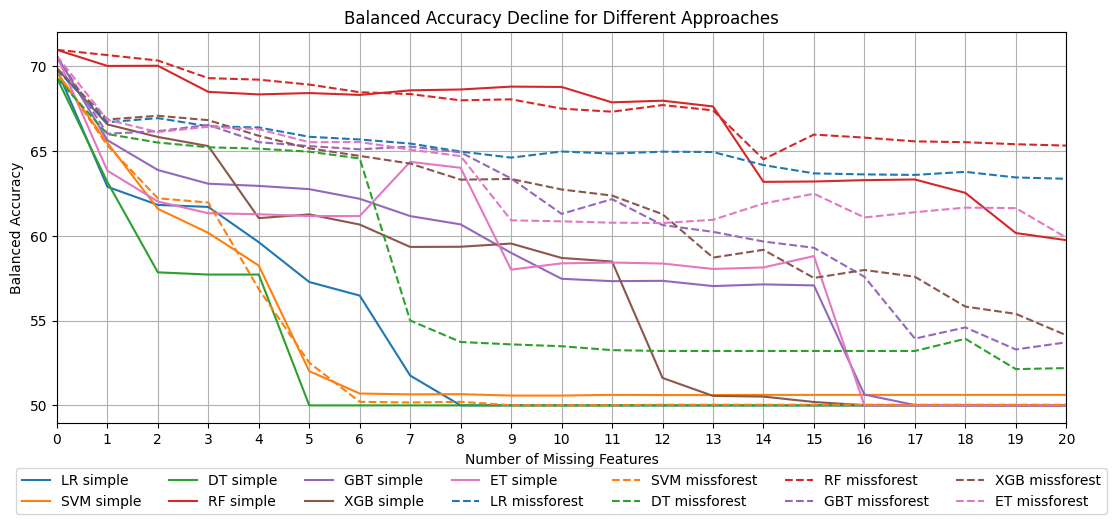

In [ ]:
# # Line plot for the balanced accuracy of the different models
plt.figure(figsize=(12, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']

plt.plot(lr2_perf['num_feat_missing'], lr2_perf['balanced_accuracy'], label='LR simple', color=colors[0])
plt.plot(svm2_perf['num_feat_missing'], svm2_perf['balanced_accuracy'], label='SVM simple', color=colors[1])
plt.plot(dt2_perf['num_feat_missing'], dt2_perf['balanced_accuracy'], label='DT simple', color=colors[2])
plt.plot(rf2_perf['num_feat_missing'], rf2_perf['balanced_accuracy'], label='RF simple', color=colors[3])
plt.plot(gbt2_perf['num_feat_missing'], gbt2_perf['balanced_accuracy'], label='GBT simple', color=colors[4])
plt.plot(xgb2_perf['num_feat_missing'], xgb2_perf['balanced_accuracy'], label='XGB simple', color=colors[5])
plt.plot(et2_perf['num_feat_missing'], et2_perf['balanced_accuracy'], label='ET simple', color=colors[6])

plt.plot(lr2_perf_mf['num_feat_missing'], lr2_perf_mf['balanced_accuracy'], label='LR missforest', color=colors[0], linestyle='--')
plt.plot(svm2_perf_mf['num_feat_missing'], svm2_perf_mf['balanced_accuracy'], label='SVM missforest', color=colors[1], linestyle='--')
plt.plot(dt2_perf_mf['num_feat_missing'], dt2_perf_mf['balanced_accuracy'], label='DT missforest', color=colors[2], linestyle='--')
plt.plot(rf2_perf_mf['num_feat_missing'], rf2_perf_mf['balanced_accuracy'], label='RF missforest', color=colors[3], linestyle='--')
plt.plot(gbt2_perf_mf['num_feat_missing'], gbt2_perf_mf['balanced_accuracy'], label='GBT missforest', color=colors[4], linestyle='--')
plt.plot(xgb2_perf_mf['num_feat_missing'], xgb2_perf_mf['balanced_accuracy'], label='XGB missforest', color=colors[5], linestyle='--')
plt.plot(et2_perf_mf['num_feat_missing'], et2_perf_mf['balanced_accuracy'], label='ET missforest', color=colors[6], linestyle='--')

plt.xlabel('Number of Missing Features')
plt.ylabel('Balanced Accuracy')
plt.title('Balanced Accuracy Decline for Different Approaches')
plt.xticks(range(0, NUM_FEAT+1))
plt.xlim(0, NUM_FEAT)
plt.legend(loc='lower center',  bbox_to_anchor=(0.5, -0.25), ncol=7)
plt.grid(True)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

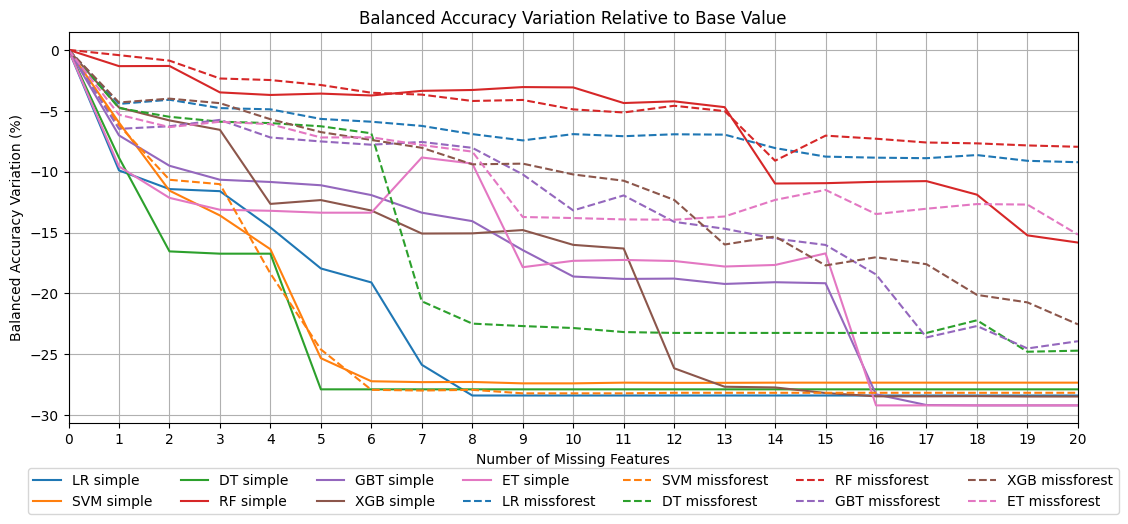

In [ ]:
# Line plot for the balanced accuracy variation relative to the first value
plt.figure(figsize=(12, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2',
          '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
linestyles = ['-', '-', '-', '-', '-', '-', '-', '--', '--', '--', '--', '--', '--', '--']

# Calculate and plot the Balanced Accuracy variation for each model
for perf_df, label, color, linestyle in zip(
    [lr2_perf, svm2_perf, dt2_perf, rf2_perf, gbt2_perf, xgb2_perf, et2_perf,
     lr2_perf_mf, svm2_perf_mf, dt2_perf_mf, rf2_perf_mf, gbt2_perf_mf, xgb2_perf_mf, et2_perf_mf],
    ['LR simple', 'SVM simple', 'DT simple', 'RF simple', 'GBT simple', 'XGB simple', 'ET simple',
     'LR missforest', 'SVM missforest', 'DT missforest', 'RF missforest', 'GBT missforest', 'XGB missforest', 'ET missforest'],
    colors,
    linestyles
):
    # Calculate the variation relative to the base Balanced Accuracy
    balanced_accy_variation = (perf_df['balanced_accuracy'] - perf_df['balanced_accuracy'].iloc[0]) / perf_df['balanced_accuracy'].iloc[0] * 100
    plt.plot(perf_df['num_feat_missing'], balanced_accy_variation, label=label, color=color, linestyle=linestyle)

plt.xlabel('Number of Missing Features')
plt.ylabel('Balanced Accuracy Variation (%)')
plt.title('Balanced Accuracy Variation Relative to Base Value')
plt.xticks(range(0, 21))
plt.legend(loc='lower center',  bbox_to_anchor=(0.5, -0.25), ncol=7)
plt.grid(True)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In this dataset there are few highly correlated variables (even considerind the ohe). So the ensemble models like Random Forests and Extra Trees do not benefit from the power of backup variables because they actually do not exist.

From the analysis of F1 and Balanced Accuracy, Decision Trees and XGBoost seem to be the less resilient to features missing.

# **Results comparison - Temporal Scenario**

## **F1-score**

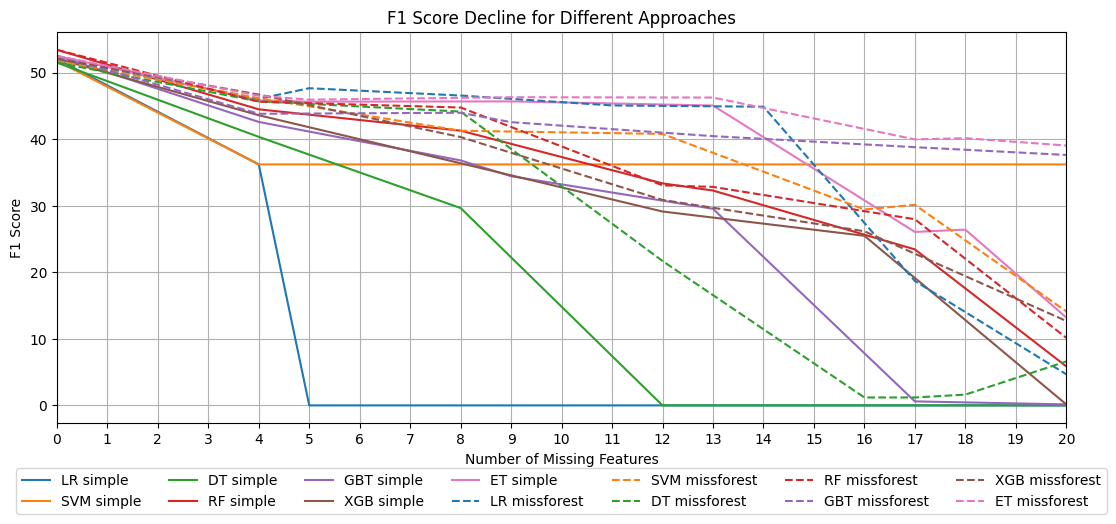

In [ ]:
# Line plot for the f1 score of the different models
plt.figure(figsize=(12, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']

plt.plot(lr_perf_temp['num_feat_missing'], lr_perf_temp['f1_score'], label='LR simple', color=colors[0])
plt.plot(svm_perf_temp['num_feat_missing'], svm_perf_temp['f1_score'], label='SVM simple', color=colors[1])
plt.plot(dt_perf_temp['num_feat_missing'], dt_perf_temp['f1_score'], label='DT simple', color=colors[2])
plt.plot(rf_perf_temp['num_feat_missing'], rf_perf_temp['f1_score'], label='RF simple', color=colors[3])
plt.plot(gbt_perf_temp['num_feat_missing'], gbt_perf_temp['f1_score'], label='GBT simple', color=colors[4])
plt.plot(xgb_perf_temp['num_feat_missing'], xgb_perf_temp['f1_score'], label='XGB simple', color=colors[5])
plt.plot(et_perf_temp['num_feat_missing'], et_perf_temp['f1_score'], label='ET simple', color=colors[6])

plt.plot(lr_perf_temp_mf['num_feat_missing'], lr_perf_temp_mf['f1_score'], label='LR missforest', color=colors[0], linestyle='--')
plt.plot(svm_perf_temp_mf['num_feat_missing'], svm_perf_temp_mf['f1_score'], label='SVM missforest', color=colors[1], linestyle='--')
plt.plot(dt_perf_temp_mf['num_feat_missing'], dt_perf_temp_mf['f1_score'], label='DT missforest', color=colors[2], linestyle='--')
plt.plot(rf_perf_temp_mf['num_feat_missing'], rf_perf_temp_mf['f1_score'], label='RF missforest', color=colors[3], linestyle='--')
plt.plot(gbt_perf_temp_mf['num_feat_missing'], gbt_perf_temp_mf['f1_score'], label='GBT missforest', color=colors[4], linestyle='--')
plt.plot(xgb_perf_temp_mf['num_feat_missing'], xgb_perf_temp_mf['f1_score'], label='XGB missforest', color=colors[5], linestyle='--')
plt.plot(et_perf_temp_mf['num_feat_missing'], et_perf_temp_mf['f1_score'], label='ET missforest', color=colors[6], linestyle='--')

plt.xlabel('Number of Missing Features')
plt.ylabel('F1 Score')
plt.title('F1 Score Decline for Different Approaches')
plt.xticks(range(0, NUM_FEAT+1))
plt.xlim(0, NUM_FEAT)
plt.legend(loc='lower center',  bbox_to_anchor=(0.5, -0.25), ncol=7)
plt.grid(True)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

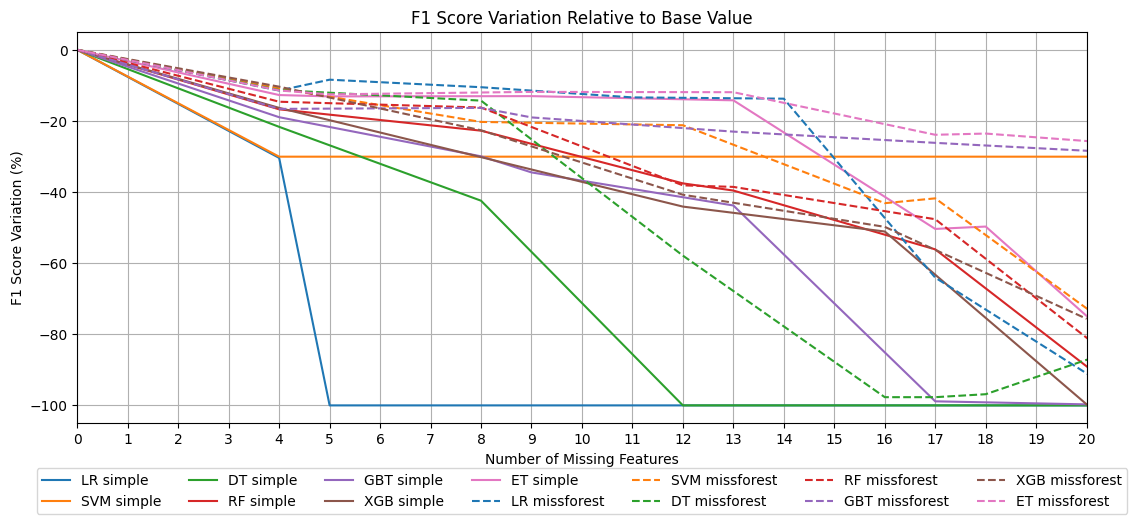

In [ ]:
# Line plot for the f1 score variation relative to the base value
plt.figure(figsize=(12, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2',
          '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
linestyles = ['-', '-', '-', '-', '-', '-', '-', '--', '--', '--', '--', '--', '--', '--']

# Calculate and plot the F1-score variation for each model
for perf_df, label, color, linestyle in zip(
    [lr_perf_temp, svm_perf_temp, dt_perf_temp, rf_perf_temp, gbt_perf_temp, xgb_perf_temp, et_perf_temp,
     lr_perf_temp_mf, svm_perf_temp_mf, dt_perf_temp_mf, rf_perf_temp_mf, gbt_perf_temp_mf, xgb_perf_temp_mf, et_perf_temp_mf],
    ['LR simple', 'SVM simple', 'DT simple', 'RF simple', 'GBT simple', 'XGB simple', 'ET simple',
     'LR missforest', 'SVM missforest', 'DT missforest', 'RF missforest', 'GBT missforest', 'XGB missforest', 'ET missforest'],
    colors,
    linestyles
):
    # Calculate the variation relative to the base F1-score
    f1_variation = (perf_df['f1_score'] - perf_df['f1_score'].iloc[0]) / perf_df['f1_score'].iloc[0] * 100
    plt.plot(perf_df['num_feat_missing'], f1_variation, label=label, color=color, linestyle=linestyle)

plt.xlabel('Number of Missing Features')
plt.ylabel('F1 Score Variation (%)')
plt.title('F1 Score Variation Relative to Base Value')
plt.xticks(range(0, NUM_FEAT+1))
plt.xlim(0, NUM_FEAT)
plt.legend(loc='lower center',  bbox_to_anchor=(0.5, -0.25), ncol=7)
plt.grid(True)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## **Balanced accuracy**

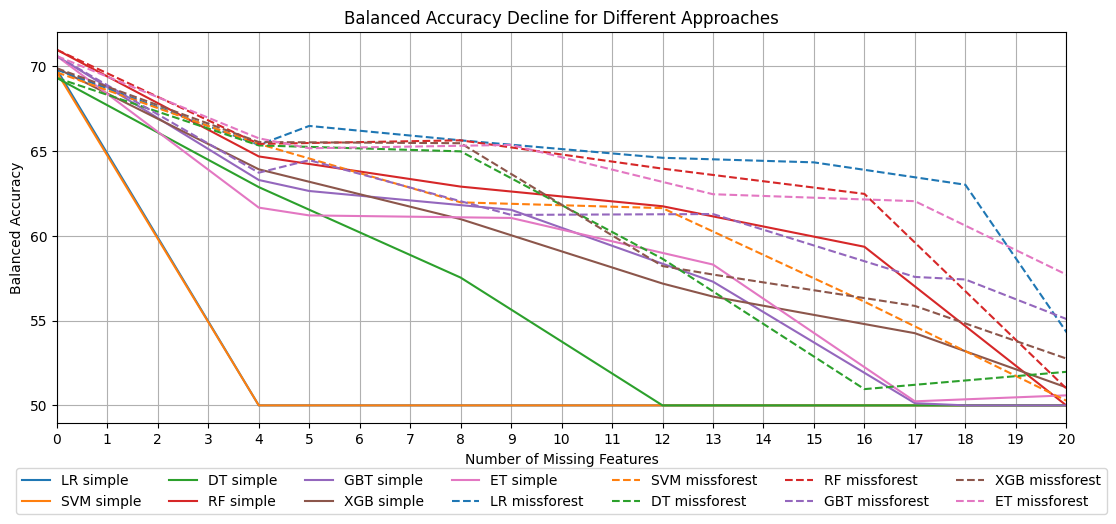

In [ ]:
# # Line plot for the balanced accuracy of the different models
plt.figure(figsize=(12, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']

plt.plot(lr2_perf_temp['num_feat_missing'], lr2_perf_temp['balanced_accuracy'], label='LR simple', color=colors[0])
plt.plot(svm2_perf_temp['num_feat_missing'], svm2_perf_temp['balanced_accuracy'], label='SVM simple', color=colors[1])
plt.plot(dt2_perf_temp['num_feat_missing'], dt2_perf_temp['balanced_accuracy'], label='DT simple', color=colors[2])
plt.plot(rf2_perf_temp['num_feat_missing'], rf2_perf_temp['balanced_accuracy'], label='RF simple', color=colors[3])
plt.plot(gbt2_perf_temp['num_feat_missing'], gbt2_perf_temp['balanced_accuracy'], label='GBT simple', color=colors[4])
plt.plot(xgb2_perf_temp['num_feat_missing'], xgb2_perf_temp['balanced_accuracy'], label='XGB simple', color=colors[5])
plt.plot(et2_perf_temp['num_feat_missing'], et2_perf_temp['balanced_accuracy'], label='ET simple', color=colors[6])

plt.plot(lr2_perf_temp_mf['num_feat_missing'], lr2_perf_temp_mf['balanced_accuracy'], label='LR missforest', color=colors[0], linestyle='--')
plt.plot(svm2_perf_temp_mf['num_feat_missing'], svm2_perf_temp_mf['balanced_accuracy'], label='SVM missforest', color=colors[1], linestyle='--')
plt.plot(dt2_perf_temp_mf['num_feat_missing'], dt2_perf_temp_mf['balanced_accuracy'], label='DT missforest', color=colors[2], linestyle='--')
plt.plot(rf2_perf_temp_mf['num_feat_missing'], rf2_perf_temp_mf['balanced_accuracy'], label='RF missforest', color=colors[3], linestyle='--')
plt.plot(gbt2_perf_temp_mf['num_feat_missing'], gbt2_perf_temp_mf['balanced_accuracy'], label='GBT missforest', color=colors[4], linestyle='--')
plt.plot(xgb2_perf_temp_mf['num_feat_missing'], xgb2_perf_temp_mf['balanced_accuracy'], label='XGB missforest', color=colors[5], linestyle='--')
plt.plot(et2_perf_temp_mf['num_feat_missing'], et2_perf_temp_mf['balanced_accuracy'], label='ET missforest', color=colors[6], linestyle='--')

plt.xlabel('Number of Missing Features')
plt.ylabel('Balanced Accuracy')
plt.title('Balanced Accuracy Decline for Different Approaches')
plt.xticks(range(0, NUM_FEAT+1))
plt.xlim(0, NUM_FEAT)
plt.legend(loc='lower center',  bbox_to_anchor=(0.5, -0.25), ncol=7)
plt.grid(True)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

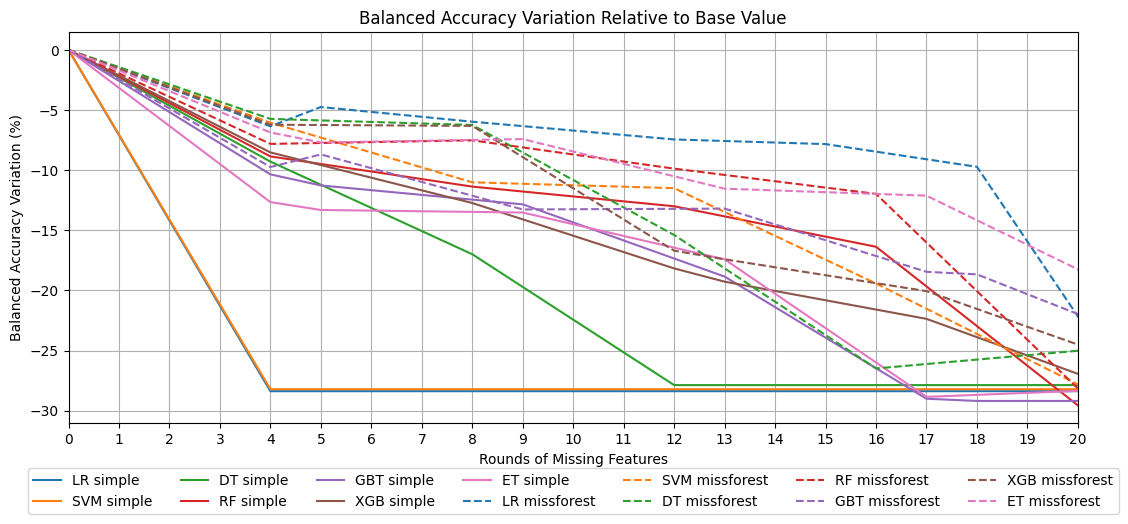

In [ ]:
# # Line plot for the balanced accuracy variation relative to the first value
plt.figure(figsize=(12, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2',
          '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
linestyles = ['-', '-', '-', '-', '-', '-', '-', '--', '--', '--', '--', '--', '--', '--']

# Calculate and plot the balanced accuracy variation for each model
for perf_df, label, color, linestyle in zip(
    [lr2_perf_temp, svm2_perf_temp, dt2_perf_temp, rf2_perf_temp, gbt2_perf_temp, xgb2_perf_temp, et2_perf_temp,
     lr2_perf_temp_mf, svm2_perf_temp_mf, dt2_perf_temp_mf, rf2_perf_temp_mf, gbt2_perf_temp_mf, xgb2_perf_temp_mf, et2_perf_temp_mf],
    ['LR simple', 'SVM simple', 'DT simple', 'RF simple', 'GBT simple', 'XGB simple', 'ET simple',
     'LR missforest', 'SVM missforest', 'DT missforest', 'RF missforest', 'GBT missforest', 'XGB missforest', 'ET missforest'],
    colors,
    linestyles
):
    # Calculate the variation relative to the base balanced accuracy
    balanced_accy_variation = (perf_df['balanced_accuracy'] - perf_df['balanced_accuracy'].iloc[0]) / perf_df['balanced_accuracy'].iloc[0] * 100
    plt.plot(perf_df['num_feat_missing'], balanced_accy_variation, label=label, color=color, linestyle=linestyle)

plt.xlabel('Rounds of Missing Features')
plt.ylabel('Balanced Accuracy Variation (%)')
plt.title('Balanced Accuracy Variation Relative to Base Value')
plt.xticks(range(0, NUM_FEAT+1))
plt.xlim(0, NUM_FEAT)
plt.legend(loc='lower center',  bbox_to_anchor=(0.5, -0.25), ncol=7)
plt.grid(True)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### **Save results**

In [ ]:
dataset_dict = {
    'lr_perf': lr_perf,
    'svm_perf': svm_perf,
    'dt_perf': dt_perf,
    'rf_perf': rf_perf,
    'gbt_perf': gbt_perf,
    'xgb_perf': xgb_perf,
    'et_perf': et_perf,
    'lr_perf_mf': lr_perf_mf,
    'svm_perf_mf': svm_perf_mf,
    'dt_perf_mf': dt_perf_mf,
    'rf_perf_mf': rf_perf_mf,
    'gbt_perf_mf': gbt_perf_mf,
    'xgb_perf_mf': xgb_perf_mf,
    'et_perf_mf': et_perf_mf,
    'lr2_perf': lr2_perf,
    'svm2_perf': svm2_perf,
    'dt2_perf': dt2_perf,
    'rf2_perf': rf2_perf,
    'gbt2_perf': gbt2_perf,
    'xgb2_perf': xgb2_perf,
    'et2_perf': et2_perf,
    'lr2_perf_mf': lr2_perf_mf,
    'svm2_perf_mf': svm2_perf_mf,
    'dt2_perf_mf': dt2_perf_mf,
    'rf2_perf_mf': rf2_perf_mf,
    'gbt2_perf_mf': gbt2_perf_mf,
    'xgb2_perf_mf': xgb2_perf_mf,
    'et2_perf_mf': et2_perf_mf
}

all_data = combine_datasets(
    dataset_dict,
    'Default Credit Card',  'Scenario 1: standard',
    RANDOM_STATE
)
save_dataset(all_data, 'default_cc_scenario1_seed_2025.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
dataset_temp_dict = {
    'lr_perf_temp': lr_perf_temp,
    'svm_perf_temp': svm_perf_temp,
    'dt_perf_temp': dt_perf_temp,
    'rf_perf_temp': rf_perf_temp,
    'gbt_perf_temp': gbt_perf_temp,
    'xgb_perf_temp': xgb_perf_temp,
    'et_perf_temp': et_perf_temp,
    'lr_perf_temp_mf': lr_perf_temp_mf,
    'svm_perf_temp_mf': svm_perf_temp_mf,
    'dt_perf_temp_mf': dt_perf_temp_mf,
    'rf_perf_temp_mf': rf_perf_temp_mf,
    'gbt_perf_temp_mf': gbt_perf_temp_mf,
    'xgb_perf_temp_mf': xgb_perf_temp_mf,
    'et_perf_temp_mf': et_perf_temp_mf,
    'lr2_perf_temp': lr2_perf_temp,
    'svm2_perf_temp': svm2_perf_temp,
    'dt2_perf_temp': dt2_perf_temp,
    'rf2_perf_temp': rf2_perf_temp,
    'gbt2_perf_temp': gbt2_perf_temp,
    'xgb2_perf_temp': xgb2_perf_temp,
    'et2_perf_temp': et2_perf_temp,
    'lr2_perf_temp_mf': lr2_perf_temp_mf,
    'svm2_perf_temp_mf': svm2_perf_temp_mf,
    'dt2_perf_temp_mf': dt2_perf_temp_mf,
    'rf2_perf_temp_mf': rf2_perf_temp_mf,
    'gbt2_perf_temp_mf': gbt2_perf_temp_mf,
    'xgb2_perf_temp_mf': xgb2_perf_temp_mf,
    'et2_perf_temp_mf': et2_perf_temp_mf
}

all_data_temp = combine_datasets(
    dataset_temp_dict,
    'Default Credit Card Temporal',  'Scenario 1: standard',
    RANDOM_STATE
)
save_dataset(all_data_temp, 'default_cc_temp_scenario1_seed_2025.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>